# 준비

In [ ]:
# 실행 후 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from collections import Counter
from ast import literal_eval # csv 파일 읽을 때 list를 str이 아닌 list 형태로 읽는 라이브러리
from itertools import chain
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 브라우저에서 바로 그려지도록
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

In [ ]:
# kiwi, hanja 라이브러리 설치
!pip install kiwipiepy
!pip install hanja==0.13.3 --no-deps argument

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.7/34.7 MB 23.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.17.0-py3-none-any.whl size=34845033 sha256=cadb6accd456ba4fd5cad3d070ac6efed865ce12ea7aa16d39136d36547c8d48
  Stored in directory: /root/.cache/pip/wheels/90/bb/ae/15e1cf26d17183040bac268fbf8d1ca1f45f7f4daa0fb76b91
Successfully built kiwipiepy-model
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for hanja: filename=hanja-0.13.3-py3-none-any.whl size=128387 sha256=09b308986431191558f865be1d1999d58842cb41ca952844471b202dbc5a17c7
  Stored in directory: /root/.cache/pip/wheels/e8/1d/ce/37cc4cf5ab3ffa59282052c212b7c47f0a6928a68c54511fa5
  Created wheel for argument: filename=argument-1.4.0-py3-none-a

In [ ]:
from kiwipiepy import Kiwi, Match
# model 변경(knlm -> sbg), 오타 교정 및 기타 옵션 추가
kiwi = Kiwi(model_type = 'sbg', load_default_dict= True, load_typo_dict = True, load_multi_dict = True, typos = 'basic_with_continual')
from kiwipiepy.sw_tokenizer import SwTokenizer
from kiwipiepy.sw_tokenizer import SwTokenizerConfig

In [ ]:
import hanja
from hanja import hangul

In [ ]:
# tomotopy 라이브러리 설치
!pip install tomotopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 22.7 MB/s eta 0:00:00


In [ ]:
import sys
import os, re
import pickle

from tomotopy import DMRModel
from tomotopy.utils import Corpus
from tomotopy import TermWeight
import tomotopy as tp

In [ ]:
# 호환용 한자를 통합 한자로 변환하는 함수 정의 (hanja 라이브러리를 통해 한자가 변환되지 않는 경우 방지) - https://bab2min.tistory.com/617
_table = {
'\uF903':'\u8CC8','\uFA09':'\u964D','\uFA0A':'\u898B','\uF901':'\u66F4',
'\uF909':'\u5951','\uF905':'\u4E32','\uFA0B':'\u5ED3','\uF906':'\u53E5',
'\uF900':'\u8C48','\uF90A':'\u91D1','\uF95B':'\u62CF','\uF95D':'\u8AFE',
'\uF90C':'\u5948','\uF981':'\u5973','\uF98E':'\u5E74','\uF991':'\u649A',
'\uF995':'\u79CA','\uF9A3':'\u5FF5','\uF9A4':'\u637B','\uF960':'\u6012',
'\uF9BD':'\u5C3F','\uF9C8':'\u677B','\uF9CF':'\u7D10','\uF9E3':'\u6CE5',
'\uF9EB':'\u533F','\uF9EC':'\u6EBA','\uF9FE':'\u8336','\uF95E':'\u4E39',
'\uFA03':'\u7CD6','\uFA04':'\u5B85','\uFA01':'\u5EA6','\uF95A':'\u8B80',
'\uFA05':'\u6D1E','\uF90B':'\u5587','\uF90D':'\u61F6','\uF90E':'\u7669',
'\uF90F':'\u7F85','\uF910':'\u863F','\uF911':'\u87BA','\uF912':'\u88F8',
'\uF913':'\u908F','\uF915':'\u6D1B','\uF916':'\u70D9','\uF917':'\u73DE',
'\uF918':'\u843D','\uF919':'\u916A','\uF91A':'\u99F1','\uF91B':'\u4E82',
'\uF91C':'\u5375','\uF91D':'\u6B04','\uF91E':'\u721B','\uF91F':'\u862D',
'\uF920':'\u9E1E','\uF921':'\u5D50','\uF922':'\u6FEB','\uF923':'\u85CD',
'\uF924':'\u8964','\uF925':'\u62C9','\uF926':'\u81D8','\uF927':'\u881F',
'\uF928':'\u5ECA','\uF929':'\u6717','\uF92A':'\u6D6A','\uF92B':'\u72FC',
'\uF92C':'\u90DE','\uF92D':'\u4F86','\uF92E':'\u51B7','\uF975':'\u63A0',
'\uF976':'\u7565','\uF977':'\u4EAE','\uF978':'\u5169','\uF979':'\u51C9',
'\uF97A':'\u6881','\uF97B':'\u7CE7','\uF97C':'\u826F','\uF97D':'\u8AD2',
'\uF97E':'\u91CF','\uF97F':'\u52F5','\uF980':'\u5442','\uF982':'\u5EEC',
'\uF983':'\u65C5','\uF984':'\u6FFE','\uF985':'\u792A','\uF986':'\u95AD',
'\uF987':'\u9A6A','\uF988':'\u9E97','\uF989':'\u9ECE','\uF98A':'\u529B',
'\uF98B':'\u66C6','\uF98C':'\u6B77','\uF98D':'\u8F62','\uF98F':'\u6190',
'\uF990':'\u6200','\uF992':'\u6F23','\uF993':'\u7149','\uF994':'\u7489',
'\uF996':'\u7DF4','\uF997':'\u806F','\uF999':'\u84EE','\uF998':'\u8F26',
'\uF99A':'\u9023','\uF99B':'\u934A','\uF99C':'\u5217','\uF99D':'\u52A3',
'\uF99F':'\u70C8','\uF9A0':'\u88C2','\uF9A2':'\u5EC9','\uF9A5':'\u6BAE',
'\uF9A6':'\u7C3E','\uF9A7':'\u7375','\uF9A8':'\u4EE4','\uF9A9':'\u56F9',
'\uF9AB':'\u5DBA','\uF9AC':'\u601C','\uF9AD':'\u73B2','\uF9AF':'\u7F9A',
'\uF9B0':'\u8046','\uF9B1':'\u9234','\uF9B2':'\u96F6','\uF9B3':'\u9748',
'\uF9B4':'\u9818','\uF9B5':'\u4F8B','\uF9B6':'\u79AE','\uF9B7':'\u91B4',
'\uF9B8':'\u96B7','\uF92F':'\u52DE','\uF930':'\u64C4','\uF931':'\u6AD3',
'\uF932':'\u7210','\uF933':'\u76E7','\uF934':'\u8001','\uF935':'\u8606',
'\uF936':'\u865C','\uF937':'\u8DEF','\uF938':'\u9732','\uF939':'\u9B6F',
'\uF93A':'\u9DFA','\uF93B':'\u788C','\uF93C':'\u797F','\uF93D':'\u7DA0',
'\uF93E':'\u83C9','\uF93F':'\u9304','\uF940':'\u9E7F','\uF941':'\u8AD6',
'\uF942':'\u58DF','\uF943':'\u5F04','\uF944':'\u7C60','\uF945':'\u807E',
'\uF946':'\u7262','\uF947':'\u78CA','\uF948':'\u8CC2','\uF949':'\u96F7',
'\uF9BA':'\u4E86','\uF9BB':'\u50DA','\uF9BC':'\u5BEE','\uF9BE':'\u6599',
'\uF9C0':'\u71CE','\uF9C1':'\u7642','\uF9C2':'\u84FC','\uF9C3':'\u907C',
'\uF9C4':'\u9F8D','\uF94A':'\u58D8','\uF94B':'\u5C62','\uF94C':'\u6A13',
'\uF94D':'\u6DDA','\uF94E':'\u6F0F','\uF94F':'\u7D2F','\uF950':'\u7E37',
'\uF951':'\u964B','\uF9C7':'\u5289','\uF9C9':'\u67F3','\uF9CA':'\u6D41',
'\uF9CB':'\u6E9C','\uF9CC':'\u7409','\uF9CD':'\u7559','\uF9CE':'\u786B',
'\uF9D0':'\u985E','\uF9D1':'\u516D','\uF9D2':'\u622E','\uF9D3':'\u9678',
'\uF9D4':'\u502B','\uF9D5':'\u5D19','\uF9D6':'\u6DEA','\uF9D7':'\u8F2A',
'\uF9D8':'\u5F8B','\uF9D9':'\u6144','\uF9DA':'\u6817','\uF9DC':'\u9686',
'\uF952':'\u52D2','\uF953':'\u808B','\uF954':'\u51DC','\uF955':'\u51CC',
'\uF956':'\u7A1C','\uF957':'\u7DBE','\uF958':'\u83F1','\uF959':'\u9675',
'\uF9DD':'\u5229','\uF9DE':'\u540F','\uF9DF':'\u5C65','\uF9E1':'\u674E',
'\uF9E2':'\u68A8','\uF9E4':'\u7406','\uF9E5':'\u75E2','\uF9E6':'\u7F79',
'\uF9E7':'\u88CF','\uF9E8':'\u88E1','\uF9E9':'\u91CC','\uF9EA':'\u96E2',
'\uF9ED':'\u541D','\uF9EE':'\u71D0','\uF9EF':'\u7498','\uF9F0':'\u85FA',
'\uF9F1':'\u96A3','\uF9F2':'\u9C57','\uF9F3':'\u9E9F','\uF9F4':'\u6797',
'\uF9F5':'\u6DCB','\uF9F6':'\u81E8','\uF9F7':'\u7ACB','\uF9F8':'\u7B20',
'\uF9F9':'\u7C92','\uF964':'\u78FB','\uF966':'\u5FA9','\uFA07':'\u8F3B',
'\uF967':'\u4E0D','\uF963':'\u5317','\uF970':'\u6BBA','\uF9FA':'\u72C0',
'\uF96C':'\u585E','\uF96A':'\u7D22','\uF96D':'\u7701','\uF969':'\u6578',
'\uF973':'\u62FE','\uF9FC':'\u8B58','\uF9FD':'\u4EC0','\uF9B9':'\u60E1',
'\uF974':'\u82E5','\uF9E0':'\u6613','\uF96E':'\u8449','\uF9C6':'\u962E',
'\uF962':'\u7570','\uF99E':'\u54BD','\uF9FF':'\u523A','\uF9FB':'\u7099',
'\uFA00':'\u5207','\uF971':'\u8FB0','\uF902':'\u8ECA','\uF96B':'\u53C3',
'\uFA02':'\u62D3','\uF972':'\u6C88','\uF965':'\u4FBF','\uFA06':'\u66B4',
'\uF968':'\u6CCC','\uFA08':'\u884C','\uF9AE':'\u7469','\uF904':'\u6ED1',
'\uF9C5':'\u6688','\uF907':'\u9F9C','\uF908':'\u9F9C','\uF95F':'\u5BE7',
'\uF9AA':'\u5BE7','\uF96F':'\u8AAA','\uF9A1':'\u8AAA','\uF961':'\u7387',
'\uF9DB':'\u7387','\uF914':'\u6A02','\uF95C':'\u6A02','\uF9BF':'\u6A02'
}

def transform(s):
    for k, v in _table.items():
        s = s.replace(k, v)
    return s

# Data Cleaning 1 (동아일보, 조선일보)

In [ ]:
# 'title_ori' - 제목, 'body_ori' - 제목 및 본문, 'publication_date' - 발행일자, 'year' - 발행연도, 'company' - 신문사
result = pd.read_csv('/content/drive/MyDrive/졸업논문 데이터/result_preprocessed.csv', encoding = 'UTF-8')
result

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
0,0,反民族行爲處罰法 施行細則討議 特別調査委員會等草案(1),反民族行爲處罰法\n施行細則討議\n特別調査委員會等草案(1)\n 反民族行爲處罰法起草特別...,1948-08-15,1948,조선일보
1,1,感激과새决意 各界의記念辭 自疆自進外侮防止,感激과새决意 各界의記念辭自疆自進外侮防止李大統領大韓民國大統領李承晚博士는 八·一五記念日...,1948-08-15,1948,동아일보
2,2,民族的團結로 重大時局突破하자,民族的團結로重大時局突破하자李副統領세번째의八、一五解放記念을 맞게되니感慨깊은바있다 나는...,1948-08-15,1948,동아일보
3,3,맥將軍夫妻今日來朝 獨立式典에招請을받고,맥將軍夫妻今日來朝獨立式典에招請을받고政府樹立紀念式典에 李大統領은 聯合軍最高司令官『맥아...,1948-08-15,1948,동아일보
4,4,統一運動推進,統一運動推進金九氏八·一五記念日을맞이하야 金九氏는다음과같은 談話를發表하였다三年이지난 ...,1948-08-15,1948,동아일보
...,...,...,...,...,...,...
590714,590714,교릉팀,교릉팀\n,1960-06-14,1960,조선일보
590715,590715,崔夏永을起訴,崔夏永을起訴\n검찰은 十四일 심계원장최하영(崔夏永)을 선거법위반 직무유기 공문서허위...,1960-06-14,1960,조선일보
590716,590716,「浪說아니다」,「浪說아니다」\n高湛龍議員談\n한편 被告訴人인 高湛龍議員은 이날談話를 發表하여 그의...,1960-06-14,1960,조선일보
590717,590717,"「共和同志會」登錄 自由黨離脫派42議員,脫黨도聲明","「共和同志會」登錄\n自由黨離脫派42議員,脫黨도聲明\n崔奎南議員을비롯한 四十二名의 自...",1960-06-14,1960,조선일보


In [ ]:
# 'body_ori'에서 주권을 포함한 기사를 필터링
pattern = r'주\s*권|主\s*權'
result_sovereignty = result[result['body_ori'].str.contains(pattern, regex=True, case=False)]
result_sovereignty

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
13,13,解放四年·希望의새아침 自主獨立完全達成에,解放四年·希望의새아침自主獨立完全達成에政府와國民은一體가되라우리는 드디어 解放四年을 오...,1948-08-15,1948,동아일보
24,24,獨立政府宣佈式을맞이하여,獨立政府宣佈式을맞이하여一四年前오늘 日帝로부터解放되자 民族의光明을찻고자 惡戰苦鬪한바 ...,1948-08-15,1948,동아일보
36,36,悠久한半萬年歷史 이江山에다시빗나다,悠久한半萬年歷史이江山에다시빗나다오늘獨立宣佈日四十년간이나왜적의 철제(鐵蹄)민에서 일헛...,1948-08-15,1948,동아일보
88,88,政府樹立의歷史的盛典,政府樹立의歷史的盛典\n主權恢復을宣布\n內外賓客參席裡盛大히擧行\n 大韓民國政府樹立을 ...,1948-08-16,1948,조선일보
95,95,羅馬法王도祝賀멧세지,羅馬法王도\n祝賀멧세지\n羅馬法王廳에서는昨十五日大韓民國 政府樹立記念式에 韓國駐在敎皇...,1948-08-16,1948,조선일보
...,...,...,...,...,...,...
589713,589713,不正選擧元兇들公訴狀 ❸,不正選擧元兇들公訴狀❸同崔仁圭는 四二七五年十二月頃 京城高等商業學校를卒業하고 四二七六年...,1960-06-10,1960,동아일보
589905,589905,第一銀行株主總會 14日로延期,第一銀行株主總會14日로延期裏面의折衷決裂銀行長後任에財務部·鄭載頀氏間에對立第一銀行臨時株...,1960-06-11,1960,동아일보
590143,590143,內閣責任制 改憲案 提案說明에對한 疑問,內閣責任制 改憲案 提案說明에對한 疑問\n一\n지난 五月十一日字로 公告된바있는 所謂 ...,1960-06-12,1960,조선일보
590412,590412,改憲案의批判과展望,改憲案의批判과展望\n(中)\n夫琓爀\n天賦人權의 思想을基源으로하는 現代民主主義國家에...,1960-06-13,1960,조선일보


In [ ]:
### 문서 Plus (나중에, 이체자 등 반영)

pattern = r'주\s*權|主\s*권|注\s*權|主\s*权|主\s*権'
result_sovereignty = result[result['body_ori'].str.contains(pattern, regex=True, case=False)]
result_sovereignty['title_ori'] = result_sovereignty['title_ori'].astype(str)
result_sovereignty['title_ori'] = result_sovereignty['title_ori'].apply(transform)
result_sovereignty['body_ori'] = result_sovereignty['body_ori'].apply(transform)
for index, row in result_sovereignty.iterrows():
    result_sovereignty['title_ori'][index] = hanja.translate(result_sovereignty['title_ori'][index], 'substitution')
    result_sovereignty['body_ori'][index] = hanja.translate(result_sovereignty['body_ori'][index], 'substitution')
result_sovereignty['title_count'] = result_sovereignty['title_ori'].str.count('주\s*권|주\s*權|主\s*권|注\s*權|主\s*权|主\s*権')
result_sovereignty['body_count'] = result_sovereignty['body_ori'].str.count('주\s*권|주\s*權|主\s*권|注\s*權|主\s*权|主\s*権')
result_sovereignty_filtered = result_sovereignty[(result_sovereignty['body_count'] >=3) | (result_sovereignty['title_count'] == 1)] # 추가할 문서: 83062, 571015, 571764, 571994, 572495
result_sovereignty_filtered

<ipython-input-240-4b6a521482e3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_sovereignty['title_ori'] = result_sovereignty['title_ori'].astype(str)
<ipython-input-240-4b6a521482e3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_sovereignty['title_ori'] = result_sovereignty['title_ori'].apply(transform)
<ipython-input-240-4b6a521482e3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

,Unnamed: 0,title_ori,body_ori,publication_date,year,company,title_count,body_count
83062,83062,서독예자주권을부여,서독예자주권을부여삼외상재무장에도완전합의【파리입이일발AP‖합동】서독수상〃코ㄴ라드·아데...,1951-11-24,1951,동아일보,1,1
84549,84549,영애문제해결난望 명초에독에주권부여,영애문제해결난望명초에독에주권부여애장관회견담【워싱톤입일발UP‖대한】습구일미국무장관『애...,1951-12-21,1951,동아일보,1,2
144120,144120,한국문제 해결 시안내용 검토,한국문제 해결시안내용 검토판문점에서 열리인정치회의에대한 예비회담에서 적공산편에서는 ...,1953-11-01,1953,동아일보,0,6
157686,157686,국민의주권행사로심판,국민의주권행사로심판현의원에대한비난에신의장성명이십오일신익희국회의장은 현국회와국회의원들...,1954-03-26,1954,동아일보,1,3
462703,462703,결의문,결의문\n일본의 불법적처사는첫째로 한반도에있어서의 유일한 합법정부인 대한민국정부에 ...,1959-02-21,1959,조선일보,0,3
571015,571015,총맞은주권 마산의정언 ❶,총맞은주권마산의정언❶봉화란산화로판명불온구호들었다는자는단한사람파출소방화증거없고마산사건...,1960-03-30,1960,동아일보,1,1
571764,571764,총맞은 주권 마산의정언❷,총맞은주권마산의정언❷책임은정책면에폭력안썻던들 사고없었을것을소방차와괴한동원으로악화◇|...,1960-04-01,1960,동아일보,1,1
571994,571994,총맞은 주권 마산의정언 ❸,총맞은주권마산의정언❸기어코발사된실탄학생들총맛자 시민들이구원갈수록총성심해지고◇|이곳마...,1960-04-02,1960,동아일보,1,1
572254,572254,총맞은주권 마산의정언 ❹,총맞은주권마산의정언❹무차별집중사격덮어놓고『빨갱이』취급하는근성퇴산하는학생에게도◇|「데...,1960-04-03,1960,동아일보,1,2
572495,572495,총맞은주권 마산의정언 ❺,총맞은주권마산의정언❺밝혀야할사망수학생데모의법률적숙제는풀린셈아직행방불명자오명◇|경찰관...,1960-04-04,1960,동아일보,1,1


In [ ]:
# pattern 문자열을 포함한 기사 확인 및 제외(기준을 불충족한 경우)
pattern = r'株\s*券'
result_except = result_sovereignty[result_sovereignty['body_ori'].str.contains(pattern, regex = True, case = False)]
result_except

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
12026,12026,韓美親善에美談一幕,韓美親善에美談一幕\n舊韓國時代의美人技士\n遣書로留學生學費提供\n방금문교부에는재서울미...,1949-01-15,1949,조선일보
27947,27947,淸州郡是生絲 賃貸借問題로蹶起,淸州郡是生絲賃貸借問題로蹶起\n【淸州十四日發時電】충북도내에 유一무二한 생사(生絲)기관...,1949-06-17,1949,조선일보
114230,114230,二重監督의弊端指摘,二重監督의弊端指摘交通部서財務部에移讓要請？『海公』『造公』株主權行使해운계발전을 위하여중...,1952-12-16,1952,동아일보
144265,144265,歸財法無視했 다고無効主張,歸財法無視했\n다고無効主張\n殖銀等役員改選\n귀속재산의 처리사무는나날이 복잡하여가는...,1953-11-03,1953,조선일보
341609,341609,第一生命不正 帳簿等을押收 社長에搜索令狀,第一生命不正帳簿等을押收社長에搜索令狀第一生命保險株式會社(中區陽洞八六番地所在)내의 모종...,1957-06-18,1957,동아일보
372472,372472,豊國煉炭社長被訴,豊國煉炭社長被訴\n十九일 서울지검에서 알려진바에의하면 탄광(炭礦)기업체로 이름있는풍...,1957-11-20,1957,조선일보
388200,388200,歸財處理와電氣事業⑥,"歸財處理와電氣事業⑥\n=現行歸財法의 矛盾性을指摘함=\n姜辰國\n五,廣汎한 國民投資의...",1958-02-13,1958,조선일보
398176,398176,月曜應接室,月曜應接室選挙【問】국회의원입후보자로서 선거운동기간중 허위이력을나열하여유권자를 기만해...,1958-04-07,1958,동아일보
445942,445942,證據物 押收에着手,證據物押收에着手十億恐喝嫌疑事件에搜索令狀작보‖一○억환 공갈혐의사건」을 수사중인서울지검...,1958-12-12,1958,동아일보
446252,446252,四名을拘束起訴,四名을拘束起訴\n十億圜의 株券强奪事件\n十三일상오 서울지방검찰청강서룡(姜瑞龍)부장검...,1958-12-14,1958,조선일보


In [ ]:
pattern = r'株\s*券'
result_sovereignty = result_sovereignty[~result_sovereignty['body_ori'].str.contains(pattern, regex=True, case=False)]
result_sovereignty

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
13,13,解放四年·希望의새아침 自主獨立完全達成에,解放四年·希望의새아침自主獨立完全達成에政府와國民은一體가되라우리는 드디어 解放四年을 오...,1948-08-15,1948,동아일보
24,24,獨立政府宣佈式을맞이하여,獨立政府宣佈式을맞이하여一四年前오늘 日帝로부터解放되자 民族의光明을찻고자 惡戰苦鬪한바 ...,1948-08-15,1948,동아일보
36,36,悠久한半萬年歷史 이江山에다시빗나다,悠久한半萬年歷史이江山에다시빗나다오늘獨立宣佈日四十년간이나왜적의 철제(鐵蹄)민에서 일헛...,1948-08-15,1948,동아일보
88,88,政府樹立의歷史的盛典,政府樹立의歷史的盛典\n主權恢復을宣布\n內外賓客參席裡盛大히擧行\n 大韓民國政府樹立을 ...,1948-08-16,1948,조선일보
95,95,羅馬法王도祝賀멧세지,羅馬法王도\n祝賀멧세지\n羅馬法王廳에서는昨十五日大韓民國 政府樹立記念式에 韓國駐在敎皇...,1948-08-16,1948,조선일보
...,...,...,...,...,...,...
589713,589713,不正選擧元兇들公訴狀 ❸,不正選擧元兇들公訴狀❸同崔仁圭는 四二七五年十二月頃 京城高等商業學校를卒業하고 四二七六年...,1960-06-10,1960,동아일보
589905,589905,第一銀行株主總會 14日로延期,第一銀行株主總會14日로延期裏面의折衷決裂銀行長後任에財務部·鄭載頀氏間에對立第一銀行臨時株...,1960-06-11,1960,동아일보
590143,590143,內閣責任制 改憲案 提案說明에對한 疑問,內閣責任制 改憲案 提案說明에對한 疑問\n一\n지난 五月十一日字로 公告된바있는 所謂 ...,1960-06-12,1960,조선일보
590412,590412,改憲案의批判과展望,改憲案의批判과展望\n(中)\n夫琓爀\n天賦人權의 思想을基源으로하는 現代民主主義國家에...,1960-06-13,1960,조선일보


In [ ]:
# pattern 문자열을 포함한 기사 확인 및 제외(기준을 불충족한 경우)
pattern = r'주\s*주\s*권|株\s*主\s*權'
result_except = result_sovereignty[result_sovereignty['body_ori'].str.contains(pattern, regex = True, case = False)]
result_except

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
44407,44407,中共治下의平津 自由잃은中国의內幕 (2)1,中共治下의平津自由잃은中国의內幕經濟政策의實態私人商工業의存在抹殺章丙炎 著 許宇成 ...,1949-11-17,1949,동아일보
63613,63613,歸屬財產處理法施行細則 (四),歸屬財產處理法施行細則\n(四)\n 第三十三條 歸屬財產의賃借人은管財廳長또는管財局畏이 ...,1950-06-04,1950,조선일보
87161,87161,領海主權宣言은 韓日衝突防止爲한것,領海主權宣言은\n韓日衝突防止爲한것\n李大統領海洋主權宣言談\n 釜山發=時事】이(李)대...,1952-02-10,1952,조선일보
128743,128743,地方通勤列車運行推進 海公等株權移讓問題를協議,地方通勤列車運行推進海公等株權移讓問題를協議尹交通長官談湖南지방을초도순시하고돌아온 尹교통...,1953-05-19,1953,동아일보
169486,169486,銀行法實施에따른 歸屬株拂下의位置,銀行法實施에따른歸屬株拂下의位置박 숙 히去七月二十日의 國務會議에서는 金融界뿐만...,1954-07-26,1954,동아일보
170769,170769,財務部實質的發言權喪失 銀行株拂下 여기도自由黨이한목볼듯,財務部實質的發言權喪失銀行株拂 下여기도自由黨이한목볼듯四二八三年五月六日法律第一三九號로...,1954-08-08,1954,동아일보
171841,171841,市銀重役大幅異動?秋期株總앞두고當局서推進,市銀重役大幅異動？秋期株總앞두고當局서推進銀行法施行과 銀行歸屬株拂下問題를中心으로金融界가...,1954-08-19,1954,동아일보
229923,229923,序幕열은 金融界人事波動,序幕열은金融界人事波動金財務次官韓銀復歸說再燃朝興銀行重役七名改選에波瀾？韓銀副總裁金鎭烱氏...,1955-10-22,1955,동아일보
298250,298250,情實과壓力은如前,情實과壓力은如前……銀行『株總』과重役改善에物議……지난二十三日부터 二十七日까지 四日間에...,1956-10-29,1956,동아일보
298424,298424,財務部서辭表促求(中)商銀安行長과李專務,財務部서辭表促求(中)商銀安行長과李專務金氏는長官을찾았으나不在였음으로 千次官을찾아『退任...,1956-10-30,1956,동아일보


In [ ]:
result_except = result_except.drop([87161, 452610, 578177, 578382, 578532, 578659], axis=0)
result_except

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
44407,44407,中共治下의平津 自由잃은中国의內幕 (2)1,中共治下의平津自由잃은中国의內幕經濟政策의實態私人商工業의存在抹殺章丙炎 著 許宇成 ...,1949-11-17,1949,동아일보
63613,63613,歸屬財產處理法施行細則 (四),歸屬財產處理法施行細則\n(四)\n 第三十三條 歸屬財產의賃借人은管財廳長또는管財局畏이 ...,1950-06-04,1950,조선일보
128743,128743,地方通勤列車運行推進 海公等株權移讓問題를協議,地方通勤列車運行推進海公等株權移讓問題를協議尹交通長官談湖南지방을초도순시하고돌아온 尹교통...,1953-05-19,1953,동아일보
169486,169486,銀行法實施에따른 歸屬株拂下의位置,銀行法實施에따른歸屬株拂下의位置박 숙 히去七月二十日의 國務會議에서는 金融界뿐만...,1954-07-26,1954,동아일보
170769,170769,財務部實質的發言權喪失 銀行株拂下 여기도自由黨이한목볼듯,財務部實質的發言權喪失銀行株拂 下여기도自由黨이한목볼듯四二八三年五月六日法律第一三九號로...,1954-08-08,1954,동아일보
171841,171841,市銀重役大幅異動?秋期株總앞두고當局서推進,市銀重役大幅異動？秋期株總앞두고當局서推進銀行法施行과 銀行歸屬株拂下問題를中心으로金融界가...,1954-08-19,1954,동아일보
229923,229923,序幕열은 金融界人事波動,序幕열은金融界人事波動金財務次官韓銀復歸說再燃朝興銀行重役七名改選에波瀾？韓銀副總裁金鎭烱氏...,1955-10-22,1955,동아일보
298250,298250,情實과壓力은如前,情實과壓力은如前……銀行『株總』과重役改善에物議……지난二十三日부터 二十七日까지 四日間에...,1956-10-29,1956,동아일보
298424,298424,財務部서辭表促求(中)商銀安行長과李專務,財務部서辭表促求(中)商銀安行長과李專務金氏는長官을찾았으나不在였음으로 千次官을찾아『退任...,1956-10-30,1956,동아일보
349778,349778,國庫還收를指示,國庫還收를指示\n李氏가配定받은興銀利益金\n二十九日 金顯哲財務部長官은 興銀歸屬株를 拂...,1957-07-30,1957,조선일보


In [ ]:
mask = ~result_sovereignty.set_index(['Unnamed: 0', 'title_ori', 'body_ori', 'publication_date', 'year', 'company']).index.isin(result_except.set_index(['Unnamed: 0', 'title_ori', 'body_ori', 'publication_date', 'year', 'company']).index)
result_sovereignty = result_sovereignty[mask]
result_sovereignty

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
13,13,解放四年·希望의새아침 自主獨立完全達成에,解放四年·希望의새아침自主獨立完全達成에政府와國民은一體가되라우리는 드디어 解放四年을 오...,1948-08-15,1948,동아일보
24,24,獨立政府宣佈式을맞이하여,獨立政府宣佈式을맞이하여一四年前오늘 日帝로부터解放되자 民族의光明을찻고자 惡戰苦鬪한바 ...,1948-08-15,1948,동아일보
36,36,悠久한半萬年歷史 이江山에다시빗나다,悠久한半萬年歷史이江山에다시빗나다오늘獨立宣佈日四十년간이나왜적의 철제(鐵蹄)민에서 일헛...,1948-08-15,1948,동아일보
88,88,政府樹立의歷史的盛典,政府樹立의歷史的盛典\n主權恢復을宣布\n內外賓客參席裡盛大히擧行\n 大韓民國政府樹立을 ...,1948-08-16,1948,조선일보
95,95,羅馬法王도祝賀멧세지,羅馬法王도\n祝賀멧세지\n羅馬法王廳에서는昨十五日大韓民國 政府樹立記念式에 韓國駐在敎皇...,1948-08-16,1948,조선일보
...,...,...,...,...,...,...
589475,589475,"""特權經濟는막혓다""",〃特權經濟는막혓다〃全復興部長官、當面問題에言及全復興部長官은九日記者會見에서 過政의經濟的...,1960-06-10,1960,동아일보
589713,589713,不正選擧元兇들公訴狀 ❸,不正選擧元兇들公訴狀❸同崔仁圭는 四二七五年十二月頃 京城高等商業學校를卒業하고 四二七六年...,1960-06-10,1960,동아일보
590143,590143,內閣責任制 改憲案 提案說明에對한 疑問,內閣責任制 改憲案 提案說明에對한 疑問\n一\n지난 五月十一日字로 公告된바있는 所謂 ...,1960-06-12,1960,조선일보
590412,590412,改憲案의批判과展望,改憲案의批判과展望\n(中)\n夫琓爀\n天賦人權의 思想을基源으로하는 現代民主主義國家에...,1960-06-13,1960,조선일보


In [ ]:
# pattern 문자열을 포함한 기사 확인 및 제외(기준을 불충족한 경우)
pattern = r'호\s*주\s*권|戶\s*主\s*權'
result_sovereignty = result_sovereignty[~result_sovereignty['body_ori'].str.contains(pattern, regex = True, case = False)]
result_sovereignty

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
13,13,解放四年·希望의새아침 自主獨立完全達成에,解放四年·希望의새아침自主獨立完全達成에政府와國民은一體가되라우리는 드디어 解放四年을 오...,1948-08-15,1948,동아일보
24,24,獨立政府宣佈式을맞이하여,獨立政府宣佈式을맞이하여一四年前오늘 日帝로부터解放되자 民族의光明을찻고자 惡戰苦鬪한바 ...,1948-08-15,1948,동아일보
36,36,悠久한半萬年歷史 이江山에다시빗나다,悠久한半萬年歷史이江山에다시빗나다오늘獨立宣佈日四十년간이나왜적의 철제(鐵蹄)민에서 일헛...,1948-08-15,1948,동아일보
88,88,政府樹立의歷史的盛典,政府樹立의歷史的盛典\n主權恢復을宣布\n內外賓客參席裡盛大히擧行\n 大韓民國政府樹立을 ...,1948-08-16,1948,조선일보
95,95,羅馬法王도祝賀멧세지,羅馬法王도\n祝賀멧세지\n羅馬法王廳에서는昨十五日大韓民國 政府樹立記念式에 韓國駐在敎皇...,1948-08-16,1948,조선일보
...,...,...,...,...,...,...
589475,589475,"""特權經濟는막혓다""",〃特權經濟는막혓다〃全復興部長官、當面問題에言及全復興部長官은九日記者會見에서 過政의經濟的...,1960-06-10,1960,동아일보
589713,589713,不正選擧元兇들公訴狀 ❸,不正選擧元兇들公訴狀❸同崔仁圭는 四二七五年十二月頃 京城高等商業學校를卒業하고 四二七六年...,1960-06-10,1960,동아일보
590143,590143,內閣責任制 改憲案 提案說明에對한 疑問,內閣責任制 改憲案 提案說明에對한 疑問\n一\n지난 五月十一日字로 公告된바있는 所謂 ...,1960-06-12,1960,조선일보
590412,590412,改憲案의批判과展望,改憲案의批判과展望\n(中)\n夫琓爀\n天賦人權의 思想을基源으로하는 現代民主主義國家에...,1960-06-13,1960,조선일보


In [ ]:
# pattern 문자열을 포함한 기사 확인 및 제외(기준을 불충족한 경우)
pattern = r'영\s*주\s*권|永\s*住\s*權'
result_except = result_sovereignty[result_sovereignty['body_ori'].str.contains(pattern, regex = True, case = False)]
result_except.index

Index([  7729,  84755,  84965,  87134,  92112,  94838, 116292, 116307, 188198,
       188980, 194438, 211921, 226826, 271996, 272092, 318034, 318819, 326321,
       341158, 348650, 350923, 386740, 389461, 396970, 400954, 409887, 420774,
       424917, 451657, 452948, 454524, 459476, 460342, 460477, 462453, 508342,
       509336, 549477],
      dtype='int64')

In [ ]:
result_except = result_except.drop([7729, 116292, 116307, 226826, 318034, 326321, 509336], axis=0)
result_except

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
84755,84755,原則엔大體合意,原則엔大體合意\n韓日協商僑胞의法的地位\n 十九일하오二시부터개최된 한일협상국적분과위원...,1951-12-24,1951,조선일보
84965,84965,一部特權을認定 僑胞待遇,一部特權을認定僑胞待遇\n韓日協商年末年始는休會\n 【東京發大韓】지난十월二十일회담개시이...,1951-12-29,1951,조선일보
87134,87134,國籍問題等不遠折衝,國籍問題等不遠折衝\n韓日協商工業上特權等一切에合意\n【東京□時事】동경에서전하는바에 의...,1952-02-09,1952,조선일보
92112,92112,僑胞永住權獲得,僑胞永住權獲得\n不遠韓日協約을締結\n【東京發中央社大韓】十五일일본아사히(朝日)신문이보...,1952-04-18,1952,조선일보
94838,94838,韓國에再送視 大村收容所의 强制送還교胞,韓國에再送視\n大村收容所의\n强制送還교胞\n【釜山發】기보한바와같이지난十三일우리정부는...,1952-05-23,1952,조선일보
188198,188198,大村收容所 僑胞釋放,大村收容所僑胞釋放\n日提案을우리政府受諾\n十일 외무부당국자가 말한바에 의하면 정부에...,1955-01-11,1955,조선일보
188980,188980,保釋金要求不當,保釋金要求不當\n卞長官在日僑胞釋放에談\n十五일 변외무부장관은기자회견석상에서 一천三백...,1955-01-16,1955,조선일보
194438,194438,大村抑留僑胞歸還,"大村抑留僑胞歸還\n一日,釜山에二百九名\n二十六일 알려진바에 의하면 일본 오호무라(大...",1955-02-27,1955,조선일보
211921,211921,濱松收容所의,濱松收容所의\n密航僑胞不遠引受\n의무부에서는 머지않아일본 하마마쯔(濱松)수용소에 억...,1955-06-30,1955,조선일보
271996,271996,李玖氏에永住權 美上院서賦與키로可決,李玖氏에永住權美上院서賦與키로可決【워싱톤十八日發AP‖合同』미상원은십八일 한국의마지막왕...,1956-06-20,1956,동아일보


In [ ]:
mask = ~result_sovereignty.set_index(['Unnamed: 0', 'title_ori', 'body_ori', 'publication_date', 'year', 'company']).index.isin(result_except.set_index(['Unnamed: 0', 'title_ori', 'body_ori', 'publication_date', 'year', 'company']).index)
result_sovereignty = result_sovereignty[mask]
result_sovereignty

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
13,13,解放四年·希望의새아침 自主獨立完全達成에,解放四年·希望의새아침自主獨立完全達成에政府와國民은一體가되라우리는 드디어 解放四年을 오...,1948-08-15,1948,동아일보
24,24,獨立政府宣佈式을맞이하여,獨立政府宣佈式을맞이하여一四年前오늘 日帝로부터解放되자 民族의光明을찻고자 惡戰苦鬪한바 ...,1948-08-15,1948,동아일보
36,36,悠久한半萬年歷史 이江山에다시빗나다,悠久한半萬年歷史이江山에다시빗나다오늘獨立宣佈日四十년간이나왜적의 철제(鐵蹄)민에서 일헛...,1948-08-15,1948,동아일보
88,88,政府樹立의歷史的盛典,政府樹立의歷史的盛典\n主權恢復을宣布\n內外賓客參席裡盛大히擧行\n 大韓民國政府樹立을 ...,1948-08-16,1948,조선일보
95,95,羅馬法王도祝賀멧세지,羅馬法王도\n祝賀멧세지\n羅馬法王廳에서는昨十五日大韓民國 政府樹立記念式에 韓國駐在敎皇...,1948-08-16,1948,조선일보
...,...,...,...,...,...,...
589475,589475,"""特權經濟는막혓다""",〃特權經濟는막혓다〃全復興部長官、當面問題에言及全復興部長官은九日記者會見에서 過政의經濟的...,1960-06-10,1960,동아일보
589713,589713,不正選擧元兇들公訴狀 ❸,不正選擧元兇들公訴狀❸同崔仁圭는 四二七五年十二月頃 京城高等商業學校를卒業하고 四二七六年...,1960-06-10,1960,동아일보
590143,590143,內閣責任制 改憲案 提案說明에對한 疑問,內閣責任制 改憲案 提案說明에對한 疑問\n一\n지난 五月十一日字로 公告된바있는 所謂 ...,1960-06-12,1960,조선일보
590412,590412,改憲案의批判과展望,改憲案의批判과展望\n(中)\n夫琓爀\n天賦人權의 思想을基源으로하는 現代民主主義國家에...,1960-06-13,1960,조선일보


In [ ]:
# pattern 문자열을 포함한 기사 확인 및 제외(기준을 불충족한 경우)
pattern = r'거\s*주\s*권|居\s*住\s*權'
result_except= result_sovereignty[result_sovereignty['body_ori'].str.contains(pattern, regex = True, case = False)]
result_except

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
36176,36176,歸產家屋妾名義도合法,歸產家屋妾名義도合法【仁川發고려】관재총국 전국관리과장회의는지난二十二일부터 三일간에걸쳐...,1949-08-30,1949,동아일보
36199,36199,妾名義敵產家屋 合法으로認定,妾名義□產家屋\n合法으로認定\n관재총국전국관리과장회의는 지난二十二일부터三일간에걸처 ...,1949-08-30,1949,조선일보
41885,41885,中國難民의還送 李大統領談,中國難民의還送不得己한國內事情으로李大統領談요즘 중국에서많은피난민이 꼬리를물고 국내에들...,1949-10-25,1949,동아일보
41940,41940,許可없이入國한者는 何國人莫論하고追放,許可없이入國한者는\n何國人莫論하고追放\n李大統領勵行을强調\n二十四일이 (李) 대통령...,1949-10-25,1949,조선일보
50725,50725,拂下앞둔歸產動態 占有權買賣盛行 住宅은時價의四割(殖銀統計),拂下앞둔歸產動態占有權買賣盛行住宅은時價의四割(殖銀統計)緣故者에優先權拂下基本細則을起草中...,1950-01-19,1950,동아일보
50800,50800,最高入札價格을 緣故者順位로通吿 歸產拂下基本細則 不日閣議回附,最高入札價格을緣故者順位로通吿歸產拂下基本細則不日閣議回附일반국민의 관심을모이고있는 귀속...,1950-01-20,1950,동아일보
66046,66046,住宅難解消에全力 李大統領公佈文發表,住宅難解消에全力李大統領公佈文發表이(李)대통령각하께서는二일당면한주택난해소응급책에 힘쓸...,1950-10-04,1950,동아일보
80029,80029,在日同胞 居留權問題,在日同胞居留權問題\n關係當局會議에서决定\n【東京發RP時事】지난번에행하여진 강화조약에...,1951-10-01,1951,조선일보
92353,92353,同居토록할方針 兪廳長 談,同居토록할方針兪廳長 談유완昌管財廳長談‖상공부장관쯤되면 무역업자나 또는상공업자중에집을...,1952-04-21,1952,동아일보
98932,98932,移民風으로農村에異狀,移民風으로農村에異狀挾雜輩登場코金品搾取農民은外國行甘夢에陶醉농업노동력이 부죽되고있는 우...,1952-07-10,1952,동아일보


In [ ]:
result_except = result_except.drop([297885, 461379, 464271], axis=0)
result_except

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
36176,36176,歸產家屋妾名義도合法,歸產家屋妾名義도合法【仁川發고려】관재총국 전국관리과장회의는지난二十二일부터 三일간에걸쳐...,1949-08-30,1949,동아일보
36199,36199,妾名義敵產家屋 合法으로認定,妾名義□產家屋\n合法으로認定\n관재총국전국관리과장회의는 지난二十二일부터三일간에걸처 ...,1949-08-30,1949,조선일보
41885,41885,中國難民의還送 李大統領談,中國難民의還送不得己한國內事情으로李大統領談요즘 중국에서많은피난민이 꼬리를물고 국내에들...,1949-10-25,1949,동아일보
41940,41940,許可없이入國한者는 何國人莫論하고追放,許可없이入國한者는\n何國人莫論하고追放\n李大統領勵行을强調\n二十四일이 (李) 대통령...,1949-10-25,1949,조선일보
50725,50725,拂下앞둔歸產動態 占有權買賣盛行 住宅은時價의四割(殖銀統計),拂下앞둔歸產動態占有權買賣盛行住宅은時價의四割(殖銀統計)緣故者에優先權拂下基本細則을起草中...,1950-01-19,1950,동아일보
50800,50800,最高入札價格을 緣故者順位로通吿 歸產拂下基本細則 不日閣議回附,最高入札價格을緣故者順位로通吿歸產拂下基本細則不日閣議回附일반국민의 관심을모이고있는 귀속...,1950-01-20,1950,동아일보
66046,66046,住宅難解消에全力 李大統領公佈文發表,住宅難解消에全力李大統領公佈文發表이(李)대통령각하께서는二일당면한주택난해소응급책에 힘쓸...,1950-10-04,1950,동아일보
80029,80029,在日同胞 居留權問題,在日同胞居留權問題\n關係當局會議에서决定\n【東京發RP時事】지난번에행하여진 강화조약에...,1951-10-01,1951,조선일보
92353,92353,同居토록할方針 兪廳長 談,同居토록할方針兪廳長 談유완昌管財廳長談‖상공부장관쯤되면 무역업자나 또는상공업자중에집을...,1952-04-21,1952,동아일보
98932,98932,移民風으로農村에異狀,移民風으로農村에異狀挾雜輩登場코金品搾取農民은外國行甘夢에陶醉농업노동력이 부죽되고있는 우...,1952-07-10,1952,동아일보


In [ ]:
mask = ~result_sovereignty.set_index(['Unnamed: 0', 'title_ori', 'body_ori', 'publication_date', 'year', 'company']).index.isin(result_except.set_index(['Unnamed: 0', 'title_ori', 'body_ori', 'publication_date', 'year', 'company']).index)
result_sovereignty = result_sovereignty[mask]
result_sovereignty

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
13,13,解放四年·希望의새아침 自主獨立完全達成에,解放四年·希望의새아침自主獨立完全達成에政府와國民은一體가되라우리는 드디어 解放四年을 오...,1948-08-15,1948,동아일보
24,24,獨立政府宣佈式을맞이하여,獨立政府宣佈式을맞이하여一四年前오늘 日帝로부터解放되자 民族의光明을찻고자 惡戰苦鬪한바 ...,1948-08-15,1948,동아일보
36,36,悠久한半萬年歷史 이江山에다시빗나다,悠久한半萬年歷史이江山에다시빗나다오늘獨立宣佈日四十년간이나왜적의 철제(鐵蹄)민에서 일헛...,1948-08-15,1948,동아일보
88,88,政府樹立의歷史的盛典,政府樹立의歷史的盛典\n主權恢復을宣布\n內外賓客參席裡盛大히擧行\n 大韓民國政府樹立을 ...,1948-08-16,1948,조선일보
95,95,羅馬法王도祝賀멧세지,羅馬法王도\n祝賀멧세지\n羅馬法王廳에서는昨十五日大韓民國 政府樹立記念式에 韓國駐在敎皇...,1948-08-16,1948,조선일보
...,...,...,...,...,...,...
589475,589475,"""特權經濟는막혓다""",〃特權經濟는막혓다〃全復興部長官、當面問題에言及全復興部長官은九日記者會見에서 過政의經濟的...,1960-06-10,1960,동아일보
589713,589713,不正選擧元兇들公訴狀 ❸,不正選擧元兇들公訴狀❸同崔仁圭는 四二七五年十二月頃 京城高等商業學校를卒業하고 四二七六年...,1960-06-10,1960,동아일보
590143,590143,內閣責任制 改憲案 提案說明에對한 疑問,內閣責任制 改憲案 提案說明에對한 疑問\n一\n지난 五月十一日字로 公告된바있는 所謂 ...,1960-06-12,1960,조선일보
590412,590412,改憲案의批判과展望,改憲案의批判과展望\n(中)\n夫琓爀\n天賦人權의 思想을基源으로하는 現代民主主義國家에...,1960-06-13,1960,조선일보


In [ ]:
# 주권 기사 중 기준을 불충족한 경우를 확인 및 제외
result_except = result_sovereignty[result_sovereignty['body_ori'].str.contains('주 권|主 權')]
result_except.index

Index([ 21535, 161827, 169407, 176802, 190832, 192660, 216739, 219009, 230437,
       242459, 255735, 258740, 261940, 262954, 311199, 316119, 326106, 359289,
       422743, 465632, 547575],
      dtype='int64')

In [ ]:
result_except = result_except.drop([21535, 176802, 258740, 547575], axis=0)
result_except

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
161827,161827,푸른날개 (40),푸른날개(40)\n정신위생 六\n金末峰作\n金台炯畵\n 권상오가 계속해서 두번 송현...,1954-05-07,1954,조선일보
169407,169407,統一天下(138),統一天下(138)鴻門의宴會(六)金 八 峰李 範畵항우도 범증과의 암...,1954-07-26,1954,동아일보
190832,190832,라디오,라디오\n31日\n◎HLKA(九七〇KC)▲七·四五 가정메모▲一一·四五 교육 뉴쓰▲一...,1955-01-31,1955,조선일보
192660,192660,라디오 14日,라디오14日\n⊙HLKA(九七〇면K)▲七·四五 가정메모▲一一·四五 교육뉴쓰▲一七·三...,1955-02-14,1955,조선일보
216739,216739,라디오,라디오30日\n◎서울放送\n (九七〇KC)\n 아침…▲七·四五家庭時間—南山高等...,1955-07-30,1955,조선일보
219009,219009,라디오,라디오13日(土)◇서울放送局(KA)◇저녁▲六·三○어린이시간 一、어린이신문 二、童謠劇...,1955-08-13,1955,동아일보
230437,230437,라디오,라디오(25日)◇서울放送局(KA)◇저녁▲五·一五강연〃國際聯合과協同〃▲五·三○ 어린이...,1955-10-25,1955,동아일보
242459,242459,라디오,라디오(7日)◇서울방송(KA)◇저녁▲五·三○어린이시간 一、어린이신문 二、누가누가잘하...,1956-01-07,1956,동아일보
255735,255735,라디오,라디오(31日)◆서울방송(KA)◇낮▲二·○○ 實況中繼 李大統領閣下銅 除幕式｜塔洞公園...,1956-03-31,1956,동아일보
261940,261940,임진왜난 (594),임진왜난(594)\n【十一章山河動色】\n倭賊의屈伏(6)\n朴 鍾 和 作\n李 承 萬...,1956-04-30,1956,조선일보


In [ ]:
mask = ~result_sovereignty.set_index(['Unnamed: 0', 'title_ori', 'body_ori', 'publication_date', 'year', 'company']).index.isin(result_except.set_index(['Unnamed: 0', 'title_ori', 'body_ori', 'publication_date', 'year', 'company']).index)
result_sovereignty = result_sovereignty[mask]
result_sovereignty

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
13,13,解放四年·希望의새아침 自主獨立完全達成에,解放四年·希望의새아침自主獨立完全達成에政府와國民은一體가되라우리는 드디어 解放四年을 오...,1948-08-15,1948,동아일보
24,24,獨立政府宣佈式을맞이하여,獨立政府宣佈式을맞이하여一四年前오늘 日帝로부터解放되자 民族의光明을찻고자 惡戰苦鬪한바 ...,1948-08-15,1948,동아일보
36,36,悠久한半萬年歷史 이江山에다시빗나다,悠久한半萬年歷史이江山에다시빗나다오늘獨立宣佈日四十년간이나왜적의 철제(鐵蹄)민에서 일헛...,1948-08-15,1948,동아일보
88,88,政府樹立의歷史的盛典,政府樹立의歷史的盛典\n主權恢復을宣布\n內外賓客參席裡盛大히擧行\n 大韓民國政府樹立을 ...,1948-08-16,1948,조선일보
95,95,羅馬法王도祝賀멧세지,羅馬法王도\n祝賀멧세지\n羅馬法王廳에서는昨十五日大韓民國 政府樹立記念式에 韓國駐在敎皇...,1948-08-16,1948,조선일보
...,...,...,...,...,...,...
589475,589475,"""特權經濟는막혓다""",〃特權經濟는막혓다〃全復興部長官、當面問題에言及全復興部長官은九日記者會見에서 過政의經濟的...,1960-06-10,1960,동아일보
589713,589713,不正選擧元兇들公訴狀 ❸,不正選擧元兇들公訴狀❸同崔仁圭는 四二七五年十二月頃 京城高等商業學校를卒業하고 四二七六年...,1960-06-10,1960,동아일보
590143,590143,內閣責任制 改憲案 提案說明에對한 疑問,內閣責任制 改憲案 提案說明에對한 疑問\n一\n지난 五月十一日字로 公告된바있는 所謂 ...,1960-06-12,1960,조선일보
590412,590412,改憲案의批判과展望,改憲案의批判과展望\n(中)\n夫琓爀\n天賦人權의 思想을基源으로하는 現代民主主義國家에...,1960-06-13,1960,조선일보


In [ ]:
# pattern 문자열을 포함한 기사 확인 및 제외(기준을 불충족한 경우)
pattern = r'우\s*주\s*권|宇\s*宙\s*圈'
result_sovereignty = result_sovereignty[~result_sovereignty['body_ori'].str.contains(pattern, regex = True, case = False)]
result_sovereignty

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
13,13,解放四年·希望의새아침 自主獨立完全達成에,解放四年·希望의새아침自主獨立完全達成에政府와國民은一體가되라우리는 드디어 解放四年을 오...,1948-08-15,1948,동아일보
24,24,獨立政府宣佈式을맞이하여,獨立政府宣佈式을맞이하여一四年前오늘 日帝로부터解放되자 民族의光明을찻고자 惡戰苦鬪한바 ...,1948-08-15,1948,동아일보
36,36,悠久한半萬年歷史 이江山에다시빗나다,悠久한半萬年歷史이江山에다시빗나다오늘獨立宣佈日四十년간이나왜적의 철제(鐵蹄)민에서 일헛...,1948-08-15,1948,동아일보
88,88,政府樹立의歷史的盛典,政府樹立의歷史的盛典\n主權恢復을宣布\n內外賓客參席裡盛大히擧行\n 大韓民國政府樹立을 ...,1948-08-16,1948,조선일보
95,95,羅馬法王도祝賀멧세지,羅馬法王도\n祝賀멧세지\n羅馬法王廳에서는昨十五日大韓民國 政府樹立記念式에 韓國駐在敎皇...,1948-08-16,1948,조선일보
...,...,...,...,...,...,...
589475,589475,"""特權經濟는막혓다""",〃特權經濟는막혓다〃全復興部長官、當面問題에言及全復興部長官은九日記者會見에서 過政의經濟的...,1960-06-10,1960,동아일보
589713,589713,不正選擧元兇들公訴狀 ❸,不正選擧元兇들公訴狀❸同崔仁圭는 四二七五年十二月頃 京城高等商業學校를卒業하고 四二七六年...,1960-06-10,1960,동아일보
590143,590143,內閣責任制 改憲案 提案說明에對한 疑問,內閣責任制 改憲案 提案說明에對한 疑問\n一\n지난 五月十一日字로 公告된바있는 所謂 ...,1960-06-12,1960,조선일보
590412,590412,改憲案의批判과展望,改憲案의批判과展望\n(中)\n夫琓爀\n天賦人權의 思想을基源으로하는 現代民主主義國家에...,1960-06-13,1960,조선일보


In [ ]:
# pattern 문자열을 포함한 기사 확인
pattern = r'일\s*주\s*권|日\s*週\s*圈'
result_except= result_sovereignty[result_sovereignty['body_ori'].str.contains(pattern, regex = True, case = False)]
result_except

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
421888,421888,"桑港에""韓國의날""","桑港에""韓國의날""\n오늘八·一五에記念式舉行\n九일 공보실에서 알려진바에의하면「쌘프란...",1958-08-10,1958,조선일보
422132,422132,今年八月十五日은『韓國의 날』로,今年八月十五日은『韓國의 날』로美國桑港서記念行事미국「쌘프란시스코」시에서는오는八월一五일...,1958-08-11,1958,동아일보


In [ ]:
# pattern 문자열을 포함한 기사 확인 및 제외(기준을 불충족한 경우)
pattern = r'입\s*주\s*권|入\s*住\s*權'
result_sovereignty = result_sovereignty[~result_sovereignty['body_ori'].str.contains(pattern, regex = True, case = False)]
result_sovereignty

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
13,13,解放四年·希望의새아침 自主獨立完全達成에,解放四年·希望의새아침自主獨立完全達成에政府와國民은一體가되라우리는 드디어 解放四年을 오...,1948-08-15,1948,동아일보
24,24,獨立政府宣佈式을맞이하여,獨立政府宣佈式을맞이하여一四年前오늘 日帝로부터解放되자 民族의光明을찻고자 惡戰苦鬪한바 ...,1948-08-15,1948,동아일보
36,36,悠久한半萬年歷史 이江山에다시빗나다,悠久한半萬年歷史이江山에다시빗나다오늘獨立宣佈日四十년간이나왜적의 철제(鐵蹄)민에서 일헛...,1948-08-15,1948,동아일보
88,88,政府樹立의歷史的盛典,政府樹立의歷史的盛典\n主權恢復을宣布\n內外賓客參席裡盛大히擧行\n 大韓民國政府樹立을 ...,1948-08-16,1948,조선일보
95,95,羅馬法王도祝賀멧세지,羅馬法王도\n祝賀멧세지\n羅馬法王廳에서는昨十五日大韓民國 政府樹立記念式에 韓國駐在敎皇...,1948-08-16,1948,조선일보
...,...,...,...,...,...,...
589475,589475,"""特權經濟는막혓다""",〃特權經濟는막혓다〃全復興部長官、當面問題에言及全復興部長官은九日記者會見에서 過政의經濟的...,1960-06-10,1960,동아일보
589713,589713,不正選擧元兇들公訴狀 ❸,不正選擧元兇들公訴狀❸同崔仁圭는 四二七五年十二月頃 京城高等商業學校를卒業하고 四二七六年...,1960-06-10,1960,동아일보
590143,590143,內閣責任制 改憲案 提案說明에對한 疑問,內閣責任制 改憲案 提案說明에對한 疑問\n一\n지난 五月十一日字로 公告된바있는 所謂 ...,1960-06-12,1960,조선일보
590412,590412,改憲案의批判과展望,改憲案의批判과展望\n(中)\n夫琓爀\n天賦人權의 思想을基源으로하는 現代民主主義國家에...,1960-06-13,1960,조선일보


In [ ]:
# pattern 문자열을 포함한 기사 확인 및 제외(기준을 불충족한 경우)
pattern = r'선\s*주\s*권'
result_sovereignty= result_sovereignty[~result_sovereignty['body_ori'].str.contains(pattern, regex = True, case = False)]
result_sovereignty

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
13,13,解放四年·希望의새아침 自主獨立完全達成에,解放四年·希望의새아침自主獨立完全達成에政府와國民은一體가되라우리는 드디어 解放四年을 오...,1948-08-15,1948,동아일보
24,24,獨立政府宣佈式을맞이하여,獨立政府宣佈式을맞이하여一四年前오늘 日帝로부터解放되자 民族의光明을찻고자 惡戰苦鬪한바 ...,1948-08-15,1948,동아일보
36,36,悠久한半萬年歷史 이江山에다시빗나다,悠久한半萬年歷史이江山에다시빗나다오늘獨立宣佈日四十년간이나왜적의 철제(鐵蹄)민에서 일헛...,1948-08-15,1948,동아일보
88,88,政府樹立의歷史的盛典,政府樹立의歷史的盛典\n主權恢復을宣布\n內外賓客參席裡盛大히擧行\n 大韓民國政府樹立을 ...,1948-08-16,1948,조선일보
95,95,羅馬法王도祝賀멧세지,羅馬法王도\n祝賀멧세지\n羅馬法王廳에서는昨十五日大韓民國 政府樹立記念式에 韓國駐在敎皇...,1948-08-16,1948,조선일보
...,...,...,...,...,...,...
589475,589475,"""特權經濟는막혓다""",〃特權經濟는막혓다〃全復興部長官、當面問題에言及全復興部長官은九日記者會見에서 過政의經濟的...,1960-06-10,1960,동아일보
589713,589713,不正選擧元兇들公訴狀 ❸,不正選擧元兇들公訴狀❸同崔仁圭는 四二七五年十二月頃 京城高等商業學校를卒業하고 四二七六年...,1960-06-10,1960,동아일보
590143,590143,內閣責任制 改憲案 提案說明에對한 疑問,內閣責任制 改憲案 提案說明에對한 疑問\n一\n지난 五月十一日字로 公告된바있는 所謂 ...,1960-06-12,1960,조선일보
590412,590412,改憲案의批判과展望,改憲案의批判과展望\n(中)\n夫琓爀\n天賦人權의 思想을基源으로하는 現代民主主義國家에...,1960-06-13,1960,조선일보


In [ ]:
# pattern 문자열을 포함한 기사 확인
pattern = r'정\s*주\s*권|定\s*住\s*權'
result_except= result_sovereignty[result_sovereignty['body_ori'].str.contains(pattern, regex = True, case = False)]
result_except

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
314717,314717,목메어우는民主主義,목메어우는民主主義井邑換票事件結審公判날의點景被吿人들最後陳述悲壯公明正大한判決에希望과期待...,1957-01-25,1957,동아일보


In [ ]:
# pattern 문자열을 포함한 기사 확인
pattern = r'지\s*주\s*권|地\s*主\s*權'
result_except= result_sovereignty[result_sovereignty['body_ori'].str.contains(pattern, regex = True, case = False)]
result_except

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
8454,8454,휴지통,휴지통토지개혁이불원간실시되려는이때△이번에는지주권익을 옹호한다는어느단체가나타낫다▲그들...,1948-12-09,1948,동아일보
11173,11173,數億圓의爭奪戰,數億圓의爭奪戰\n白樂承氏四兄弟間에서展開\n 조상전래의 재산을갖이고 골육상쟁하는것은 ...,1949-01-06,1949,조선일보
12716,12716,地主權益擁護 土地改革反對出現,地主權益擁護\n土地改革反對出現\n 부내檜原洞와 權成達氏를비롯한부농지주 首麟玉金正敦둥...,1949-01-22,1949,조선일보
312193,312193,波，地主權利保障,波，地主權利保障\n農相更迭코現物稅削減等推進\n【와르샤와十日發AP=同和】「포랜드」는九...,1957-01-11,1957,조선일보
378259,378259,法曹記者團도 反對決議,法曹記者團도反對決議\n言論抑制條項에\n十八일상오 에양법조기자단에서는 국회 여야협상대...,1957-12-19,1957,조선일보
557358,557358,싸島獨立 三個月間延期?,싸島獨立三個月間延期？英의基地要求를受諾않으면【런던3日로이타世界】「싸이프라스」指導者들은...,1960-02-05,1960,동아일보


In [ ]:
# pattern 문자열을 포함한 기사 확인
pattern = r'종\s*주\s*권|宗\s*主\s*權'
result_except= result_sovereignty[result_sovereignty['body_ori'].str.contains(pattern, regex = True, case = False)]
result_except

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
7119,7119,科學敎育의再建 完,科學敎育의再建 完科學敎育局長理學博士崔 奎 南聯邦中國은 그와같은 豐富한天然資源을 ...,1948-11-25,1948,동아일보
174433,174433,失望의連續인 韓·美關係,失望의連續인韓·美關係李大統領은 지난번友邦美國을 訪問하고 反共韓國의意氣를 드높인한편、...,1954-09-12,1954,동아일보
177322,177322,佛敎界의紛糾,佛敎界의紛糾얼마전 全國에 흐터져있는 比丘僧｜卽非帶妻僧들이 李大統領의佛敎界淨化를위한 ...,1954-10-09,1954,동아일보
192580,192580,臺灣問題와 英印의錯覺,臺灣問題와英印의錯覺보기에 따라서는 臺灣問題는 大戰爆發의 危險性을包含하고 있다。 美國...,1955-02-13,1955,동아일보
225547,225547,『東獨을不承認』,『東獨을不承認』\n西獨，美英佛에態度再闡明要求\n【본二十二日發AP＝合同】「아데나워」西...,1955-09-24,1955,조선일보
331193,331193,韓美航空協定全文 (1),韓美航空協定全文(1)\n第一條\n(ㄱ)『航空當局』이라함은 大韓民國에 있어서는交通部와...,1957-04-26,1957,조선일보
385410,385410,埃及·『씨리아』 兩國의合邦,埃及·『씨리아』兩國의合邦最近代四十年 歷史上에民族國家의獨立 또는分割의實例는 잦았으나、...,1958-01-29,1958,동아일보
473381,473381,中共宗主權 不認定 西藏指導者들 呼訴,中共宗主權 不認定西藏指導者들 呼訴【뉴델리一日發UPI‖東洋】「뉴델리」滯留中인 西藏指導...,1959-04-02,1959,동아일보
478793,478793,티베트의悲劇 ➊,「티베트」의悲劇❶完全自治權을保有15世紀부터政敎一致制평균三○○○「미｜터」높이의고원지대...,1959-04-23,1959,동아일보
479261,479261,中共의 暴政을 告發한다,中共의 暴政을 告發한다\n西藏의自治權剝奪\n砲彈威脅에亡命을决心\n「리베트」의生佛「다...,1959-04-24,1959,조선일보


In [ ]:
# 문서 Plus 칸에서 추가하기로 한 기사 추가
add_row = result.iloc[[83062, 571015, 571764, 571994, 572495]]
result_sovereignty= pd.concat([result_sovereignty, add_row],ignore_index = False)

In [ ]:
result_sovereignty

,Unnamed: 0,title_ori,body_ori,publication_date,year,company
13,13,解放四年·希望의새아침 自主獨立完全達成에,解放四年·希望의새아침自主獨立完全達成에政府와國民은一體가되라우리는 드디어 解放四年을 오...,1948-08-15,1948,동아일보
24,24,獨立政府宣佈式을맞이하여,獨立政府宣佈式을맞이하여一四年前오늘 日帝로부터解放되자 民族의光明을찻고자 惡戰苦鬪한바 ...,1948-08-15,1948,동아일보
36,36,悠久한半萬年歷史 이江山에다시빗나다,悠久한半萬年歷史이江山에다시빗나다오늘獨立宣佈日四十년간이나왜적의 철제(鐵蹄)민에서 일헛...,1948-08-15,1948,동아일보
88,88,政府樹立의歷史的盛典,政府樹立의歷史的盛典\n主權恢復을宣布\n內外賓客參席裡盛大히擧行\n 大韓民國政府樹立을 ...,1948-08-16,1948,조선일보
95,95,羅馬法王도祝賀멧세지,羅馬法王도\n祝賀멧세지\n羅馬法王廳에서는昨十五日大韓民國 政府樹立記念式에 韓國駐在敎皇...,1948-08-16,1948,조선일보
...,...,...,...,...,...,...
83062,83062,西獨예自主권을賦與,西獨예自主권을賦與三外相再武장에도完全合意【파리廿二日發AP‖合동】西獨首相〃코ㄴ라드·아데...,1951-11-24,1951,동아일보
571015,571015,銃맞은主权 馬山의証言 ❶,銃맞은主权馬山의証言❶烽火란山火로判明不穩口號들었다는者는單한사람派出所放火證據없고馬山사건...,1960-03-30,1960,동아일보
571764,571764,銃맞은 主权 馬山의証言❷,銃맞은主权馬山의証言❷責任은政策面에暴力안썻던들 事故없었을것을消防車와怪漢動員으로惡化◇|...,1960-04-01,1960,동아일보
571994,571994,銃맞은 主权 馬山의証言 ❸,銃맞은主权馬山의証言❸기어코發射된實彈學生들銃맛자 市民들이救援갈수록銃聲甚해지고◇|이곳馬...,1960-04-02,1960,동아일보


In [ ]:
result_sovereignty.drop('Unnamed: 0', axis=1, inplace = True)
result_sovereignty.reset_index(drop = True, inplace = True)

In [ ]:
result_sovereignty

,title_ori,body_ori,publication_date,year,company
0,解放四年·希望의새아침 自主獨立完全達成에,解放四年·希望의새아침自主獨立完全達成에政府와國民은一體가되라우리는 드디어 解放四年을 오...,1948-08-15,1948,동아일보
1,獨立政府宣佈式을맞이하여,獨立政府宣佈式을맞이하여一四年前오늘 日帝로부터解放되자 民族의光明을찻고자 惡戰苦鬪한바 ...,1948-08-15,1948,동아일보
2,悠久한半萬年歷史 이江山에다시빗나다,悠久한半萬年歷史이江山에다시빗나다오늘獨立宣佈日四十년간이나왜적의 철제(鐵蹄)민에서 일헛...,1948-08-15,1948,동아일보
3,政府樹立의歷史的盛典,政府樹立의歷史的盛典\n主權恢復을宣布\n內外賓客參席裡盛大히擧行\n 大韓民國政府樹立을 ...,1948-08-16,1948,조선일보
4,羅馬法王도祝賀멧세지,羅馬法王도\n祝賀멧세지\n羅馬法王廳에서는昨十五日大韓民國 政府樹立記念式에 韓國駐在敎皇...,1948-08-16,1948,조선일보
...,...,...,...,...,...
4710,西獨예自主권을賦與,西獨예自主권을賦與三外相再武장에도完全合意【파리廿二日發AP‖合동】西獨首相〃코ㄴ라드·아데...,1951-11-24,1951,동아일보
4711,銃맞은主权 馬山의証言 ❶,銃맞은主权馬山의証言❶烽火란山火로判明不穩口號들었다는者는單한사람派出所放火證據없고馬山사건...,1960-03-30,1960,동아일보
4712,銃맞은 主权 馬山의証言❷,銃맞은主权馬山의証言❷責任은政策面에暴力안썻던들 事故없었을것을消防車와怪漢動員으로惡化◇|...,1960-04-01,1960,동아일보
4713,銃맞은 主权 馬山의証言 ❸,銃맞은主权馬山의証言❸기어코發射된實彈學生들銃맛자 市民들이救援갈수록銃聲甚해지고◇|이곳馬...,1960-04-02,1960,동아일보


In [ ]:
result_sovereignty_hangul = result_sovereignty
result_sovereignty_hangul

,title_ori,body_ori,publication_date,year,company
0,解放四年·希望의새아침 自主獨立完全達成에,解放四年·希望의새아침自主獨立完全達成에政府와國民은一體가되라우리는 드디어 解放四年을 오...,1948-08-15,1948,동아일보
1,獨立政府宣佈式을맞이하여,獨立政府宣佈式을맞이하여一四年前오늘 日帝로부터解放되자 民族의光明을찻고자 惡戰苦鬪한바 ...,1948-08-15,1948,동아일보
2,悠久한半萬年歷史 이江山에다시빗나다,悠久한半萬年歷史이江山에다시빗나다오늘獨立宣佈日四十년간이나왜적의 철제(鐵蹄)민에서 일헛...,1948-08-15,1948,동아일보
3,政府樹立의歷史的盛典,政府樹立의歷史的盛典\n主權恢復을宣布\n內外賓客參席裡盛大히擧行\n 大韓民國政府樹立을 ...,1948-08-16,1948,조선일보
4,羅馬法王도祝賀멧세지,羅馬法王도\n祝賀멧세지\n羅馬法王廳에서는昨十五日大韓民國 政府樹立記念式에 韓國駐在敎皇...,1948-08-16,1948,조선일보
...,...,...,...,...,...
4710,西獨예自主권을賦與,西獨예自主권을賦與三外相再武장에도完全合意【파리廿二日發AP‖合동】西獨首相〃코ㄴ라드·아데...,1951-11-24,1951,동아일보
4711,銃맞은主权 馬山의証言 ❶,銃맞은主权馬山의証言❶烽火란山火로判明不穩口號들었다는者는單한사람派出所放火證據없고馬山사건...,1960-03-30,1960,동아일보
4712,銃맞은 主权 馬山의証言❷,銃맞은主权馬山의証言❷責任은政策面에暴力안썻던들 事故없었을것을消防車와怪漢動員으로惡化◇|...,1960-04-01,1960,동아일보
4713,銃맞은 主权 馬山의証言 ❸,銃맞은主权馬山의証言❸기어코發射된實彈學生들銃맛자 市民들이救援갈수록銃聲甚해지고◇|이곳馬...,1960-04-02,1960,동아일보


In [ ]:
# 호환용 한자를 통합 한자로 변환(제목 - 'title_ori')
result_sovereignty_hangul['title_ori'] = result_sovereignty_hangul['title_ori'].astype(str)
result_sovereignty_hangul['title_ori'] = result_sovereignty_hangul['title_ori'].apply(transform)
result_sovereignty_hangul

,title_ori,body_ori,publication_date,year,company
0,解放四年·希望의새아침 自主獨立完全達成에,解放四年·希望의새아침自主獨立完全達成에政府와國民은一體가되라우리는 드디어 解放四年을 오...,1948-08-15,1948,동아일보
1,獨立政府宣佈式을맞이하여,獨立政府宣佈式을맞이하여一四年前오늘 日帝로부터解放되자 民族의光明을찻고자 惡戰苦鬪한바 ...,1948-08-15,1948,동아일보
2,悠久한半萬年歷史 이江山에다시빗나다,悠久한半萬年歷史이江山에다시빗나다오늘獨立宣佈日四十년간이나왜적의 철제(鐵蹄)민에서 일헛...,1948-08-15,1948,동아일보
3,政府樹立의歷史的盛典,政府樹立의歷史的盛典\n主權恢復을宣布\n內外賓客參席裡盛大히擧行\n 大韓民國政府樹立을 ...,1948-08-16,1948,조선일보
4,羅馬法王도祝賀멧세지,羅馬法王도\n祝賀멧세지\n羅馬法王廳에서는昨十五日大韓民國 政府樹立記念式에 韓國駐在敎皇...,1948-08-16,1948,조선일보
...,...,...,...,...,...
4710,西獨예自主권을賦與,西獨예自主권을賦與三外相再武장에도完全合意【파리廿二日發AP‖合동】西獨首相〃코ㄴ라드·아데...,1951-11-24,1951,동아일보
4711,銃맞은主权 馬山의証言 ❶,銃맞은主权馬山의証言❶烽火란山火로判明不穩口號들었다는者는單한사람派出所放火證據없고馬山사건...,1960-03-30,1960,동아일보
4712,銃맞은 主权 馬山의証言❷,銃맞은主权馬山의証言❷責任은政策面에暴力안썻던들 事故없었을것을消防車와怪漢動員으로惡化◇|...,1960-04-01,1960,동아일보
4713,銃맞은 主权 馬山의証言 ❸,銃맞은主权馬山의証言❸기어코發射된實彈學生들銃맛자 市民들이救援갈수록銃聲甚해지고◇|이곳馬...,1960-04-02,1960,동아일보


In [ ]:
# 호환용 한자를 통합 한자로 변환(제목 및 본문 - 'body_ori')
result_sovereignty_hangul['body_ori'] = result_sovereignty_hangul['body_ori'].apply(transform)
result_sovereignty_hangul

,title_ori,body_ori,publication_date,year,company
0,解放四年·希望의새아침 自主獨立完全達成에,解放四年·希望의새아침自主獨立完全達成에政府와國民은一體가되라우리는 드디어 解放四年을 오...,1948-08-15,1948,동아일보
1,獨立政府宣佈式을맞이하여,獨立政府宣佈式을맞이하여一四年前오늘 日帝로부터解放되자 民族의光明을찻고자 惡戰苦鬪한바 ...,1948-08-15,1948,동아일보
2,悠久한半萬年歷史 이江山에다시빗나다,悠久한半萬年歷史이江山에다시빗나다오늘獨立宣佈日四十년간이나왜적의 철제(鐵蹄)민에서 일헛...,1948-08-15,1948,동아일보
3,政府樹立의歷史的盛典,政府樹立의歷史的盛典\n主權恢復을宣布\n內外賓客參席裡盛大히擧行\n 大韓民國政府樹立을 ...,1948-08-16,1948,조선일보
4,羅馬法王도祝賀멧세지,羅馬法王도\n祝賀멧세지\n羅馬法王廳에서는昨十五日大韓民國 政府樹立記念式에 韓國駐在敎皇...,1948-08-16,1948,조선일보
...,...,...,...,...,...
4710,西獨예自主권을賦與,西獨예自主권을賦與三外相再武장에도完全合意【파리廿二日發AP‖合동】西獨首相〃코ㄴ라드·아데...,1951-11-24,1951,동아일보
4711,銃맞은主权 馬山의証言 ❶,銃맞은主权馬山의証言❶烽火란山火로判明不穩口號들었다는者는單한사람派出所放火證據없고馬山사건...,1960-03-30,1960,동아일보
4712,銃맞은 主权 馬山의証言❷,銃맞은主权馬山의証言❷責任은政策面에暴力안썻던들 事故없었을것을消防車와怪漢動員으로惡化◇|...,1960-04-01,1960,동아일보
4713,銃맞은 主权 馬山의証言 ❸,銃맞은主权馬山의証言❸기어코發射된實彈學生들銃맛자 市民들이救援갈수록銃聲甚해지고◇|이곳馬...,1960-04-02,1960,동아일보


In [ ]:
# hanja 라이브러리를 통해 국한문혼용체를 순수한 한글 문장으로 번역
for index, row in result_sovereignty_hangul.iterrows():
    result_sovereignty_hangul['title_ori'][index] = hanja.translate(result_sovereignty_hangul['title_ori'][index], 'substitution')
    result_sovereignty_hangul['body_ori'][index] = hanja.translate(result_sovereignty_hangul['body_ori'][index], 'substitution')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
<ipython-input-331-35026842b737>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_sovereignty_hangul['title_ori'][index] = hanja.translate(result_sovereignty_hangul['title_ori'][index], 'substitution')
<ipython-input-331-35026842b737>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_sovereignty_hangul['body_ori'][index] = hanja.translate(result_sovereignty_hangul['body_ori'][index], 'substitution')
<ipython-input-331-35026842b737>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

In [ ]:
# 주권이 '제목'(title_ori)과 '제목 및 본문'(body_ori)'에서 등장하는 횟수 count
pattern = r'주\s*권|主\s*權'
result_sovereignty_hangul['title_count'] = result_sovereignty_hangul['title_ori'].str.count('주\s*권|主\s*權')
result_sovereignty_hangul['body_count'] = result_sovereignty_hangul['body_ori'].str.count('주\s*권|主\s*權')
result_sovereignty_hangul

,title_ori,body_ori,publication_date,year,company,title_count,body_count
0,해방사년·희망의새아침 자주독립완전달성에,해방사년·희망의새아침자주독립완전달성에정부와국민은일체가되라우리는 드디어 해방사년을 오...,1948-08-15,1948,동아일보,0,2
1,독립정부선포식을맞이하여,독립정부선포식을맞이하여일사년전오늘 일제로부터해방되자 민족의광명을찻고자 악전고투한바 ...,1948-08-15,1948,동아일보,0,1
2,유구한반만년력사 이강산에다시빗나다,유구한반만년력사이강산에다시빗나다오늘독립선포일사십년간이나왜적의 철제(철제)민에서 일헛...,1948-08-15,1948,동아일보,0,1
3,정부수립의력사적성전,정부수립의력사적성전\n주권회복을선포\n내외빈객참석리성대히거행\n 대한민국정부수립을 ...,1948-08-16,1948,조선일보,0,1
4,나마법왕도축하멧세지,나마법왕도\n축하멧세지\n나마법왕청에서는작십오일대한민국 정부수립기념식에 한국주재교황...,1948-08-16,1948,조선일보,0,1
...,...,...,...,...,...,...,...
4710,서독예자주권을부여,서독예자주권을부여삼외상재무장에도완전합의【파리입이일발AP‖합동】서독수상〃코ㄴ라드·아데...,1951-11-24,1951,동아일보,1,1
4711,총맞은주권 마산의정언 ❶,총맞은주권마산의정언❶봉화란산화로판명불온구호들었다는자는단한사람파출소방화증거없고마산사건...,1960-03-30,1960,동아일보,1,1
4712,총맞은 주권 마산의정언❷,총맞은주권마산의정언❷책임은정책면에폭력안썻던들 사고없었을것을소방차와괴한동원으로악화◇|...,1960-04-01,1960,동아일보,1,1
4713,총맞은 주권 마산의정언 ❸,총맞은주권마산의정언❸기어코발사된실탄학생들총맛자 시민들이구원갈수록총성심해지고◇|이곳마...,1960-04-02,1960,동아일보,1,1


In [ ]:
result_sovereignty_hangul['title_count'].unique()

array([0, 1])

In [ ]:
result_sovereignty_hangul['body_count'].unique()

array([ 2,  1,  5, 14,  3,  4,  6,  7, 13,  8, 10,  9, 12, 11])

In [ ]:
# 'title_ori'에 주권이 1번 이상 혹은 'body_ori'에 주권이 3번 이상 등장하는 기사들을 필터링
result_sovereignty_hangul_filtered = result_sovereignty_hangul[(result_sovereignty_hangul['body_count'] >=3) | (result_sovereignty_hangul['title_count'] == 1)]
result_sovereignty_hangul_filtered

,title_ori,body_ori,publication_date,year,company,title_count,body_count
5,주권회복축하 나마법황『멧세—지』,주권회복축하라마법황『멧세｜지』일구사팔년팔월십오일대한민국정부수립기념축하식에 나마교황청...,1948-08-16,1948,동아일보,1,2
9,군정도폐막된오늘날 포고령 존속은모순,군정도폐막된오늘날\n포고령\n존속은모순\n새국가면목세워무효선포시급\n 점령군의 안전...,1948-08-21,1948,조선일보,0,5
15,행정이양과 말초적마찰,행정이양과말초적마찰\n 행정이양이 예상외로급속히진행되지못하는때문에말단에서 혹은미초적...,1948-08-31,1948,조선일보,0,5
16,주권은백성에게 당파의전단배격하라,주권은백성에게\n당파의전단배격하라\n귀미앞둔 서박사담\n내구일경의미국행을 앞두고려장...,1948-09-01,1948,조선일보,1,1
20,정당활동의신단계,정당활동의신단계민주주의확립에공산、팟쇼를배격금 삼 규일해방후족출한 제정당은...,1948-09-05,1948,동아일보,0,14
...,...,...,...,...,...,...,...
4710,서독예자주권을부여,서독예자주권을부여삼외상재무장에도완전합의【파리입이일발AP‖합동】서독수상〃코ㄴ라드·아데...,1951-11-24,1951,동아일보,1,1
4711,총맞은주권 마산의정언 ❶,총맞은주권마산의정언❶봉화란산화로판명불온구호들었다는자는단한사람파출소방화증거없고마산사건...,1960-03-30,1960,동아일보,1,1
4712,총맞은 주권 마산의정언❷,총맞은주권마산의정언❷책임은정책면에폭력안썻던들 사고없었을것을소방차와괴한동원으로악화◇|...,1960-04-01,1960,동아일보,1,1
4713,총맞은 주권 마산의정언 ❸,총맞은주권마산의정언❸기어코발사된실탄학생들총맛자 시민들이구원갈수록총성심해지고◇|이곳마...,1960-04-02,1960,동아일보,1,1


In [ ]:
# '( )' 안에 주권이 들어가 있는 경우를 검색 - 주권(주권) 과 같은 경우를 쉽게 찾기 위해
pattern = r'\([^)]*주권[^)]*\)'
result_sovereignty_hangul_filtered_paren = result_sovereignty_hangul_filtered[result_sovereignty_hangul_filtered['body_ori'].str.contains(pattern, regex = True, case = False)]
result_sovereignty_hangul_filtered_paren

,title_ori,body_ori,publication_date,year,company,title_count,body_count
336,대중백서의개요 일구사사년부터진주만사건까지(1),대중백서의개요일구사사년부터진주만사건까지(1)【미국공보원제공】미)(국은과거일세기간의대...,1949-08-10,1949,동아일보,0,4
633,총선거를앞두고 종,총선거를앞두고종금 삼 규국민의주권행사에민주원칙고수가긴요삼나는 이상에있어서 일제적 봉...,1950-04-29,1950,동아일보,0,5
788,대일구화조약 최종초안전문 (일),대일구화조약최종초안전문(일)｜전 문｜(대등주권국간의협력관계、평화조약의체...,1951-08-23,1951,동아일보,0,5
1024,해양주권선단호수호,해양주권선단호수호포획심판소설치불법침범대처대통령령긴급공포대한민국정부가 인접해안에있어서...,1952-10-06,1952,동아일보,1,3
1396,경제일년회고 (6) 상공편 석탄의생산조건은호전,경제일년회고\n(6)\n상공편\n석탄의생산조건은호전\n전기사업체통합책아직도미정\n ...,1953-12-30,1953,조선일보,0,4
1429,죄과배상엔뜻없고,죄과배상엔뜻없고\n군사력증강에만급급\n일구오이년 사월이십팔일「쌘프란시스코」강화조약의...,1954-02-09,1954,조선일보,0,3
1450,한수이북「뻐스」는언제운행되나 주권침해문제까지대두,한수이북「뻐스」는언제운행되나\n주권침해문제까지대두\n한미량측의검차권주장미결\n이미 ...,1954-03-22,1954,조선일보,1,4
1522,일우리령해침범을조장,일우리령해침범을조장\n제주도중심으로소위「특별해역」을설정\n나포선등에보상도실시\n불손...,1954-06-18,1954,조선일보,0,4
1673,개헌은누구를위한것인가?(상),개헌은누구를위한것인가？(상) 이 철 승개헌의이율배반성오랫동안 많은 물의와 우...,1954-09-24,1954,동아일보,0,5
1702,개헌안의재검토,개헌안의재검토\n예상키어려운『주권제한』\n국민투표제조항의몇가지의문\n이번 개헌안의중...,1954-10-04,1954,조선일보,0,14


In [ ]:
result_sovereignty_hangul_filtered.to_csv("/content/drive/MyDrive/졸업논문 데이터/result_sovereignty_cleaning1.csv")

# Data Cleaning 1 (경향신문)

In [ ]:
# 경향신문 데이터는 주권을 포함한 기사들을 필터링한 데이터를 제공받음 - 동아일보, 조선일보 데이터보다는 필터링 과정을 간소화
result_kyung = pd.read_csv('/content/drive/MyDrive/졸업논문 데이터/Sovereignty_naver.csv', encoding = 'UTF-8')
result_kyung

,articleId,officeName,publishDate,title,content
0,1949122800209201001,동아일보,1949-12-28,인도네시아國獨立 主權移讓式을擧行,인도네시아國獨立<br>主權移讓式을擧行<br>三百年의和蘭支配遂終焉<br><br> 【암...
1,1946012800209201001,동아일보,1946-01-28,黨派의固執을淸算하고 主權再建에協力하자,"黨派의固執을淸算하고<br>主權再建에協力하자<br>民,共両陣營의指導者는猛省하라<br>..."
2,1949110400209201001,동아일보,1949-11-04,三百年間의和蘭支配終焉 年內로主權移讓,三百年間의和蘭支配終焉<br>年內로主權移讓<br><br> 和·인同盟協定遂成立<br><...
3,1945123100209201001,동아일보,1945-12-31,即時主權行使懇望,"即時主權行使懇望<br>左右兩翼""臨政""에建議<br><br> 지난二十九日午後二時부터京橋..."
4,1949122900209201022,동아일보,1949-12-29,主權移讓式擧行 和女皇文書에調印,"主權移讓式擧行<br>和女皇文書에調印<br><br> 【암스테르담廿八日發UP한국】""율리..."
...,...,...,...,...,...
6565,1960050200329202004,경향신문,1960-05-02,內閣責任制改憲의 問題點 (上),內閣責任制改憲의問題點<br>韓 雄 吉<br>(上)<br><br>三·一五選擧의 不法性...
6566,1960050300329202003,경향신문,1960-05-03,内閣責任制改憲의 問題點 (下),改憲案<br>紙上公聽<br>内閣責任制改憲의問題點<br>韓 雄 吉<br>＝(下)＝<b...
6567,1960061000329204003,경향신문,1960-06-10,構想 體育界,構想<br>體育界<br>制度·運營을刷新토록<br>過去의 體育會는말만많었다<br>李星...
6568,1960060600329203004,경향신문,1960-06-06,自由黨 企劃委員에 對한 公訴狀 (上),自由黨<br>企劃委員에對한公訴狀<br>(上)<br>被告人<br>一 나라 韓熙錫<br...


In [ ]:
# 제1공화국 시기(1948.08.15~1960.06.14.)의 기사들을 필터링
df_kyung_thesis = result_kyung[result_kyung['publishDate'].between('1948-08-15', '1960-06-14')]
df_kyung_thesis = df_kyung_thesis.sort_values(by = 'publishDate')
df_kyung_thesis

,articleId,officeName,publishDate,title,content
504,1948081500209204001,동아일보,1948-08-15,悠久한半萬年歷史 이江山에다시빗나다,悠久한半萬年歷史<br>이江山에다시빗나다<br>오늘獨立宣佈日<br><br> 四十년간이...
86,1948081500209201001,동아일보,1948-08-15,獨立政府宣佈式을맞이하여,獨立政府宣佈式을맞이하여<br>一<br><br> 四年前오늘 日帝로부터解放되자 民族의光...
1433,1948081500329203004,경향신문,1948-08-15,國聯韓國代表의任務,UN總會에 韓國代表 가派遣될것은 이미 發表될바와 같거니와 이번에派遺되는 韓國代表의 ...
1407,1948081500329204005,경향신문,1948-08-15,親日叛逆徒輩 秋霜處斷하라,親日叛逆徒輩<br>秋霜處斷하라<br>靑總서談話發表<br>왜적에게 아부하여 민족의피를...
1206,1948081600329201010,경향신문,1948-08-16,敎皇「비오」十二世 統一·平和幸運을祝福,敎皇「비오」十二世<br>統一·平和幸運을祝福<br>大統領慶祝멧세｜지傳達<br>「로｜마...
...,...,...,...,...,...
6381,1960061000209202004,동아일보,1960-06-10,不正選擧元兇들公訴狀 (3),不正選擧元兇들公訴狀<br>❸<br><br>同崔仁圭는 四二七五年十二月頃 京城高等商業學...
6368,1960061200209202013,동아일보,1960-06-12,國債全面伸張勢,國債全面伸張勢<br>長期投資層에巨額吸收<br><br> ◇株式◇大證이 一錢弱勢를 보였...
6486,1960061200239201025,조선일보,1960-06-12,內閣責任制 改憲案 提案說明에對한 疑問,內閣責任制 改憲案 提案說明에對한 疑問<br>一<br>지난 五月十一日字로 公告된바있는...
6531,1960061300239202008,조선일보,1960-06-13,改憲案의批判과展望,改憲案의批判과展望<br>(中)<br>夫琓爀<br>天賦人權의 思想을基源으로하는 現代民...


In [ ]:
# 'year' 열 만들기
def extract_year(date):
    return date.split('-')[0]

# 'dates' 열에서 연도 부분을 추출하여 'year' 열에 저장
df_kyung_thesis['year'] = df_kyung_thesis['publishDate'].apply(extract_year)
df_kyung_thesis

,articleId,officeName,publishDate,title,content,year
504,1948081500209204001,동아일보,1948-08-15,悠久한半萬年歷史 이江山에다시빗나다,悠久한半萬年歷史<br>이江山에다시빗나다<br>오늘獨立宣佈日<br><br> 四十년간이...,1948
86,1948081500209201001,동아일보,1948-08-15,獨立政府宣佈式을맞이하여,獨立政府宣佈式을맞이하여<br>一<br><br> 四年前오늘 日帝로부터解放되자 民族의光...,1948
1433,1948081500329203004,경향신문,1948-08-15,國聯韓國代表의任務,UN總會에 韓國代表 가派遣될것은 이미 發表될바와 같거니와 이번에派遺되는 韓國代表의 ...,1948
1407,1948081500329204005,경향신문,1948-08-15,親日叛逆徒輩 秋霜處斷하라,親日叛逆徒輩<br>秋霜處斷하라<br>靑總서談話發表<br>왜적에게 아부하여 민족의피를...,1948
1206,1948081600329201010,경향신문,1948-08-16,敎皇「비오」十二世 統一·平和幸運을祝福,敎皇「비오」十二世<br>統一·平和幸運을祝福<br>大統領慶祝멧세｜지傳達<br>「로｜마...,1948
...,...,...,...,...,...,...
6381,1960061000209202004,동아일보,1960-06-10,不正選擧元兇들公訴狀 (3),不正選擧元兇들公訴狀<br>❸<br><br>同崔仁圭는 四二七五年十二月頃 京城高等商業學...,1960
6368,1960061200209202013,동아일보,1960-06-12,國債全面伸張勢,國債全面伸張勢<br>長期投資層에巨額吸收<br><br> ◇株式◇大證이 一錢弱勢를 보였...,1960
6486,1960061200239201025,조선일보,1960-06-12,內閣責任制 改憲案 提案說明에對한 疑問,內閣責任制 改憲案 提案說明에對한 疑問<br>一<br>지난 五月十一日字로 公告된바있는...,1960
6531,1960061300239202008,조선일보,1960-06-13,改憲案의批判과展望,改憲案의批判과展望<br>(中)<br>夫琓爀<br>天賦人權의 思想을基源으로하는 現代民...,1960


In [ ]:
# 경향신문 기사를 필터링
df_kyung_thesis = df_kyung_thesis[df_kyung_thesis['officeName'] == '경향신문']
df_kyung_thesis = df_kyung_thesis.drop('articleId', axis = 1)
df_kyung_thesis

,officeName,publishDate,title,content,year
1433,경향신문,1948-08-15,國聯韓國代表의任務,UN總會에 韓國代表 가派遣될것은 이미 發表될바와 같거니와 이번에派遺되는 韓國代表의 ...,1948
1407,경향신문,1948-08-15,親日叛逆徒輩 秋霜處斷하라,親日叛逆徒輩<br>秋霜處斷하라<br>靑總서談話發表<br>왜적에게 아부하여 민족의피를...,1948
1206,경향신문,1948-08-16,敎皇「비오」十二世 統一·平和幸運을祝福,敎皇「비오」十二世<br>統一·平和幸運을祝福<br>大統領慶祝멧세｜지傳達<br>「로｜마...,1948
1111,경향신문,1948-08-25,不遠自主主權恢復確信,不遠自主主權恢復確信<br>「무치오」特使來韓第一聲을發表<br><br> 지난 二十三日 ...,1948
1296,경향신문,1948-08-26,第三條까지討議,第三條까지討議<br>反民族者處罰法案<br>國會本會議<br>48次經過<br>二日間의本...,1948
...,...,...,...,...,...
6562,경향신문,1960-05-26,居昌事件의 秘錄 (完) 十年만에 밝혀지다,居昌事件의秘錄<br>完<br>十年만에밝혀지다<br>戰鬪行爲에不過하다고<br>밥한번해...,1960
6554,경향신문,1960-05-28,東西協商再開案可決,東西協商再開案可決<br>蘇의拒否權封鎻<br>28日下午부터「토고」加入討議<br>유엔安...,1960
6568,경향신문,1960-06-06,自由黨 企劃委員에 對한 公訴狀 (上),自由黨<br>企劃委員에對한公訴狀<br>(上)<br>被告人<br>一 나라 韓熙錫<br...,1960
6567,경향신문,1960-06-10,構想 體育界,構想<br>體育界<br>制度·運營을刷新토록<br>過去의 體育會는말만많었다<br>李星...,1960


In [ ]:
df_kyung_thesis = df_kyung_thesis.sort_values(by = 'publishDate')
df_kyung_thesis

,officeName,publishDate,title,content,year
1433,경향신문,1948-08-15,國聯韓國代表의任務,UN總會에 韓國代表 가派遣될것은 이미 發表될바와 같거니와 이번에派遺되는 韓國代表의 ...,1948
1407,경향신문,1948-08-15,親日叛逆徒輩 秋霜處斷하라,親日叛逆徒輩<br>秋霜處斷하라<br>靑總서談話發表<br>왜적에게 아부하여 민족의피를...,1948
1206,경향신문,1948-08-16,敎皇「비오」十二世 統一·平和幸運을祝福,敎皇「비오」十二世<br>統一·平和幸運을祝福<br>大統領慶祝멧세｜지傳達<br>「로｜마...,1948
1111,경향신문,1948-08-25,不遠自主主權恢復確信,不遠自主主權恢復確信<br>「무치오」特使來韓第一聲을發表<br><br> 지난 二十三日 ...,1948
1296,경향신문,1948-08-26,第三條까지討議,第三條까지討議<br>反民族者處罰法案<br>國會本會議<br>48次經過<br>二日間의本...,1948
...,...,...,...,...,...
6562,경향신문,1960-05-26,居昌事件의 秘錄 (完) 十年만에 밝혀지다,居昌事件의秘錄<br>完<br>十年만에밝혀지다<br>戰鬪行爲에不過하다고<br>밥한번해...,1960
6554,경향신문,1960-05-28,東西協商再開案可決,東西協商再開案可決<br>蘇의拒否權封鎻<br>28日下午부터「토고」加入討議<br>유엔安...,1960
6568,경향신문,1960-06-06,自由黨 企劃委員에 對한 公訴狀 (上),自由黨<br>企劃委員에對한公訴狀<br>(上)<br>被告人<br>一 나라 韓熙錫<br...,1960
6567,경향신문,1960-06-10,構想 體育界,構想<br>體育界<br>制度·運營을刷新토록<br>過去의 體育會는말만많었다<br>李星...,1960


In [ ]:
# Data Cleaning 1 (동아일보, 조선일보)의 dataframe과 동일한 column들을 갖도록 dataframe 구조를 재조정
df_kyung_thesis = df_kyung_thesis.rename(columns = {'title' : 'title_ori'})
df_kyung_thesis = df_kyung_thesis.rename(columns = {'content' : 'body_ori'})
df_kyung_thesis = df_kyung_thesis.rename(columns = {'publishDate' : 'publication_date'})
df_kyung_thesis = df_kyung_thesis.rename(columns = {'officeName' : 'company'})
df_kyung_thesis = df_kyung_thesis[['title_ori', 'body_ori', 'publication_date', 'year', 'company']]
df_kyung_thesis = df_kyung_thesis.sort_values(by = 'publication_date')
df_kyung_thesis

,title_ori,body_ori,publication_date,year,company
1433,國聯韓國代表의任務,UN總會에 韓國代表 가派遣될것은 이미 發表될바와 같거니와 이번에派遺되는 韓國代表의 ...,1948-08-15,1948,경향신문
1407,親日叛逆徒輩 秋霜處斷하라,親日叛逆徒輩<br>秋霜處斷하라<br>靑總서談話發表<br>왜적에게 아부하여 민족의피를...,1948-08-15,1948,경향신문
1206,敎皇「비오」十二世 統一·平和幸運을祝福,敎皇「비오」十二世<br>統一·平和幸運을祝福<br>大統領慶祝멧세｜지傳達<br>「로｜마...,1948-08-16,1948,경향신문
1111,不遠自主主權恢復確信,不遠自主主權恢復確信<br>「무치오」特使來韓第一聲을發表<br><br> 지난 二十三日 ...,1948-08-25,1948,경향신문
1296,第三條까지討議,第三條까지討議<br>反民族者處罰法案<br>國會本會議<br>48次經過<br>二日間의本...,1948-08-26,1948,경향신문
...,...,...,...,...,...
6562,居昌事件의 秘錄 (完) 十年만에 밝혀지다,居昌事件의秘錄<br>完<br>十年만에밝혀지다<br>戰鬪行爲에不過하다고<br>밥한번해...,1960-05-26,1960,경향신문
6554,東西協商再開案可決,東西協商再開案可決<br>蘇의拒否權封鎻<br>28日下午부터「토고」加入討議<br>유엔安...,1960-05-28,1960,경향신문
6568,自由黨 企劃委員에 對한 公訴狀 (上),自由黨<br>企劃委員에對한公訴狀<br>(上)<br>被告人<br>一 나라 韓熙錫<br...,1960-06-06,1960,경향신문
6567,構想 體育界,構想<br>體育界<br>制度·運營을刷新토록<br>過去의 體育會는말만많었다<br>李星...,1960-06-10,1960,경향신문


In [ ]:
# 주권이 '제목'(title_ori)과 '제목 및 본문'(body_ori)'에서 등장하는 횟수 count
df_kyung_thesis['title_count'] = df_kyung_thesis['title_ori'].str.count('주\s*권|主\s*權')
df_kyung_thesis['body_count'] = df_kyung_thesis['body_ori'].str.count('주\s*권|主\s*權')
df_kyung_thesis

,title_ori,body_ori,publication_date,year,company,title_count,body_count
1433,國聯韓國代表의任務,UN總會에 韓國代表 가派遣될것은 이미 發表될바와 같거니와 이번에派遺되는 韓國代表의 ...,1948-08-15,1948,경향신문,0,1
1407,親日叛逆徒輩 秋霜處斷하라,親日叛逆徒輩<br>秋霜處斷하라<br>靑總서談話發表<br>왜적에게 아부하여 민족의피를...,1948-08-15,1948,경향신문,0,1
1206,敎皇「비오」十二世 統一·平和幸運을祝福,敎皇「비오」十二世<br>統一·平和幸運을祝福<br>大統領慶祝멧세｜지傳達<br>「로｜마...,1948-08-16,1948,경향신문,0,1
1111,不遠自主主權恢復確信,不遠自主主權恢復確信<br>「무치오」特使來韓第一聲을發表<br><br> 지난 二十三日 ...,1948-08-25,1948,경향신문,1,2
1296,第三條까지討議,第三條까지討議<br>反民族者處罰法案<br>國會本會議<br>48次經過<br>二日間의本...,1948-08-26,1948,경향신문,0,1
...,...,...,...,...,...,...,...
6562,居昌事件의 秘錄 (完) 十年만에 밝혀지다,居昌事件의秘錄<br>完<br>十年만에밝혀지다<br>戰鬪行爲에不過하다고<br>밥한번해...,1960-05-26,1960,경향신문,0,1
6554,東西協商再開案可決,東西協商再開案可決<br>蘇의拒否權封鎻<br>28日下午부터「토고」加入討議<br>유엔安...,1960-05-28,1960,경향신문,0,1
6568,自由黨 企劃委員에 對한 公訴狀 (上),自由黨<br>企劃委員에對한公訴狀<br>(上)<br>被告人<br>一 나라 韓熙錫<br...,1960-06-06,1960,경향신문,0,1
6567,構想 體育界,構想<br>體育界<br>制度·運營을刷新토록<br>過去의 體育會는말만많었다<br>李星...,1960-06-10,1960,경향신문,0,2


In [ ]:
# 'title_ori'에 주권이 1번 이상 혹은 'body_ori'에 주권이 3번 이상 등장하는 기사들을 필터링
# 경향신문 데이터는 동아일보, 조선일보와는 달리 이 과정을 먼저 실행함
df_kyung_thesis_filtered = df_kyung_thesis[(df_kyung_thesis['body_count'] >=3) | (df_kyung_thesis['title_count'] == 1)]
df_kyung_thesis_filtered

,title_ori,body_ori,publication_date,year,company,title_count,body_count
1111,不遠自主主權恢復確信,不遠自主主權恢復確信<br>「무치오」特使來韓第一聲을發表<br><br> 지난 二十三日 ...,1948-08-25,1948,경향신문,1,2
1120,李範奭總理最初의 施政方針演說要旨,李範奭總理最初의<br>施政方針演說要旨<br>主權確立과南北統一<br>民生問題解決에 產...,1948-08-29,1948,경향신문,0,3
1117,主權侵害協定 民聯反對聲明發表,主權侵害協定<br>民聯反對聲明發表<br><br> 民聯에서는 八日 自主 權을 侵害當하...,1948-09-09,1948,경향신문,1,3
1118,韓國主權의 損傷없다,韓國主權의損傷없다<br>헬밐少將의第九條說明回翰<br>美軍政民事處長이며韓美會談의 美國...,1948-09-19,1948,경향신문,1,2
1185,全委도同意票決,全委도同意票決<br>大韓民國主權을 左右하는 關鍵이될 最初의韓美協定同意에 關하여 國會...,1948-09-19,1948,경향신문,0,3
...,...,...,...,...,...,...,...
6093,「公務員勞組結 成是非」를 駁함,「公務員勞組結<br>成是非」를 駁함<br>李賛赫<br><br> 敎育公務員의 勞動組合...,1959-04-02,1959,경향신문,0,3
5646,在日韓僑北送計劃의失敗를 日本은反省의契機로삼아라,在日韓僑北送計劃의失敗를<br>日本은反省의契機로삼아라<br><br> 在日韓國人을 北韓...,1959-04-19,1959,경향신문,0,3
6549,四月學生革命勝利의 意義 바로잡은 民主主義의 座標,學徒論壇<br>바로잡은民主主義의座標<br>四月學生革命勝利의意義<br>서울大學院政治學...,1960-04-30,1960,경향신문,0,6
6556,政局收拾에 대한 나의 提言 眞正한 民意 把握,政局收拾에대한나의提言<br>眞正한民意 把握<br>빨리主權行使의機會를주자<br>주 요...,1960-05-10,1960,경향신문,0,3


In [ ]:
# pattern 문자열을 포함한 기사 확인
pattern = r'株\s*券'
result_except = df_kyung_thesis_filtered[df_kyung_thesis_filtered['body_ori'].str.contains(pattern, regex = True, case = False)]
result_except

,title_ori,body_ori,publication_date,year,company,title_count,body_count


In [ ]:
# pattern 문자열을 포함한 기사 확인
pattern = r'주\s*주\s*권|株\s*主\s*權'
result_except = df_kyung_thesis_filtered[df_kyung_thesis_filtered['body_ori'].str.contains(pattern, regex = True, case = False)]
result_except

,title_ori,body_ori,publication_date,year,company,title_count,body_count


In [ ]:
# pattern 문자열을 포함한 기사 확인
pattern = r'호\s*주\s*권|戶\s*主\s*權'
result_except = df_kyung_thesis_filtered[df_kyung_thesis_filtered['body_ori'].str.contains(pattern, regex = True, case = False)]
result_except

,title_ori,body_ori,publication_date,year,company,title_count,body_count


In [ ]:
# pattern 문자열을 포함한 기사 확인 및 제외 (기준을 불충족한 경우)
pattern = r'종\s*주\s*권|宗\s*主\s*權'
result_except = df_kyung_thesis_filtered[df_kyung_thesis_filtered['body_ori'].str.contains(pattern, regex=True, case=False)]
result_except

,title_ori,body_ori,publication_date,year,company,title_count,body_count
2738,바티카의 法的特異性 (1),바티카의法的特異性<br>＝聖年祝賀使節派遺에즈음하여＝<br>①<br>康元吉<br>政治...,1950-05-16,1950,경향신문,0,11
3187,弱少民族의解放(國)(外),弱少民族의解放(國)(外)<br>時代潮流<br>逆行하는共產侵略<br><br> 第二次大...,1954-08-15,1954,경향신문,0,3


In [ ]:
df_kyung_thesis_filtered = df_kyung_thesis_filtered.drop(3187, axis=0)
df_kyung_thesis_filtered

,title_ori,body_ori,publication_date,year,company,title_count,body_count
1111,不遠自主主權恢復確信,不遠自主主權恢復確信<br>「무치오」特使來韓第一聲을發表<br><br> 지난 二十三日 ...,1948-08-25,1948,경향신문,1,2
1120,李範奭總理最初의 施政方針演說要旨,李範奭總理最初의<br>施政方針演說要旨<br>主權確立과南北統一<br>民生問題解決에 產...,1948-08-29,1948,경향신문,0,3
1117,主權侵害協定 民聯反對聲明發表,主權侵害協定<br>民聯反對聲明發表<br><br> 民聯에서는 八日 自主 權을 侵害當하...,1948-09-09,1948,경향신문,1,3
1118,韓國主權의 損傷없다,韓國主權의損傷없다<br>헬밐少將의第九條說明回翰<br>美軍政民事處長이며韓美會談의 美國...,1948-09-19,1948,경향신문,1,2
1185,全委도同意票決,全委도同意票決<br>大韓民國主權을 左右하는 關鍵이될 最初의韓美協定同意에 關하여 國會...,1948-09-19,1948,경향신문,0,3
...,...,...,...,...,...,...,...
6093,「公務員勞組結 成是非」를 駁함,「公務員勞組結<br>成是非」를 駁함<br>李賛赫<br><br> 敎育公務員의 勞動組合...,1959-04-02,1959,경향신문,0,3
5646,在日韓僑北送計劃의失敗를 日本은反省의契機로삼아라,在日韓僑北送計劃의失敗를<br>日本은反省의契機로삼아라<br><br> 在日韓國人을 北韓...,1959-04-19,1959,경향신문,0,3
6549,四月學生革命勝利의 意義 바로잡은 民主主義의 座標,學徒論壇<br>바로잡은民主主義의座標<br>四月學生革命勝利의意義<br>서울大學院政治學...,1960-04-30,1960,경향신문,0,6
6556,政局收拾에 대한 나의 提言 眞正한 民意 把握,政局收拾에대한나의提言<br>眞正한民意 把握<br>빨리主權行使의機會를주자<br>주 요...,1960-05-10,1960,경향신문,0,3


In [ ]:
# pattern 문자열을 포함한 기사 확인
pattern = r'영\s*주\s*권|永\s*住\s*權'
result_except = df_kyung_thesis_filtered[df_kyung_thesis_filtered['body_ori'].str.contains(pattern, regex=True, case=False)]
result_except

In [ ]:
# pattern 문자열을 포함한 기사 확인
pattern = r'우\s*주\s*권|宇\s*宙\s*圈'
result_except = df_kyung_thesis_filtered[df_kyung_thesis_filtered['body_ori'].str.contains(pattern, regex=True, case=False)]
result_except

,title_ori,body_ori,publication_date,year,company,title_count,body_count


In [ ]:
# pattern 문자열을 포함한 기사 확인
pattern = r'일\s*주\s*권|日\s*週\s*圈'
result_except = df_kyung_thesis_filtered[df_kyung_thesis_filtered['body_ori'].str.contains(pattern, regex=True, case=False)]
result_except

,title_ori,body_ori,publication_date,year,company,title_count,body_count
3110,十七日은制憲節,十七日은制憲節<br>中央廳서慶祝式擧行<br>단기四二八一년七월十七일주권재민(主權在民)...,1954-07-17,1954,경향신문,0,5


In [ ]:
# pattern 문자열을 포함한 기사 확인
pattern = r'입\s*주\s*권|入\s*住\s*權'
result_except = df_kyung_thesis_filtered[df_kyung_thesis_filtered['body_ori'].str.contains(pattern, regex=True, case=False)]
result_except

,title_ori,body_ori,publication_date,year,company,title_count,body_count


In [ ]:
# pattern 문자열을 포함한 기사 확인
pattern = r'선\s*주\s*권'
result_except = df_kyung_thesis_filtered[df_kyung_thesis_filtered['body_ori'].str.contains(pattern, regex=True, case=False)]
result_except

,title_ori,body_ori,publication_date,year,company,title_count,body_count


In [ ]:
# pattern 문자열을 포함한 기사 확인
pattern = r'지\s*주\s*권|地\s*主\s*權'
result_except = df_kyung_thesis_filtered[df_kyung_thesis_filtered['body_ori'].str.contains(pattern, regex=True, case=False)]
result_except

,title_ori,body_ori,publication_date,year,company,title_count,body_count
2656,獨島는嚴然한我領土!海洋主權宣言當然,獨島는嚴然한我領土!<br>海洋主權宣言當然<br>日本異議에山岳會서論駁<br><br> ...,1952-02-01,1952,경향신문,1,5
5939,行政協定締結을 促求함 (上),行政協定締結을促求함<br>(上)<br>金 基 洙<br><br>報道에 依하면 UN軍과...,1957-07-26,1957,경향신문,0,3
5904,「言論制限」條項削除하라 選擧法協商案에揷入을斷乎反對,「言論制限」條項削除하라<br>選擧法協商案에揷入을斷乎反對<br>「言論없는 政府를擇하겠...,1957-12-19,1957,경향신문,0,7


In [ ]:
df_kyung_thesis_filtered.reset_index(drop = True, inplace = True)
df_kyung_thesis_filtered

,title_ori,body_ori,publication_date,year,company,title_count,body_count
0,不遠自主主權恢復確信,不遠自主主權恢復確信<br>「무치오」特使來韓第一聲을發表<br><br> 지난 二十三日 ...,1948-08-25,1948,경향신문,1,2
1,李範奭總理最初의 施政方針演說要旨,李範奭總理最初의<br>施政方針演說要旨<br>主權確立과南北統一<br>民生問題解決에 產...,1948-08-29,1948,경향신문,0,3
2,主權侵害協定 民聯反對聲明發表,主權侵害協定<br>民聯反對聲明發表<br><br> 民聯에서는 八日 自主 權을 侵害當하...,1948-09-09,1948,경향신문,1,3
3,韓國主權의 損傷없다,韓國主權의損傷없다<br>헬밐少將의第九條說明回翰<br>美軍政民事處長이며韓美會談의 美國...,1948-09-19,1948,경향신문,1,2
4,全委도同意票決,全委도同意票決<br>大韓民國主權을 左右하는 關鍵이될 最初의韓美協定同意에 關하여 國會...,1948-09-19,1948,경향신문,0,3
...,...,...,...,...,...,...,...
275,「公務員勞組結 成是非」를 駁함,「公務員勞組結<br>成是非」를 駁함<br>李賛赫<br><br> 敎育公務員의 勞動組合...,1959-04-02,1959,경향신문,0,3
276,在日韓僑北送計劃의失敗를 日本은反省의契機로삼아라,在日韓僑北送計劃의失敗를<br>日本은反省의契機로삼아라<br><br> 在日韓國人을 北韓...,1959-04-19,1959,경향신문,0,3
277,四月學生革命勝利의 意義 바로잡은 民主主義의 座標,學徒論壇<br>바로잡은民主主義의座標<br>四月學生革命勝利의意義<br>서울大學院政治學...,1960-04-30,1960,경향신문,0,6
278,政局收拾에 대한 나의 提言 眞正한 民意 把握,政局收拾에대한나의提言<br>眞正한民意 把握<br>빨리主權行使의機會를주자<br>주 요...,1960-05-10,1960,경향신문,0,3


In [ ]:
df_kyung_hangul = df_kyung_thesis_filtered
df_kyung_hangul

,title_ori,body_ori,publication_date,year,company,title_count,body_count
0,不遠自主主權恢復確信,不遠自主主權恢復確信<br>「무치오」特使來韓第一聲을發表<br><br> 지난 二十三日 ...,1948-08-25,1948,경향신문,1,2
1,李範奭總理最初의 施政方針演說要旨,李範奭總理最初의<br>施政方針演說要旨<br>主權確立과南北統一<br>民生問題解決에 產...,1948-08-29,1948,경향신문,0,3
2,主權侵害協定 民聯反對聲明發表,主權侵害協定<br>民聯反對聲明發表<br><br> 民聯에서는 八日 自主 權을 侵害當하...,1948-09-09,1948,경향신문,1,3
3,韓國主權의 損傷없다,韓國主權의損傷없다<br>헬밐少將의第九條說明回翰<br>美軍政民事處長이며韓美會談의 美國...,1948-09-19,1948,경향신문,1,2
4,全委도同意票決,全委도同意票決<br>大韓民國主權을 左右하는 關鍵이될 最初의韓美協定同意에 關하여 國會...,1948-09-19,1948,경향신문,0,3
...,...,...,...,...,...,...,...
275,「公務員勞組結 成是非」를 駁함,「公務員勞組結<br>成是非」를 駁함<br>李賛赫<br><br> 敎育公務員의 勞動組合...,1959-04-02,1959,경향신문,0,3
276,在日韓僑北送計劃의失敗를 日本은反省의契機로삼아라,在日韓僑北送計劃의失敗를<br>日本은反省의契機로삼아라<br><br> 在日韓國人을 北韓...,1959-04-19,1959,경향신문,0,3
277,四月學生革命勝利의 意義 바로잡은 民主主義의 座標,學徒論壇<br>바로잡은民主主義의座標<br>四月學生革命勝利의意義<br>서울大學院政治學...,1960-04-30,1960,경향신문,0,6
278,政局收拾에 대한 나의 提言 眞正한 民意 把握,政局收拾에대한나의提言<br>眞正한民意 把握<br>빨리主權行使의機會를주자<br>주 요...,1960-05-10,1960,경향신문,0,3


In [ ]:
# 호환용 한자를 통합 한자로 변환('title_ori')
df_kyung_hangul['title_ori'] = df_kyung_hangul['title_ori'].astype(str)
df_kyung_hangul['title_ori'] = df_kyung_hangul['title_ori'].apply(transform)
df_kyung_hangul

In [ ]:
# 호환용 한자를 통합 한자로 변환('body_ori')
df_kyung_hangul['body_ori'] = df_kyung_hangul['body_ori'].apply(transform)
df_kyung_hangul

In [ ]:
# hanja 라이브러리를 통해 국한문혼용체를 순수한 한글 문장으로 번역
for index, row in df_kyung_hangul.iterrows():
    df_kyung_hangul['title_ori'][index] = hanja.translate(df_kyung_hangul['title_ori'][index], 'substitution')
    df_kyung_hangul['body_ori'][index] = hanja.translate(df_kyung_hangul['body_ori'][index], 'substitution')
df_kyung_hangul

In [ ]:
df_kyung_hangul.to_csv('/content/drive/MyDrive/졸업논문 데이터/df_kyunghyang_hangul.csv')

# Data Cleaning 2

In [ ]:
# Data Cleaning 1 (동아일보, 조선일보)에서 생성한 csv 파일 불러오기
df_result_sovereignty_hangul = pd.read_csv("/content/drive/MyDrive/졸업논문 데이터/result_sovereignty_cleaning1.csv", index_col = 0)
df_result_sovereignty_hangul

,title_ori,body_ori,publication_date,year,company,title_count,body_count
5,주권회복축하 나마법황『멧세—지』,주권회복축하라마법황『멧세｜지』일구사팔년팔월십오일대한민국정부수립기념축하식에 나마교황청...,1948-08-16,1948,동아일보,1,2
9,군정도폐막된오늘날 포고령 존속은모순,군정도폐막된오늘날\n포고령\n존속은모순\n새국가면목세워무효선포시급\n 점령군의 안전...,1948-08-21,1948,조선일보,0,5
15,행정이양과 말초적마찰,행정이양과말초적마찰\n 행정이양이 예상외로급속히진행되지못하는때문에말단에서 혹은미초적...,1948-08-31,1948,조선일보,0,5
16,주권은백성에게 당파의전단배격하라,주권은백성에게\n당파의전단배격하라\n귀미앞둔 서박사담\n내구일경의미국행을 앞두고려장...,1948-09-01,1948,조선일보,1,1
20,정당활동의신단계,정당활동의신단계민주주의확립에공산、팟쇼를배격금 삼 규일해방후족출한 제정당은...,1948-09-05,1948,동아일보,0,14
...,...,...,...,...,...,...,...
4710,서독예자주권을부여,서독예자주권을부여삼외상재무장에도완전합의【파리입이일발AP‖합동】서독수상〃코ㄴ라드·아데...,1951-11-24,1951,동아일보,1,1
4711,총맞은주권 마산의정언 ❶,총맞은주권마산의정언❶봉화란산화로판명불온구호들었다는자는단한사람파출소방화증거없고마산사건...,1960-03-30,1960,동아일보,1,1
4712,총맞은 주권 마산의정언❷,총맞은주권마산의정언❷책임은정책면에폭력안썻던들 사고없었을것을소방차와괴한동원으로악화◇|...,1960-04-01,1960,동아일보,1,1
4713,총맞은 주권 마산의정언 ❸,총맞은주권마산의정언❸기어코발사된실탄학생들총맛자 시민들이구원갈수록총성심해지고◇|이곳마...,1960-04-02,1960,동아일보,1,1


In [ ]:
# Data Cleaning 1 (경향신문)에서 생성한 csv 파일 불러오기
df_kyung_hangul = pd.read_csv("/content/drive/MyDrive/졸업논문 데이터/df_kyunghyang_hangul.csv", index_col = 0)
df_kyung_hangul

,title_ori,body_ori,publication_date,year,company,title_count,body_count
0,불원자주주권회복확신,불원자주주권회복확신<br>「무치오」특사래한제일성을발표<br><br> 지난 이십삼일 ...,1948-08-25,1948,경향신문,1,2
1,이범석총리최초의 시정방침연설요지,이범석총리최초의<br>시정방침연설요지<br>주권확립과남북통일<br>민생문제해결에 산...,1948-08-29,1948,경향신문,0,3
2,주권침해협정 민련반대성명발표,주권침해협정<br>민련반대성명발표<br><br> 민련에서는 팔일 자주 권을 침해당하...,1948-09-09,1948,경향신문,1,3
3,한국주권의 손상없다,한국주권의손상없다<br>헬밐소장의제구조설명회한<br>미군정민사처장이며한미회담의 미국...,1948-09-19,1948,경향신문,1,2
4,전위도동의표결,전위도동의표결<br>대한민국주권을 좌우하는 관건이될 최초의한미협정동의에 관하여 국회...,1948-09-19,1948,경향신문,0,3
...,...,...,...,...,...,...,...
275,「공무원로조결 성시비」를 박함,「공무원로조결<br>성시비」를 박함<br>이찬혁<br><br> 교육공무원의 노동조합...,1959-04-02,1959,경향신문,0,3
276,재일한교북송계획의실패를 일본은반성의계기로삼아라,재일한교북송계획의실패를<br>일본은반성의계기로삼아라<br><br> 재일한국인을 북한...,1959-04-19,1959,경향신문,0,3
277,사월학생혁명승리의 의의 바로잡은 민주주의의 좌표,학도론단<br>바로잡은민주주의의좌표<br>사월학생혁명승리의의의<br>서울대학원정치학...,1960-04-30,1960,경향신문,0,6
278,정국수습에 대한 나의 제언 진정한 민의 파악,정국수습에대한나의제언<br>진정한민의 파악<br>빨리주권행사의기회를주자<br>주 요...,1960-05-10,1960,경향신문,0,3


In [ ]:
# 조선일보, 동아일보 기사들을 직접 검토한 뒤(jookweon_check_revised.hwp), 조건을 불충족한 87개의 기사 제거
df_result_sovereignty_hangul = df_result_sovereignty_hangul.drop([144, 157, 1077, 1078, 1501, 1769, 2159, 2371, 2532, 2533, 2566, 2588,
                                      2733, 2792, 2842, 2846, 2882, 2887, 2902, 2908, 2911, 2921, 2924, 2938,
                                      2941, 2958, 2967, 2968, 2969, 2971, 2975, 2988, 3017, 3047, 3048, 3052,
                                      3055, 3064, 3093, 3104, 3116, 3124, 3127, 3128, 3129, 3138, 3140, 3161,
                                      3163, 3170, 3174, 3195, 3210, 3215, 3226, 3235, 3237, 3244, 3248, 3260,
                                      3265, 3268, 3276, 3347, 3348, 3380, 3382, 3409, 3414, 3419, 3434, 3437,
                                      3445, 3481, 3492, 3506, 3507, 3587, 3614, 3833, 4036, 4114, 4126, 4129,
                                      4241, 4266, 4481], axis = 0)
df_result_sovereignty_hangul = df_result_sovereignty_hangul.sort_index()
df_result_sovereignty_hangul

,title_ori,body_ori,publication_date,year,company,title_count,body_count
5,주권회복축하 나마법황『멧세—지』,주권회복축하라마법황『멧세｜지』일구사팔년팔월십오일대한민국정부수립기념축하식에 나마교황청...,1948-08-16,1948,동아일보,1,2
9,군정도폐막된오늘날 포고령 존속은모순,군정도폐막된오늘날\n포고령\n존속은모순\n새국가면목세워무효선포시급\n 점령군의 안전...,1948-08-21,1948,조선일보,0,5
15,행정이양과 말초적마찰,행정이양과말초적마찰\n 행정이양이 예상외로급속히진행되지못하는때문에말단에서 혹은미초적...,1948-08-31,1948,조선일보,0,5
16,주권은백성에게 당파의전단배격하라,주권은백성에게\n당파의전단배격하라\n귀미앞둔 서박사담\n내구일경의미국행을 앞두고려장...,1948-09-01,1948,조선일보,1,1
20,정당활동의신단계,정당활동의신단계민주주의확립에공산、팟쇼를배격금 삼 규일해방후족출한 제정당은...,1948-09-05,1948,동아일보,0,14
...,...,...,...,...,...,...,...
4710,서독예자주권을부여,서독예자주권을부여삼외상재무장에도완전합의【파리입이일발AP‖합동】서독수상〃코ㄴ라드·아데...,1951-11-24,1951,동아일보,1,1
4711,총맞은주권 마산의정언 ❶,총맞은주권마산의정언❶봉화란산화로판명불온구호들었다는자는단한사람파출소방화증거없고마산사건...,1960-03-30,1960,동아일보,1,1
4712,총맞은 주권 마산의정언❷,총맞은주권마산의정언❷책임은정책면에폭력안썻던들 사고없었을것을소방차와괴한동원으로악화◇|...,1960-04-01,1960,동아일보,1,1
4713,총맞은 주권 마산의정언 ❸,총맞은주권마산의정언❸기어코발사된실탄학생들총맛자 시민들이구원갈수록총성심해지고◇|이곳마...,1960-04-02,1960,동아일보,1,1


In [ ]:
# 경향신문 기사들을 직접 검토한 뒤(df_kyunghyang.hwp), 조건을 불충족한 30개의 기사 제거
df_kyung_hangul = df_kyung_hangul.drop([40, 77, 82, 148, 182, 187, 188, 189, 191, 192, 193, 201, 202, 203, 205, 206,
                                                                              207, 208, 209, 211, 212, 214, 215, 216, 221, 223, 224, 225, 227, 230], axis = 0)
df_kyung_hangul = df_kyung_hangul.sort_index()
df_kyung_hangul

,title_ori,body_ori,publication_date,year,company,title_count,body_count
0,불원자주주권회복확신,불원자주주권회복확신<br>「무치오」특사래한제일성을발표<br><br> 지난 이십삼일 ...,1948-08-25,1948,경향신문,1,2
1,이범석총리최초의 시정방침연설요지,이범석총리최초의<br>시정방침연설요지<br>주권확립과남북통일<br>민생문제해결에 산...,1948-08-29,1948,경향신문,0,3
2,주권침해협정 민련반대성명발표,주권침해협정<br>민련반대성명발표<br><br> 민련에서는 팔일 자주 권을 침해당하...,1948-09-09,1948,경향신문,1,3
3,한국주권의 손상없다,한국주권의손상없다<br>헬밐소장의제구조설명회한<br>미군정민사처장이며한미회담의 미국...,1948-09-19,1948,경향신문,1,2
4,전위도동의표결,전위도동의표결<br>대한민국주권을 좌우하는 관건이될 최초의한미협정동의에 관하여 국회...,1948-09-19,1948,경향신문,0,3
...,...,...,...,...,...,...,...
275,「공무원로조결 성시비」를 박함,「공무원로조결<br>성시비」를 박함<br>이찬혁<br><br> 교육공무원의 노동조합...,1959-04-02,1959,경향신문,0,3
276,재일한교북송계획의실패를 일본은반성의계기로삼아라,재일한교북송계획의실패를<br>일본은반성의계기로삼아라<br><br> 재일한국인을 북한...,1959-04-19,1959,경향신문,0,3
277,사월학생혁명승리의 의의 바로잡은 민주주의의 좌표,학도론단<br>바로잡은민주주의의좌표<br>사월학생혁명승리의의의<br>서울대학원정치학...,1960-04-30,1960,경향신문,0,6
278,정국수습에 대한 나의 제언 진정한 민의 파악,정국수습에대한나의제언<br>진정한민의 파악<br>빨리주권행사의기회를주자<br>주 요...,1960-05-10,1960,경향신문,0,3


In [ ]:
# 경향신문, 동아일보, 조선일보 데이터 병합 및 발행일자에 따른 정렬
result_sovereignty_hangul_filtered  = pd.concat([df_result_sovereignty_hangul, df_kyung_hangul])
result_sovereignty_hangul_filtered = result_sovereignty_hangul_filtered.sort_values(by = 'publication_date')
result_sovereignty_hangul_filtered.reset_index(drop = True, inplace = True)
result_sovereignty_hangul_filtered

,title_ori,body_ori,publication_date,year,company,title_count,body_count
0,주권회복축하 나마법황『멧세—지』,주권회복축하라마법황『멧세｜지』일구사팔년팔월십오일대한민국정부수립기념축하식에 나마교황청...,1948-08-16,1948,동아일보,1,2
1,군정도폐막된오늘날 포고령 존속은모순,군정도폐막된오늘날\n포고령\n존속은모순\n새국가면목세워무효선포시급\n 점령군의 안전...,1948-08-21,1948,조선일보,0,5
2,불원자주주권회복확신,불원자주주권회복확신<br>「무치오」특사래한제일성을발표<br><br> 지난 이십삼일 ...,1948-08-25,1948,경향신문,1,2
3,이범석총리최초의 시정방침연설요지,이범석총리최초의<br>시정방침연설요지<br>주권확립과남북통일<br>민생문제해결에 산...,1948-08-29,1948,경향신문,0,3
4,행정이양과 말초적마찰,행정이양과말초적마찰\n 행정이양이 예상외로급속히진행되지못하는때문에말단에서 혹은미초적...,1948-08-31,1948,조선일보,0,5
...,...,...,...,...,...,...,...
854,내란죄로몰린150여명 발췌·사사오입개헌자고발상 (하),내란죄로몰린150여명발췌·사사오입개헌자고발상(하)다시요약하면 금번의거의의로움과 법적...,1960-05-07,1960,동아일보,0,4
855,정국수습에 대한 나의 제언 진정한 민의 파악,정국수습에대한나의제언<br>진정한민의 파악<br>빨리주권행사의기회를주자<br>주 요...,1960-05-10,1960,경향신문,0,3
856,혁명뒤에오는것,혁명뒤에오는것\n이광록\n 사·일구의의의\n사·일구사태는 혁명다운혁명이다 정치학자「...,1960-05-12,1960,조선일보,0,9
857,주권침해방지 천거법공청에 각계의견,주권침해방지<br>천거법공청에각계의견<br><br> 국회는 심의중인 국회의원선거법안...,1960-05-20,1960,경향신문,1,2


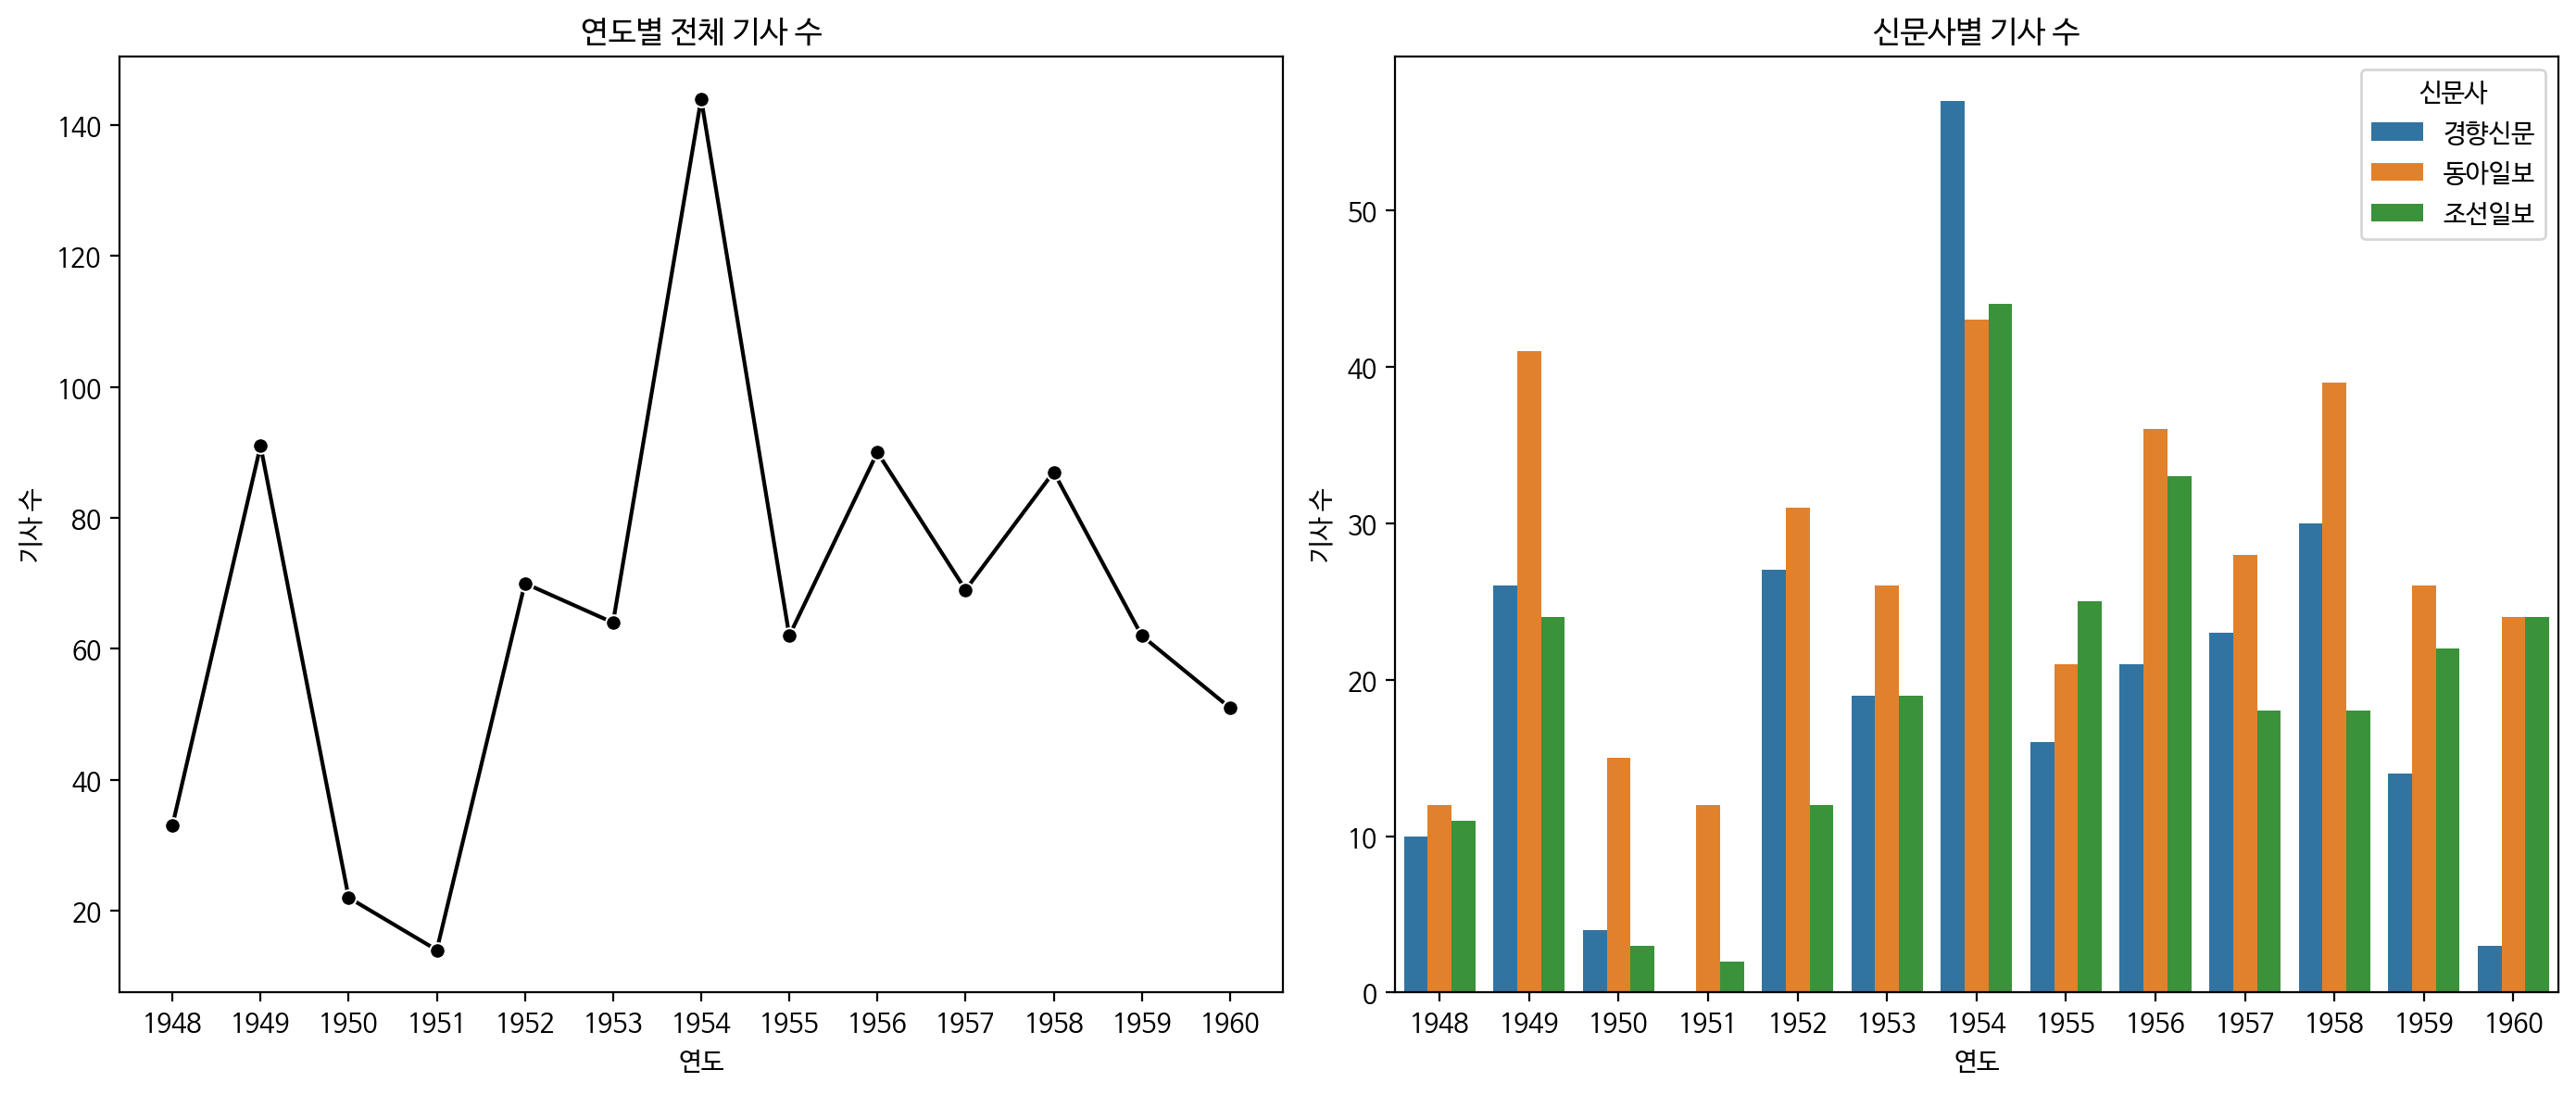

In [ ]:
# 연도별 전체 기사 수 및 신문사별 기사 수 그래프

yearly_data = result_sovereignty_hangul_filtered.groupby('year').sum().reset_index()
bar_data = result_sovereignty_hangul_filtered.groupby(['year', 'company']).size().reset_index(name='counts')

plt.figure(figsize=(14, 6))

# 연도별 전체 기사 수 꺾은선그래프
plt.subplot(1, 2, 1)
yearly_data = result_sovereignty_hangul_filtered['year'].value_counts().sort_index()
sns.lineplot(x=yearly_data.index, y=yearly_data.values, marker='o', color='black')
plt.title('연도별 전체 기사 수')
plt.xlabel('연도')
plt.xticks(range(1948, 1961))
plt.ylabel('기사 수')

# 신문사별 기사 수 막대그래프
plt.subplot(1, 2, 2)
sns.barplot(data=bar_data, x='year', y='counts', hue='company', dodge=True, palette='tab10')
plt.title('신문사별 기사 수')
plt.xlabel('연도')
plt.ylabel('기사 수')
plt.legend(title='신문사')

plt.tight_layout()
plt.show()

In [ ]:
yearly_data # 연도별 전체 기사 수

year
1948     33
1949     91
1950     22
1951     14
1952     70
1953     64
1954    144
1955     62
1956     90
1957     69
1958     87
1959     62
1960     51
Name: count, dtype: int64

In [ ]:
bar_data # 신문사별 기사 수

,year,company,counts
0,1948,경향신문,10
1,1948,동아일보,12
2,1948,조선일보,11
3,1949,경향신문,26
4,1949,동아일보,41
5,1949,조선일보,24
6,1950,경향신문,4
7,1950,동아일보,15
8,1950,조선일보,3
9,1951,동아일보,12


In [ ]:
# 'body_ori' 열에 대하여 특수부호 제거, 여전히 변환되지 않은 한자 변환, 단어에 대한 두음법칙 교정, 다음자(多音字)에 따른 오류 교정, 원활한 형태소 분석을 위한 단어의 통일
for index, row in result_sovereignty_hangul_filtered.iterrows():
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace(r'【.*?】', '', regex=True)
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('(계속)', '')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace(r'(.)々', r'\1\1', regex=True)
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace(r'(.)𠚤', r'\1\1', regex=True)
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('<br>', ' ')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('｜', '')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('□', '')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('…', ' ')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('△', ' ')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('▲', ' ')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('◇', ' ')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('▼', ' ')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('—', ' ') # em dash
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('┉', ' ')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('望', '망')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('𤍠', '열')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('免', '면')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('𧰼', '상')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('𣏌', '기')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('패북', '패배')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('능솔', '능률')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('리익', '이익')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('리용', '이용')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('불정', '부정')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('불족', '부족')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('불동', '부동')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('불재', '부재')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('불당', '부당')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('불득이', '부득이')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('불단', '부단')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('불진', '부진')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('불작위', '부작위')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('불지기수', '부지기수')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('강복', '항복')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('념원', '염원')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('념려', '염려')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('락관', '낙관')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('람용', '남용')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('력량', '역량')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('로동', '노동')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('력사', '역사')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('림시', '임시')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('련합', '연합')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('륙지', '육지')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('륙로', '육로')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('륙군', '육군')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('륙해공', '육해공')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('륜확', '윤곽')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('윤확', '윤곽')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('립장', '입장')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('려권', '여권')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('려단', '여단')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('련락', '연락')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('련석', '연석')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('분렬', '분열')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('선렬', '선열')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('렬사', '열사')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('령토', '영토')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('령유권', '영유권')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('력설', '역설')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('랭정', '냉정')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('랭철', '냉철')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('랭전', '냉전')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('량심', '양심')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('량측', '양측')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('랑독', '낭독')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('령해', '영해')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('령역', '영역')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('령도', '영도')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('령사', '영사')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('령수', '영수')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('립법', '입법')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('류임', '유임')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('리유', '이유')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('랍치', '납치')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('랑비', '낭비')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('략탈', '약탈')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('량민', '양민')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('려행', '여행')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('녀인', '여인')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('뉴대', '유대')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('노례', '노예')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('련방', '연방')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('련결', '연결')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('련맹', '연맹')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('랑비', '낭비')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('량립', '양립')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('량단', '양단')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('량군', '양군')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('례외', '예외')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('례속', '예속')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('록음', '녹음')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('론쟁', '논쟁')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('론평', '논평')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('론난', '논란')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('논난', '논란')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('론문', '논문')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('론고', '논고')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('론급', '논급')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('론리', '논리')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('누루히', '누누이')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('료리', '요리')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('륙법', '육법')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('루적', '누적')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('륜리', '윤리')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('릉가', '능가')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('롱락', '농락')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('롱성', '농성')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('립증', '입증')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('립각', '입각')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('리해', '이해')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('리탈', '이탈')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('립후보', '입후보')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('라열', '나열')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('승락', '승낙')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('량국', '양국')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('량원', '양원')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('리념', '이념')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('리론', '이론')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('리상', '이상')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('리천', '이천')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('린접', '인접')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('련마', '연마')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('론술', '논술')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('곤난', '곤란')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('복흥', '부흥')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('복활', '부활')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('분로', '분노')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('분렬', '분열')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('역역', '역력')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('금구', '김구')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('금규식', '김규식')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('려운형', '여운형')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('리승만', '이승만')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('리박사', '이박사')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('리기붕', '이기붕')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('리완용', '이완용')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('금선태', '김선태')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('금준연', '김준연')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('UN', '유엔')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('유·엔', '유엔')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('드·골', '드골')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('미합중국', '미국')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('아세아', '아시아')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('NATO', '북대동맹')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('냉정전쟁', '냉전')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('멧세지', '메시지')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('독일연방공화국', '서독')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('로켓트', '로켓')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('기빨', '깃발')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('삘딍', '빌딩')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('포쓰당', '포츠담')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('대혁명', '혁명')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('SCAP', '스캡')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('스캐프', '스캡')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('스캐ㅂ', '스캡')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('조곰', '조금')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('하여곰', '하여금')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('계화', '계획')
    result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].str.replace('기계획', '기계화')



result_sovereignty_hangul_filtered

,title_ori,body_ori,publication_date,year,company,title_count,body_count
0,주권회복축하 나마법황『멧세—지』,주권회복축하라마법황『메시지』일구사팔년팔월십오일대한민국정부수립기념축하식에 나마교황청에...,1948-08-16,1948,동아일보,1,2
1,군정도폐막된오늘날 포고령 존속은모순,군정도폐막된오늘날\n포고령\n존속은모순\n새국가면목세워무효선포시급\n 점령군의 안전...,1948-08-21,1948,조선일보,0,5
2,불원자주주권회복확신,불원자주주권회복확신 「무치오」특사래한제일성을발표 지난 이십삼일 오후이시넘어 공로...,1948-08-25,1948,경향신문,1,2
3,이범석총리최초의 시정방침연설요지,이범석총리최초의 시정방침연설요지 주권확립과남북통일 민생문제해결에 산업경제부흥 정부수...,1948-08-29,1948,경향신문,0,3
4,행정이양과 말초적마찰,행정이양과말초적마찰\n 행정이양이 예상외로급속히진행되지못하는때문에말단에서 혹은미초적...,1948-08-31,1948,조선일보,0,5
...,...,...,...,...,...,...,...
854,내란죄로몰린150여명 발췌·사사오입개헌자고발상 (하),내란죄로몰린150여명발췌·사사오입개헌자고발상(하)다시요약하면 금번의거의의로움과 법적...,1960-05-07,1960,동아일보,0,4
855,정국수습에 대한 나의 제언 진정한 민의 파악,정국수습에대한나의제언 진정한민의 파악 빨리주권행사의기회를주자 주 요 섭 잃어버렸던...,1960-05-10,1960,경향신문,0,3
856,혁명뒤에오는것,혁명뒤에오는것\n이광록\n 사·일구의의의\n사·일구사태는 혁명다운혁명이다 정치학자「...,1960-05-12,1960,조선일보,0,9
857,주권침해방지 천거법공청에 각계의견,주권침해방지 천거법공청에각계의견 국회는 심의중인 국회의원선거법안을 십이년의 선거...,1960-05-20,1960,경향신문,1,2


In [ ]:
# 괄호 앞 10글자를 검색하여 괄호 안의 단어와 정확히 일치하는 문자열이 있을 때 괄호와 그 안의 내용을 삭제하는 함수
def remove_parentheses(text):
    pattern = re.compile(r'(.{0,10})\((.*?)\)')
    matches = pattern.findall(text)
    for prefix, inside in matches:
        if inside in prefix:
            text = text.replace(f'({inside})', '')
    return text

result_sovereignty_hangul_filtered['body_ori'] = result_sovereignty_hangul_filtered['body_ori'].apply(remove_parentheses)

In [ ]:
result_sovereignty_hangul_filtered.to_csv("/content/drive/MyDrive/졸업논문 데이터/result_sovereignty_revised.csv")

In [ ]:
result_sovereignty_hangul_filtered = pd.read_csv("/content/drive/MyDrive/졸업논문 데이터/result_sovereignty_revised.csv", index_col = 0)
result_sovereignty_hangul_filtered

,title_ori,body_ori,publication_date,year,company,title_count,body_count
0,주권회복축하 나마법황『멧세—지』,주권회복축하라마법황『메시지』일구사팔년팔월십오일대한민국정부수립기념축하식에 나마교황청에...,1948-08-16,1948,동아일보,1,2
1,군정도폐막된오늘날 포고령 존속은모순,군정도폐막된오늘날\n포고령\n존속은모순\n새국가면목세워무효선포시급\n 점령군의 안전...,1948-08-21,1948,조선일보,0,5
2,불원자주주권회복확신,불원자주주권회복확신 「무치오」특사래한제일성을발표 지난 이십삼일 오후이시넘어 공로...,1948-08-25,1948,경향신문,1,2
3,이범석총리최초의 시정방침연설요지,이범석총리최초의 시정방침연설요지 주권확립과남북통일 민생문제해결에 산업경제부흥 정부수...,1948-08-29,1948,경향신문,0,3
4,행정이양과 말초적마찰,행정이양과말초적마찰\n 행정이양이 예상외로급속히진행되지못하는때문에말단에서 혹은미초적...,1948-08-31,1948,조선일보,0,5
...,...,...,...,...,...,...,...
854,내란죄로몰린150여명 발췌·사사오입개헌자고발상 (하),내란죄로몰린150여명발췌·사사오입개헌자고발상(하)다시요약하면 금번의거의의로움과 법적...,1960-05-07,1960,동아일보,0,4
855,정국수습에 대한 나의 제언 진정한 민의 파악,정국수습에대한나의제언 진정한민의 파악 빨리주권행사의기회를주자 주 요 섭 잃어버렸던...,1960-05-10,1960,경향신문,0,3
856,혁명뒤에오는것,혁명뒤에오는것\n이광록\n 사·일구의의의\n사·일구사태는 혁명다운혁명이다 정치학자「...,1960-05-12,1960,조선일보,0,9
857,주권침해방지 천거법공청에 각계의견,주권침해방지 천거법공청에각계의견 국회는 심의중인 국회의원선거법안을 십이년의 선거...,1960-05-20,1960,경향신문,1,2


In [ ]:
# 형태소가 잘못 분석되지 않도록 당대의 단어들을 사용자 사전에 최대한 추가한 뒤, 형태소 분석을 실시 - 일반 명사와 고유 명사를 위주로 단어를 수집하여 'nouns' 열에 저장
words_to_add = [
    ("자유당", "NNP"),
    ("민주당", "NNP"),
    ("한민당", "NNP"),
    ("자유민주당", "NNP"),
    ("사회민주당", "NNP"),
    ("기독민주당", "NNP"),
    ("민국당", "NNP"),
    ("진보당", "NNP"),
    ("사회당","NNP"),
    ("공산당", "NNP"),
    ("조선공산당", "NNP"),
    ("일본공산당", "NNP"),
    ("국제공산당", "NNP"),
    ("푸로레타리아", "NNP"),
    ("사회민주주의", "NNG"),
    ("미군정", "NNG"),
    ("반도호텔", "NNG"),
    ("주한미군", "NNG"),
    ("여순사건", "NNG"),
    ("삼팔선", "NNG"),
    ("장택상", "NNP"),
    ("장위원장", "NNP"),
    ("조병옥", "NNP"),
    ("조봉암", "NNP"),
    ("리승만", "NNP"),
    ("이승만", "NNP"),
    ("이대통령", "NNP"),
    ('리대통령', "NNP"),
    ("이박사", "NNP"),
    ("리박사", "NNP"),
    ("경무대", "NNG"),
    ("리기붕", "NNP"),
    ("이기붕", "NNP"),
    ("이의장", "NNP"),
    ("장부통령", "NNP"),
    ("민의원", "NNG"),
    ("참의원", "NNG"),
    ("총선거", "NNG"),
    ("민주의원", "NNP"),
    ("국가보안법", "NNP"),
    ("선거법", "NNP"),
    ("지방자치법", "NNP"),
    ("사사오입", "NNG"),
    ("국민투표", "NNG"),
    ("부정선거", "NNG"),
    ("육·이오", "NNP"),
    ("오·이오", "NNP"),
    ("오·일오", "NNP"),
    ("사·일구", "NNP"),
    ("사·이륙", "NNP"),
    ("임시정부", "NNG"),
    ("반공투위", "NNP"),
    ("반공청년단", "NNP"),
    ("서울운동장", "NNP"),
    ("장충단", "NNP"),
    ("테로", "NNG"),
    ("데모", "NNG"),
    ("데몬스트레이숀", "NNG"),
    ("뻐스", "NNG"),
    ("주권", "NNG"),
    ("이양", "NNG"),
    ("주권자", "NNG"),
    ("국민주권", "NNG"),
    ("주권재민", "NNG"),
    ("국무총리", "NNG"),
    ("국무위원", "NNG"),
    ("국회의원", "NNG"),
    ("자주권", "NNG"),
    ("주권선", "NNG"),
    ("주권자강회", "NNP"),
    ("애국단체연합회", "NNP"),
    ("애련", "NNP"),
    ("민련", "NNP"),
    ("송북", "NNG"),
    ("국민주권투위", "NNP"),
    ("주권투위", "NNP"),
    ("국민주권옹호투위", "NNP"),
    ("국민주권옹호투쟁위", "NNP"),
    ("국민주권옹호투쟁위원회", "NNP"),
    ("국민주권투쟁위원회", "NNP"),
    ("주권옹위", "NNP"),
    ("공명선거위원회", "NNP"),
    ("헌법위원회", "NNP"),
    ("헌위", "NNP"),
    ("한미합동경제위원회", "NNP"),
    ("합동경제위원회", "NNP"),
    ("외군", "NNG"),
    ("국제연맹", "NNP"),
    ("만주사변", "NNP"),
    ("육전규칙", "NNP"),
    ("육법", "NNG"),
    ("국제연합", "NNP"),
    ("한국통일부흥위원단", "NNP"),
    ("국련", "NNP"),
    ("유엔", "NNP"),
    ("UN", "NNP"),
    ("유엔한위", "NNP"),
    ("한국위원단", "NNP"),
    ("유엔한국위원단", "NNP"),
    ("임시위원단", "NNP"),
    ("신한국위원단", "NNP"),
    ("유엔국제법위원회", "NNP"),
    ("운크라", "NNP"),
    ("평화선", "NNP"),
    ("팟쇼", "NNG"),
    ("마샬", "NNP"),
    ("서독", "NNP"),
    ("동독", "NNP"),
    ("프랑스", "NNP"),
    ("인도네시아", "NNP"),
    ("인도네지아", "NNP"),
    ("모록코", "NNP"),
    ("화란", "NNP"),
    ("암스테르담", "NNP"),
    ("암스테로담", "NNP"),
    ("홀랜드", "NNP"),
    ("해아", "NNP"),
    ("싸르", "NNP"),
    ("파란", "NNP"),
    ("와르샤와", "NNP"),
    ("풀랜드", "NNP"),
    ("영연방", "NNG"),
    ("연합국", "NNG"),
    ("구라파", "NNG"),
    ("NATO", "NNP"),
    ("맥선", "NNP"),
    ("맥라인", "NNP"),
    ("콤뮤니케", "NNG"),
    ("큼뮤니케", "NNG"),
    ("유고스라비아", "NNP"),
    ("유고슬라비아", "NNP"),
    ("이태리", "NNP"),
    ("이탈리아", "NNP"),
    ("에치오피아", "NNP"),
    ("북대동맹", "NNP"),
    ("북대맹", "NNP"),
    ("북대서양동맹", "NNP"),
    ("서구라파동맹", "NNP"),
    ("국민정부", "NNP"),
    ("자유중국", "NNP"),
    ("서구연합", "NNP"),
    ("카나다", "NNP"),
    ("가내타", "NNP"),
    ("캄보쟈", "NNP"),
    ("포쓰담", "NNP"),
    ("제네바", "NNP"),
    ("정치회담", "NNP"),
    ("휴전회담", "NNP"),
    ("불란서", "NNP"),
    ("나포레온", "NNP"),
    ("망데스·프랑스", "NNP"),
    ("애급", "NNP"),
    ("스에즈", "NNP"),
    ("낙위", "NNP"),
    ("백이의", "NNP"),
    ("비국", "NNP"),
    ("포도아", "NNP"),
    ("서전", "NNP"),
    ("희랍", "NNP"),
    ("이락", "NNP"),
    ("혁명주권위원회", "NNP"),
    ("마카오", "NNP"),
    ("토이기", "NNP"),
    ("비율빈", "NNP"),
    ("외몽고", "NNP"),
    ("항가리", "NNP"),
    ("헝커리", "NNP"),
    ("홍아리", "NNP"),
    ("흉아리", "NNP"),
    ("아라사", "NNP"),
    ("노서아", "NNP"),
    ("쏘련", "NNP"),
    ("월남", "NNP"),
    ("스타린", "NNP"),
    ("고물카", "NNP"),
    ("서반아", "NNP"),
    ("오지리", "NNP"),
    ("신서란", "NNP"),
    ("아르젠친", "NNP"),
    ("튜니시아", "NNP"),
    ("싸우디아라비아", "NNP"),
    ("코스타리카", "NNP"),
    ('첵코스로바키아', "NNP"),
    ("우라디보스토크", "NNP"),
    ("라틴아메리카", "NNP"),
    ("구주연방", "NNP"),
    ("인도지나", "NNP"),
    ("아일란드", "NNP"),
    ("정말", "NNP"),
    ("코민포름", "NNP"),
    ("콤민포름", "NNP"),
    ("태평양동맹", "NNP"),
    ("미소공동위원회", 'NNP'),
    ("미소공위", "NNP"),
    ("미소", "NNP"),
    ("미영", "NNP"),
    ("미영불", "NNP"),
    ("미영중불", "NNP"),
    ("미영불중소", "NNP"),
    ("미영소", "NNP"),
    ("미영불독", "NNP"),
    ("영불독", "NNP"),
    ("불독", "NNP"),
    ("화인", "NNP")

]
for word, pos in words_to_add:
    kiwi.add_user_word(word, pos)

def extract_nouns(text):
    tokens = kiwi.tokenize(text, normalize_coda = True, match_options=Match.ALL | Match.JOIN_NOUN_PREFIX | Match.JOIN_NOUN_SUFFIX)
    # 명사의 경우 접두사와 접미사를 결합하도록 조정 (https://github.com/bab2min/kiwipiepy/discussions/163)
    # 일반 명사(NNG)와 고유 명사(NNP)만 필터링
    nouns = [token.form for token in tokens if token.tag in ('NNG', 'NNP')]
    return nouns


result_sovereignty_hangul_filtered['nouns'] = result_sovereignty_hangul_filtered['body_ori'].apply(extract_nouns)
result_sovereignty_hangul_filtered

,title_ori,body_ori,publication_date,year,company,title_count,body_count,nouns
0,주권회복축하 나마법황『멧세—지』,주권회복축하라마법황『메시지』일구사팔년팔월십오일대한민국정부수립기념축하식에 나마교황청에...,1948-08-16,1948,동아일보,1,2,"[주권, 회복, 축하, 마법, 황, 메시지, 일, 대한민국, 정부, 수립, 기념, ..."
1,군정도폐막된오늘날 포고령 존속은모순,군정도폐막된오늘날\n포고령\n존속은모순\n새국가면목세워무효선포시급\n 점령군의 안전...,1948-08-21,1948,조선일보,0,5,"[군정, 폐막, 오늘날, 포고령, 존속, 모순, 국가, 면목, 무효, 선포, 시급,..."
2,불원자주주권회복확신,불원자주주권회복확신 「무치오」특사래한제일성을발표 지난 이십삼일 오후이시넘어 공로...,1948-08-25,1948,경향신문,1,2,"[불, 원자, 주주권, 회복, 확신, 무치오, 특사래, 제일성, 발표, 오후, 공로..."
3,이범석총리최초의 시정방침연설요지,이범석총리최초의 시정방침연설요지 주권확립과남북통일 민생문제해결에 산업경제부흥 정부수...,1948-08-29,1948,경향신문,0,3,"[이범석, 총리, 최초, 시정, 방침, 연설, 요지, 주권, 확립, 남북통일, 민생..."
4,행정이양과 말초적마찰,행정이양과말초적마찰\n 행정이양이 예상외로급속히진행되지못하는때문에말단에서 혹은미초적...,1948-08-31,1948,조선일보,0,5,"[행정, 이양, 말초적, 마찰, 행정, 이양, 예상, 진행, 말단, 미, 문제, 종..."
...,...,...,...,...,...,...,...,...
854,내란죄로몰린150여명 발췌·사사오입개헌자고발상 (하),내란죄로몰린150여명발췌·사사오입개헌자고발상(하)다시요약하면 금번의거의의로움과 법적...,1960-05-07,1960,동아일보,0,4,"[내란죄, 발췌, 사사오입, 개헌, 발상, 하, 요약, 금번, 의거, 법적, 이차,..."
855,정국수습에 대한 나의 제언 진정한 민의 파악,정국수습에대한나의제언 진정한민의 파악 빨리주권행사의기회를주자 주 요 섭 잃어버렸던...,1960-05-10,1960,경향신문,0,3,"[정국, 수습, 제언, 민의, 파악, 주권, 행사, 기회, 주, 섭, 주권, 청소년..."
856,혁명뒤에오는것,혁명뒤에오는것\n이광록\n 사·일구의의의\n사·일구사태는 혁명다운혁명이다 정치학자「...,1960-05-12,1960,조선일보,0,9,"[혁명, 뒤, 광, 록, 사·일구, 의의, 사·일구, 사태, 혁명, 혁명, 정치, ..."
857,주권침해방지 천거법공청에 각계의견,주권침해방지 천거법공청에각계의견 국회는 심의중인 국회의원선거법안을 십이년의 선거...,1960-05-20,1960,경향신문,1,2,"[주권, 침해, 방지, 천거, 법, 공, 청, 각계, 의견, 국회, 심의, 국회, ..."


In [ ]:
result_sovereignty_hangul_filtered.to_csv("/content/drive/MyDrive/졸업논문 데이터/result_sovereignty_with_nouns.csv")

In [ ]:
result_sovereignty_hangul_filtered = pd.read_csv("/content/drive/MyDrive/졸업논문 데이터/result_sovereignty_with_nouns.csv", index_col = 0, converters={"nouns":literal_eval,"nouns":literal_eval})
result_sovereignty_hangul_filtered

,title_ori,body_ori,publication_date,year,company,title_count,body_count,nouns
0,주권회복축하 나마법황『멧세—지』,주권회복축하라마법황『메시지』일구사팔년팔월십오일대한민국정부수립기념축하식에 나마교황청에...,1948-08-16,1948,동아일보,1,2,"[주권, 회복, 축하, 마법, 황, 메시지, 일, 대한민국, 정부, 수립, 기념, ..."
1,군정도폐막된오늘날 포고령 존속은모순,군정도폐막된오늘날\n포고령\n존속은모순\n새국가면목세워무효선포시급\n 점령군의 안전...,1948-08-21,1948,조선일보,0,5,"[군정, 폐막, 오늘날, 포고령, 존속, 모순, 국가, 면목, 무효, 선포, 시급,..."
2,불원자주주권회복확신,불원자주주권회복확신 「무치오」특사래한제일성을발표 지난 이십삼일 오후이시넘어 공로...,1948-08-25,1948,경향신문,1,2,"[불, 원자, 주주권, 회복, 확신, 무치오, 특사래, 제일성, 발표, 오후, 공로..."
3,이범석총리최초의 시정방침연설요지,이범석총리최초의 시정방침연설요지 주권확립과남북통일 민생문제해결에 산업경제부흥 정부수...,1948-08-29,1948,경향신문,0,3,"[이범석, 총리, 최초, 시정, 방침, 연설, 요지, 주권, 확립, 남북통일, 민생..."
4,행정이양과 말초적마찰,행정이양과말초적마찰\n 행정이양이 예상외로급속히진행되지못하는때문에말단에서 혹은미초적...,1948-08-31,1948,조선일보,0,5,"[행정, 이양, 말초적, 마찰, 행정, 이양, 예상, 진행, 말단, 미, 문제, 종..."
...,...,...,...,...,...,...,...,...
854,내란죄로몰린150여명 발췌·사사오입개헌자고발상 (하),내란죄로몰린150여명발췌·사사오입개헌자고발상(하)다시요약하면 금번의거의의로움과 법적...,1960-05-07,1960,동아일보,0,4,"[내란죄, 발췌, 사사오입, 개헌, 발상, 하, 요약, 금번, 의거, 법적, 이차,..."
855,정국수습에 대한 나의 제언 진정한 민의 파악,정국수습에대한나의제언 진정한민의 파악 빨리주권행사의기회를주자 주 요 섭 잃어버렸던...,1960-05-10,1960,경향신문,0,3,"[정국, 수습, 제언, 민의, 파악, 주권, 행사, 기회, 주, 섭, 주권, 청소년..."
856,혁명뒤에오는것,혁명뒤에오는것\n이광록\n 사·일구의의의\n사·일구사태는 혁명다운혁명이다 정치학자「...,1960-05-12,1960,조선일보,0,9,"[혁명, 뒤, 광, 록, 사·일구, 의의, 사·일구, 사태, 혁명, 혁명, 정치, ..."
857,주권침해방지 천거법공청에 각계의견,주권침해방지 천거법공청에각계의견 국회는 심의중인 국회의원선거법안을 십이년의 선거...,1960-05-20,1960,경향신문,1,2,"[주권, 침해, 방지, 천거, 법, 공, 청, 각계, 의견, 국회, 심의, 국회, ..."


In [ ]:
# 불용어 제거 함수
def remove_words(word_list, target_words):
    return [word for word in word_list if word not in target_words]

target_words = ['때', '급', '점', '후', '앞', '동', '하', '끝', '담', '다음', '생각', '동시', '경우', '필요', '운운', '마찬가지', '여하', '여좌']
result_sovereignty_hangul_filtered['nouns'] = result_sovereignty_hangul_filtered['nouns'].apply(remove_words, target_words=target_words)

In [ ]:
# 모든 단어를 하나의 리스트로 합치기
all_words = list(chain.from_iterable(result_sovereignty_hangul_filtered['nouns']))

# 단어의 끝에 '측'이 붙어있는 단어들만 추출하여 유니크한 목록 생성
plural_words = set(word for word in all_words if word.endswith('측'))

# 유니크한 단어 목록 출력
print("Unique words ending with '측':")
print(plural_words)

Unique words ending with '측':
{'추측', '억측', '원측', '해괴망측', '서방측', '공산측', '화측', '소측', '서독측', '의미측', '서구측', '공화국측', '정부측', '측', '일본인측', '일본측', '야측', '자국측', '의원측', '예측', '회원측', '국가측', '민주당측', '모측', '연합국측', '관측', '야당측', '양측', '자유당측'}


In [ ]:
# 접미사 '들' 제거
def remove_suffix(word_list, suffix='들'):
    return [word[:-len(suffix)] if word.endswith(suffix) else word for word in word_list]

result_sovereignty_hangul_filtered['nouns'] = result_sovereignty_hangul_filtered['nouns'].apply(remove_suffix)

In [ ]:
# 접미사 '적' 제거
def remove_suffix(word_list, suffix='적'):
    return [word[:-len(suffix)] if word.endswith(suffix) else word for word in word_list]

result_sovereignty_hangul_filtered['nouns'] = result_sovereignty_hangul_filtered['nouns'].apply(remove_suffix)

In [ ]:
result_sovereignty_hangul_filtered

,title_ori,body_ori,publication_date,year,company,title_count,body_count,nouns
0,주권회복축하 나마법황『멧세—지』,주권회복축하라마법황『메시지』일구사팔년팔월십오일대한민국정부수립기념축하식에 나마교황청에...,1948-08-16,1948,동아일보,1,2,"[주권, 회복, 축하, 마법, 황, 메시지, 일, 대한민국, 정부, 수립, 기념, ..."
1,군정도폐막된오늘날 포고령 존속은모순,군정도폐막된오늘날\n포고령\n존속은모순\n새국가면목세워무효선포시급\n 점령군의 안전...,1948-08-21,1948,조선일보,0,5,"[군정, 폐막, 오늘날, 포고령, 존속, 모순, 국가, 면목, 무효, 선포, 시급,..."
2,불원자주주권회복확신,불원자주주권회복확신 「무치오」특사래한제일성을발표 지난 이십삼일 오후이시넘어 공로...,1948-08-25,1948,경향신문,1,2,"[불, 원자, 주주권, 회복, 확신, 무치오, 특사래, 제일성, 발표, 오후, 공로..."
3,이범석총리최초의 시정방침연설요지,이범석총리최초의 시정방침연설요지 주권확립과남북통일 민생문제해결에 산업경제부흥 정부수...,1948-08-29,1948,경향신문,0,3,"[이범석, 총리, 최초, 시정, 방침, 연설, 요지, 주권, 확립, 남북통일, 민생..."
4,행정이양과 말초적마찰,행정이양과말초적마찰\n 행정이양이 예상외로급속히진행되지못하는때문에말단에서 혹은미초적...,1948-08-31,1948,조선일보,0,5,"[행정, 이양, 말초, 마찰, 행정, 이양, 예상, 진행, 말단, 미, 문제, 종래..."
...,...,...,...,...,...,...,...,...
854,내란죄로몰린150여명 발췌·사사오입개헌자고발상 (하),내란죄로몰린150여명발췌·사사오입개헌자고발상(하)다시요약하면 금번의거의의로움과 법적...,1960-05-07,1960,동아일보,0,4,"[내란죄, 발췌, 사사오입, 개헌, 발상, 요약, 금번, 의거, 법, 이차, 쿠데타..."
855,정국수습에 대한 나의 제언 진정한 민의 파악,정국수습에대한나의제언 진정한민의 파악 빨리주권행사의기회를주자 주 요 섭 잃어버렸던...,1960-05-10,1960,경향신문,0,3,"[정국, 수습, 제언, 민의, 파악, 주권, 행사, 기회, 주, 섭, 주권, 청소년..."
856,혁명뒤에오는것,혁명뒤에오는것\n이광록\n 사·일구의의의\n사·일구사태는 혁명다운혁명이다 정치학자「...,1960-05-12,1960,조선일보,0,9,"[혁명, 뒤, 광, 록, 사·일구, 의의, 사·일구, 사태, 혁명, 혁명, 정치, ..."
857,주권침해방지 천거법공청에 각계의견,주권침해방지 천거법공청에각계의견 국회는 심의중인 국회의원선거법안을 십이년의 선거...,1960-05-20,1960,경향신문,1,2,"[주권, 침해, 방지, 천거, 법, 공, 청, 각계, 의견, 국회, 심의, 국회, ..."


In [ ]:
result_sovereignty_hangul_filtered.to_csv("/content/drive/MyDrive/졸업논문 데이터/result_sovereignty_with_nouns_revised.csv")

# Data Cleaning 3

In [ ]:
# Data Cleaning 2를 통해 생성한 csv 파일을 직접 검토하여, 분석 오류 수정, 용어의 통일 혹은 분리, 불용어 제거의 과정을 거쳐 직접 정돈
# 직접 정돈한 파일(sovereignty_nouns_checked_final.csv)의 'nouns' 열에 있는 각각의 list에 오류가 있는지 check하고, 파일을 load

def find_error_indices_in_csv(file_path, encoding='cp949', column_to_convert='nouns'):
    error_indices = []

    # Read the CSV file without converters first
    df = pd.read_csv(file_path, index_col=0, encoding=encoding)

    for index, row in df.iterrows():
        try:
            # Attempt to convert the specified column using literal_eval
            literal_eval(row[column_to_convert])
        except Exception:
            error_indices.append(index)

    return error_indices

file_path = "/content/drive/MyDrive/졸업논문 데이터/sovereignty_nouns_checked_final.csv"
error_indices = find_error_indices_in_csv(file_path)

if error_indices:
    print("Errors found in the following rows:")
    for idx in error_indices:
        print(f"Row index {idx} caused an error during conversion.")
else:
    print("CSV file read successfully with no errors.")


CSV file read successfully with no errors.


In [ ]:
sovereignty_nouns_final = pd.read_csv("/content/drive/MyDrive/졸업논문 데이터/sovereignty_nouns_checked_final.csv", index_col = 0, encoding = 'cp949', converters={"nouns":literal_eval,"nouns":literal_eval})
sovereignty_nouns_final

,title_ori,body_ori,publication_date,year,company,title_count,body_count,nouns
0,주권회복축하 나마법황『멧세?지』,주권회복축하라마법황『메시지』일구사팔년팔월십오일대한민국정부수립기념축하식에 나마교황청에...,1948-08-16,1948,동아일보,1,2,"[주권, 회복, 축하, 로마, 교황, 메시지, 대한민국, 정부, 수립, 기념, 축하..."
1,군정도폐막된오늘날 포고령 존속은모순,군정도폐막된오늘날\n포고령\n존속은모순\n새국가면목세워무효선포시급\n 점령군의 안전...,1948-08-21,1948,조선일보,0,5,"[군정, 폐막, 포고령, 존속, 모순, 국가, 면목, 무효, 선포, 시급, 점령군,..."
2,불원자주주권회복확신,불원자주주권회복확신 「무치오」특사래한제일성을발표 지난 이십삼일 오후이시넘어 공로...,1948-08-25,1948,경향신문,1,2,"[자주, 주권, 회복, 확신, 무치오, 특사, 내한, 제일성, 공로, 내한, 무치오..."
3,이범석총리최초의 시정방침연설요지,이범석총리최초의 시정방침연설요지 주권확립과남북통일 민생문제해결에 산업경제부흥 정부수...,1948-08-29,1948,경향신문,0,3,"[이범석, 총리, 최초, 시정, 방침, 연설, 주권, 확립, 남북, 통일, 민생, ..."
4,행정이양과 말초적마찰,행정이양과말초적마찰\n 행정이양이 예상외로급속히진행되지못하는때문에말단에서 혹은미초적...,1948-08-31,1948,조선일보,0,5,"[행정, 이양, 말초, 마찰, 행정, 이양, 예상, 진행, 말단, 군정, 기구, 직..."
...,...,...,...,...,...,...,...,...
854,내란죄로몰린150여명 발췌·사사오입개헌자고발상 (하),내란죄로몰린150여명발췌·사사오입개헌자고발상(하)다시요약하면 금번의거의의로움과 법적...,1960-05-07,1960,동아일보,0,4,"[내란죄, 발췌, 사사오입, 개헌, 발상, 요약, 의거, 법, 이차, 쿠데타, 정권..."
855,정국수습에 대한 나의 제언 진정한 민의 파악,정국수습에대한나의제언 진정한민의 파악 빨리주권행사의기회를주자 주 요 섭 잃어버렸던...,1960-05-10,1960,경향신문,0,3,"[정국, 수습, 제언, 민의, 파악, 주권, 행사, 기회, 주권, 청소년, 시민, ..."
856,혁명뒤에오는것,혁명뒤에오는것\n이광록\n 사·일구의의의\n사·일구사태는 혁명다운혁명이다 정치학자「...,1960-05-12,1960,조선일보,0,9,"[혁명, 사·일구, 의의, 사·일구, 사태, 혁명, 혁명, 정치, 학자, 겟, 텔,..."
857,주권침해방지 천거법공청에 각계의견,주권침해방지 천거법공청에각계의견 국회는 심의중인 국회의원선거법안을 십이년의 선거...,1960-05-20,1960,경향신문,1,2,"[주권, 침해, 방지, 선거법, 공청, 각계, 의견, 국회, 심의, 국회, 의원, ..."


In [ ]:
# 모든 단어를 하나의 리스트로 합치기
all_words = list(chain.from_iterable(sovereignty_nouns_final['nouns']))

# 1음절 단어의 유니크한 목록 생성
one_words = set(word for word in all_words if len(word) == 1)

# 유니크한 단어 목록 출력
print("One letter words: ")
print(one_words)

One letter words: 
{'뇌', '관', '왕', '벌', '구', '년', '대', '펜', '료', '미', '민', '횡', '쇠', '밀', '쿠', '분', '가', '맡', '댁', '남', '어', '적', '복', '묵', '외', '떡', '턱', '옆', '만', '람', '차', '벽', '슈', '낯', '굴', '꿈', '난', '강', '넋', '추', '짝', '학', '치', '곳', '고', '룩', '제', '뿌', '뉴', '교', '로', '항', '콩', '훈', '젓', '최', '런', '준', '첩', '밥', '겹', '거', '독', '욕', '멱', '흙', '함', '헌', '두', '파', '면', '반', '톱', '오', '흑', '헛', '임', '검', '깁', '겊', '데', '테', '꼴', '횝', '쟁', '책', '종', '끽', '3', '씽', '덧', '상', '골', '앎', '레', '퇴', '솔', '화', '확', '곹', '럭', '묘', '랜', '닭', '혼', '충', '말', '영', '랄', '처', '음', '떼', '낫', '꾀', '곰', '불', '식', '등', '흉', '엠', '법', '린', '춘', '재', '괘', '림', '콤', '매', '저', '역', '갓', '총', '기', '섬', '틱', '열', '탑', '조', '초', '깃', '뭉', '립', '능', '출', '잭', '웃', '빠', '맷', '페', '체', '품', '뻐', '환', '력', '맥', '병', '염', '물', '궁', '휠', '빈', '디', '황', '맨', '명', '휴', '되', '압', '띤', '작', '다', '채', '원', '협', '칸', '발', '칙', '루', '웹', '곽', '주', '쌍', '언', '살', '뜻', '각', '땀', '태', '랏', '토', '즙', '잡', '콘', '녀', '죽', '판', 

In [ ]:
# 법, 표, 군을 제외한 나머지 1음절 단어 모두 제거
specific_words = {'법', '표', '군'}
words_to_remove = one_words - specific_words

# 특정 단어들을 제외한 나머지 단어를 제거하는 함수 정의
def remove_specific_words(lst, words_to_remove):
    return [word for word in lst if word not in words_to_remove]

# 데이터프레임의 각 리스트에서 특정 단어들을 제외한 나머지 단어를 제거
sovereignty_nouns_final['nouns'] = sovereignty_nouns_final['nouns'].apply(lambda lst: remove_specific_words(lst, words_to_remove))
sovereignty_nouns_final

,title_ori,body_ori,publication_date,year,company,title_count,body_count,nouns
0,주권회복축하 나마법황『멧세?지』,주권회복축하라마법황『메시지』일구사팔년팔월십오일대한민국정부수립기념축하식에 나마교황청에...,1948-08-16,1948,동아일보,1,2,"[주권, 회복, 축하, 로마, 교황, 메시지, 대한민국, 정부, 수립, 기념, 축하..."
1,군정도폐막된오늘날 포고령 존속은모순,군정도폐막된오늘날\n포고령\n존속은모순\n새국가면목세워무효선포시급\n 점령군의 안전...,1948-08-21,1948,조선일보,0,5,"[군정, 폐막, 포고령, 존속, 모순, 국가, 면목, 무효, 선포, 시급, 점령군,..."
2,불원자주주권회복확신,불원자주주권회복확신 「무치오」특사래한제일성을발표 지난 이십삼일 오후이시넘어 공로...,1948-08-25,1948,경향신문,1,2,"[자주, 주권, 회복, 확신, 무치오, 특사, 내한, 제일성, 공로, 내한, 무치오..."
3,이범석총리최초의 시정방침연설요지,이범석총리최초의 시정방침연설요지 주권확립과남북통일 민생문제해결에 산업경제부흥 정부수...,1948-08-29,1948,경향신문,0,3,"[이범석, 총리, 최초, 시정, 방침, 연설, 주권, 확립, 남북, 통일, 민생, ..."
4,행정이양과 말초적마찰,행정이양과말초적마찰\n 행정이양이 예상외로급속히진행되지못하는때문에말단에서 혹은미초적...,1948-08-31,1948,조선일보,0,5,"[행정, 이양, 말초, 마찰, 행정, 이양, 예상, 진행, 말단, 군정, 기구, 직..."
...,...,...,...,...,...,...,...,...
854,내란죄로몰린150여명 발췌·사사오입개헌자고발상 (하),내란죄로몰린150여명발췌·사사오입개헌자고발상(하)다시요약하면 금번의거의의로움과 법적...,1960-05-07,1960,동아일보,0,4,"[내란죄, 발췌, 사사오입, 개헌, 발상, 요약, 의거, 법, 이차, 쿠데타, 정권..."
855,정국수습에 대한 나의 제언 진정한 민의 파악,정국수습에대한나의제언 진정한민의 파악 빨리주권행사의기회를주자 주 요 섭 잃어버렸던...,1960-05-10,1960,경향신문,0,3,"[정국, 수습, 제언, 민의, 파악, 주권, 행사, 기회, 주권, 청소년, 시민, ..."
856,혁명뒤에오는것,혁명뒤에오는것\n이광록\n 사·일구의의의\n사·일구사태는 혁명다운혁명이다 정치학자「...,1960-05-12,1960,조선일보,0,9,"[혁명, 사·일구, 의의, 사·일구, 사태, 혁명, 혁명, 정치, 학자, 혁명, 정..."
857,주권침해방지 천거법공청에 각계의견,주권침해방지 천거법공청에각계의견 국회는 심의중인 국회의원선거법안을 십이년의 선거...,1960-05-20,1960,경향신문,1,2,"[주권, 침해, 방지, 선거법, 공청, 각계, 의견, 국회, 심의, 국회, 의원, ..."


# Topic Modeling

## 데이터 준비

In [ ]:
def list_to_pipe_separated(lst):
    return '|'.join(lst)

# 'nouns_list' 열을 새로 생성하여 적용
sovereignty_nouns_final['nouns_list'] = sovereignty_nouns_final['nouns'].apply(list_to_pipe_separated)

sovereignty_nouns_final

,title_ori,body_ori,publication_date,year,company,title_count,body_count,nouns,nouns_list
0,주권회복축하 나마법황『멧세?지』,주권회복축하라마법황『메시지』일구사팔년팔월십오일대한민국정부수립기념축하식에 나마교황청에...,1948-08-16,1948,동아일보,1,2,"[주권, 회복, 축하, 로마, 교황, 메시지, 대한민국, 정부, 수립, 기념, 축하...",주권|회복|축하|로마|교황|메시지|대한민국|정부|수립|기념|축하식|교황청|한국|주재...
1,군정도폐막된오늘날 포고령 존속은모순,군정도폐막된오늘날\n포고령\n존속은모순\n새국가면목세워무효선포시급\n 점령군의 안전...,1948-08-21,1948,조선일보,0,5,"[군정, 폐막, 포고령, 존속, 모순, 국가, 면목, 무효, 선포, 시급, 점령군,...",군정|폐막|포고령|존속|모순|국가|면목|무효|선포|시급|점령군|안전|도모|공포|포고...
2,불원자주주권회복확신,불원자주주권회복확신 「무치오」특사래한제일성을발표 지난 이십삼일 오후이시넘어 공로...,1948-08-25,1948,경향신문,1,2,"[자주, 주권, 회복, 확신, 무치오, 특사, 내한, 제일성, 공로, 내한, 무치오...",자주|주권|회복|확신|무치오|특사|내한|제일성|공로|내한|무치오|특사|신문|기자|회...
3,이범석총리최초의 시정방침연설요지,이범석총리최초의 시정방침연설요지 주권확립과남북통일 민생문제해결에 산업경제부흥 정부수...,1948-08-29,1948,경향신문,0,3,"[이범석, 총리, 최초, 시정, 방침, 연설, 주권, 확립, 남북, 통일, 민생, ...",이범석|총리|최초|시정|방침|연설|주권|확립|남북|통일|민생|해결|산업|경제|부흥|...
4,행정이양과 말초적마찰,행정이양과말초적마찰\n 행정이양이 예상외로급속히진행되지못하는때문에말단에서 혹은미초적...,1948-08-31,1948,조선일보,0,5,"[행정, 이양, 말초, 마찰, 행정, 이양, 예상, 진행, 말단, 군정, 기구, 직...",행정|이양|말초|마찰|행정|이양|예상|진행|말단|군정|기구|직원|정부|대립|감정|얼...
...,...,...,...,...,...,...,...,...,...
854,내란죄로몰린150여명 발췌·사사오입개헌자고발상 (하),내란죄로몰린150여명발췌·사사오입개헌자고발상(하)다시요약하면 금번의거의의로움과 법적...,1960-05-07,1960,동아일보,0,4,"[내란죄, 발췌, 사사오입, 개헌, 발상, 요약, 의거, 법, 이차, 쿠데타, 정권...",내란죄|발췌|사사오입|개헌|발상|요약|의거|법|이차|쿠데타|정권|이승만|박사|정부|...
855,정국수습에 대한 나의 제언 진정한 민의 파악,정국수습에대한나의제언 진정한민의 파악 빨리주권행사의기회를주자 주 요 섭 잃어버렸던...,1960-05-10,1960,경향신문,0,3,"[정국, 수습, 제언, 민의, 파악, 주권, 행사, 기회, 주권, 청소년, 시민, ...",정국|수습|제언|민의|파악|주권|행사|기회|주권|청소년|시민|보답|모독|사견|피력|...
856,혁명뒤에오는것,혁명뒤에오는것\n이광록\n 사·일구의의의\n사·일구사태는 혁명다운혁명이다 정치학자「...,1960-05-12,1960,조선일보,0,9,"[혁명, 사·일구, 의의, 사·일구, 사태, 혁명, 혁명, 정치, 학자, 혁명, 정...",혁명|사·일구|의의|사·일구|사태|혁명|혁명|정치|학자|혁명|정의|법률|주권|부정|...
857,주권침해방지 천거법공청에 각계의견,주권침해방지 천거법공청에각계의견 국회는 심의중인 국회의원선거법안을 십이년의 선거...,1960-05-20,1960,경향신문,1,2,"[주권, 침해, 방지, 선거법, 공청, 각계, 의견, 국회, 심의, 국회, 의원, ...",주권|침해|방지|선거법|공청|각계|의견|국회|심의|국회|의원|선거|법안|선거|사상|...


In [ ]:
sovereignty_topic = sovereignty_nouns_final[['nouns_list', 'year']]
sovereignty_topic['doc_no'] = sovereignty_topic.index
sovereignty_topic = sovereignty_topic[['doc_no', 'nouns_list', 'year']]
sovereignty_topic # 토픽 모델링에 투입되는 문서: 859개

<ipython-input-12-4cb2a820dff5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sovereignty_topic['doc_no'] = sovereignty_topic.index


,doc_no,nouns_list,year
0,0,주권|회복|축하|로마|교황|메시지|대한민국|정부|수립|기념|축하식|교황청|한국|주재...,1948
1,1,군정|폐막|포고령|존속|모순|국가|면목|무효|선포|시급|점령군|안전|도모|공포|포고...,1948
2,2,자주|주권|회복|확신|무치오|특사|내한|제일성|공로|내한|무치오|특사|신문|기자|회...,1948
3,3,이범석|총리|최초|시정|방침|연설|주권|확립|남북|통일|민생|해결|산업|경제|부흥|...,1948
4,4,행정|이양|말초|마찰|행정|이양|예상|진행|말단|군정|기구|직원|정부|대립|감정|얼...,1948
...,...,...,...
854,854,내란죄|발췌|사사오입|개헌|발상|요약|의거|법|이차|쿠데타|정권|이승만|박사|정부|...,1960
855,855,정국|수습|제언|민의|파악|주권|행사|기회|주권|청소년|시민|보답|모독|사견|피력|...,1960
856,856,혁명|사·일구|의의|사·일구|사태|혁명|혁명|정치|학자|혁명|정의|법률|주권|부정|...,1960
857,857,주권|침해|방지|선거법|공청|각계|의견|국회|심의|국회|의원|선거|법안|선거|사상|...,1960


## Perplexity

Running LDA...
Model perplexity (Log-likelihood)


<ipython-input-12-d17890b19647>:13: RuntimeWarning: `words` should be an iterable of str.
  mdl.add_doc(i)
<ipython-input-12-d17890b19647>:15: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  mdl.train(0)
<ipython-input-12-d17890b19647>:18: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  mdl.train(10)


5 topics : -5.068713121928577
6 topics : -5.08928031143329
7 topics : -5.1826479083765555
8 topics : -5.247316168143366
9 topics : -5.244720941530853
10 topics : -5.370476063953811
11 topics : -5.369502891653279
12 topics : -5.387834380845962
13 topics : -5.397059630461935
14 topics : -5.429599204696084
15 topics : -5.480422356209069
16 topics : -5.507580081427228
17 topics : -5.486900379589623
18 topics : -5.514744635001977
19 topics : -5.566971835042541
20 topics : -5.573765855917034
21 topics : -5.586093163278363
22 topics : -5.612579910016518
23 topics : -5.625464845282879
24 topics : -5.626010293721118
25 topics : -5.645541404412339
26 topics : -5.673554407256937
27 topics : -5.665297730432228
28 topics : -5.695765417285179
29 topics : -5.696786906548188
30 topics : -5.691925882301175


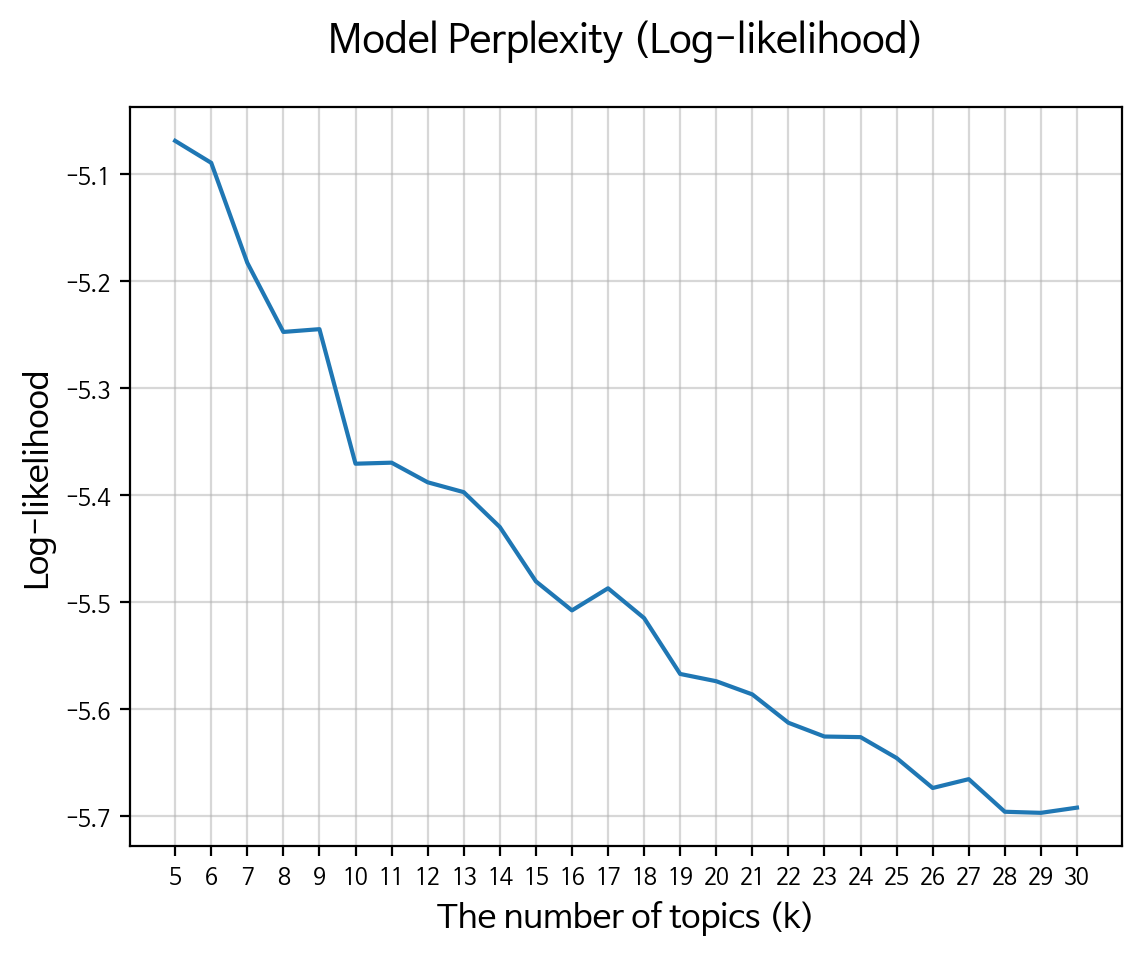

In [ ]:
ntopics = []
loglikelihood = []

print('Running LDA...')
print("Model perplexity (Log-likelihood)")

windowL = sovereignty_topic['nouns_list'].to_list() ##############################

for k in range(5, 31):
    mdl = tp.LDAModel(k=k, seed=100)

    for i in windowL:
        mdl.add_doc(i)
    mdl.burn_in = 100
    mdl.train(0)

    for i in range(0, 1000, 20):
        mdl.train(10)

    ntopics.append(k)
    loglikelihood.append(mdl.ll_per_word)
    print(k,'topics :', mdl.ll_per_word)

plt.plot(ntopics, loglikelihood)
plt.xlabel('The number of topics (k)', fontsize=12)
plt.ylabel('Log-likelihood', fontsize=12)
plt.xticks(ntopics)
plt.tick_params(axis='both', labelsize=8)
plt.grid(True, alpha=0.5)
plt.title("Model Perplexity (Log-likelihood)", fontsize=14, pad=20)
plt.show()

## 토픽 모델링 및 시기 구분

In [ ]:
def transform_a_data_to_metadata(misc: dict): #"misc" -- 변수이름. ': dict' - 콜론 뒤의 자료 형태로 들어간다. # corpus가 딕셔너리 형태임
    return {'metadata': str(misc['a_data'])}
# 이 함수는 `a_data`를 `metadata`로 변환합니다.

corpus = Corpus() # 입력데이터 비우기

yearL = sovereignty_topic['year'].to_list()  ######
wordL = sovereignty_topic['nouns_list'].to_list() ######

for year, line in zip(yearL, wordL):
    corpus.add_doc(line.strip().split('|'), a_data=year)

model = DMRModel(tw = TermWeight.ONE, k=8, seed=1000) # k값 입력.  tw = TermWeight.IDF  #######################
model.add_corpus(corpus, transform=transform_a_data_to_metadata)
model.train(workers = 1)

for i in range(0, 1000, 20):
    model.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, model.ll_per_word))

for k in range(model.k):
    print('Top 30 words of topic #{}'.format(k))
    print(model.get_topic_words(k, top_n=30))  ###########################

model.summary(topic_word_top_n=30) ####

<ipython-input-127-798adfb29f2c>:18: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10)


Iteration: 0	Log-likelihood: -8.289114682186534
Iteration: 20	Log-likelihood: -8.19820546915899
Iteration: 40	Log-likelihood: -8.152217276248667
Iteration: 60	Log-likelihood: -8.128266986370456
Iteration: 80	Log-likelihood: -8.106894726091463
Iteration: 100	Log-likelihood: -8.09509130196476
Iteration: 120	Log-likelihood: -8.084463058051924
Iteration: 140	Log-likelihood: -8.076076025783143
Iteration: 160	Log-likelihood: -8.065631818893328
Iteration: 180	Log-likelihood: -8.059738187666724
Iteration: 200	Log-likelihood: -8.053904479246736
Iteration: 220	Log-likelihood: -8.05512495572703
Iteration: 240	Log-likelihood: -8.050140548267635
Iteration: 260	Log-likelihood: -8.047393474797426
Iteration: 280	Log-likelihood: -8.048568998544589
Iteration: 300	Log-likelihood: -8.044889062326085
Iteration: 320	Log-likelihood: -8.043855596471342
Iteration: 340	Log-likelihood: -8.040940457969645
Iteration: 360	Log-likelihood: -8.039172561724284
Iteration: 380	Log-likelihood: -8.040042464600523
Iteration

In [ ]:
<Topics>
| #0 (25929) : 헌법 국회 대통령 국민 의원 규정 개헌 개정 국가 정부 법률 주권 개헌안 자유당 국민투표 제도 조항 행정부 이승만 제한 사항 책임 국회의원 국민투표제 제정 법 중대 반대 선거 입법
| #1 (14733) : 일본 한국 정부 선언 해양 주권 국제 인접 주권선 수역 자원 침범 보호 어업 국가 태도 국제법 어선 독도 영토 영해 평화선 자유 인정 관계 공해 한일회담 동경 대륙붕 조치
| #2 (21710) : 미국 서독 소련 주권 프랑스 조약 영국 독일 회의 중국 협정 회담 회복 유럽 대통령 방위 비준 재무장 국가 완전 합의 부여 자유 NATO 평화 가입 요구 EDC 운하 동독
| #3 (40705) : 국민 정치 국가 민주 민주주의 자유 나라 주권 정당 민족 사회 발전 행사 선거 권리 책임 정신 공무원 인민 권력 정책 법 보장 조직 기본 기관 헌법 행정 주권자 운동
| #4 (13327) : 주권 언론 사건 신문 법 대회 학생 자유 보도 시민 불법 대한민국 기자 수호 경찰 국가보안법 구속 무효 운동 반대 전국 공산당 결의 진보당 범죄 침해 정신 평화 체포 당국
| #5 (21655) : 선거 의원 자유당 야당 민주당 국민 주권 투쟁 경찰 투표 표 국회 등록 부통령 데모 여당 위원 방해 여야 유권자 사건 사태 지방 당선 개표 마산 행사 옹호 위원회 원내
| #6 (12404) : 인도네시아 네덜란드 주권 공화국 정부 이양 연방 법령 국가 규정 관계 군정 경제 독립 합중국 기관 협정 조치 행정 군사 영국 구매 금융 군 해결 법 협조 대륙 임명 재정
| #7 (32836) : 한국 유엔 정부 미국 대한민국 통일 주권 세계 평화 국제 원조 독립 공산 민족 북한 총회 결의 위원회 경제 자유 소련 수립 국가 국내 전쟁 남북 공산주의 협정 반대 해결

In [ ]:
# 토픽 모델링 model 저장
model.save('/content/drive/MyDrive/졸업논문 데이터/topics_model.bin')

In [ ]:
# 메타데이터별 토픽 분포
'''save topic dist per metadata'''
#import numpy as np

#model.alpha
#model.metadata_dict
k = 8

#save alpha (Dirichlet prior on the per-document topic distributions for each metadata)
out = open("/content/drive/MyDrive/졸업논문 데이터/metadata_topic-dist.txt", 'w', encoding='utf-8')

# calculate topic distribution for each metadata using softmax
probs = np.exp(model.lambdas - model.lambdas.max(axis=0))
probs /= probs.sum(axis=0)

print('Topic distributions for each metadata')
out.write('Topic distributions for each metadata\n\n')

for f, metadata_name in enumerate(model.metadata_dict):
    out.write('\t{}'.format(metadata_name))
out.write('\n')

for i in range(0,k):
    out.write('Topic #{}'.format(i))
    #print(i, probs[i])
    for j in range(len(model.metadata_dict)):
        out.write('\t{:.8f}'.format(probs[i][j]))
    out.write('\n')

print("=== finished ===")

out.close()

Topic distributions for each metadata
=== finished ===


In [ ]:
# 각 토픽의 연도별 비중
tp_dist = pd.read_csv("/content/drive/MyDrive/졸업논문 데이터/metadata_topic-dist.txt", sep = '\t', skiprows = 1, index_col = 0)
tp_dist

,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
Topic #0,0.066914,0.056743,0.104142,0.074476,0.053382,0.060493,0.163985,0.068483,0.095401,0.114665,0.128519,0.083889,0.079032
Topic #1,0.031898,0.034806,0.066339,0.052458,0.295428,0.150293,0.034417,0.086929,0.034506,0.042929,0.030380,0.125039,0.031263
Topic #2,0.094301,0.151352,0.047824,0.128583,0.084838,0.089463,0.174490,0.252315,0.093827,0.076515,0.054677,0.066418,0.014927
Topic #3,0.191502,0.183061,0.305452,0.219555,0.155982,0.140921,0.182991,0.168715,0.254443,0.237019,0.206012,0.211705,0.268223
Topic #4,0.042699,0.053725,0.111186,0.064837,0.114804,0.117246,0.067649,0.084041,0.105731,0.125887,0.174901,0.131628,0.185341
Topic #5,0.028239,0.037662,0.026396,0.068691,0.032125,0.034028,0.074822,0.051602,0.195258,0.180011,0.205167,0.079072,0.318005
Topic #6,0.084715,0.211284,0.092777,0.084446,0.054043,0.085275,0.078442,0.098185,0.050405,0.055570,0.061521,0.074345,0.015583
Topic #7,0.459731,0.271366,0.245884,0.306954,0.209399,0.322280,0.223204,0.189730,0.170429,0.167404,0.138823,0.227904,0.087625


In [ ]:
# 연도별 유사도를 피어슨 상관계수를 통해 측정
hf_corr = tp_dist.corr(method = 'pearson')
hf_corr

,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
1948,1.000000,0.811314,0.734659,0.958514,0.353064,0.894726,0.756177,0.546024,0.427708,0.423308,0.163085,0.784708,-0.062038
1949,0.811314,1.000000,0.629460,0.820834,0.091776,0.635117,0.658995,0.658643,0.255834,0.202724,-0.064708,0.507835,-0.252159
1950,0.734659,0.629460,1.000000,0.822561,0.351109,0.648186,0.637414,0.369783,0.633627,0.669319,0.431976,0.907061,0.244604
1951,0.958514,0.820834,0.822561,1.000000,0.312535,0.809372,0.825446,0.659227,0.595921,0.567408,0.263549,0.818153,0.071629
1952,0.353064,0.091776,0.351109,0.312535,1.000000,0.689045,-0.036232,0.187747,-0.109548,-0.104436,-0.302796,0.609629,-0.236518
1953,0.894726,0.635117,0.648186,0.809372,0.689045,1.000000,0.481539,0.449725,0.181008,0.197320,-0.029321,0.829218,-0.194265
1954,0.756177,0.658995,0.637414,0.825446,-0.036232,0.481539,1.000000,0.698881,0.510312,0.487095,0.220302,0.489837,-0.038012
1955,0.546024,0.658643,0.369783,0.659227,0.187747,0.449725,0.698881,1.000000,0.198693,0.089801,-0.214790,0.313650,-0.303846
1956,0.427708,0.255834,0.633627,0.595921,-0.109548,0.181008,0.510312,0.198693,1.000000,0.982597,0.853021,0.581055,0.813017
1957,0.423308,0.202724,0.669319,0.567408,-0.104436,0.197320,0.487095,0.089801,0.982597,1.000000,0.913221,0.619034,0.834482


In [ ]:
hf_corr.to_excel("/content/drive/MyDrive/졸업논문 데이터/hf_corr.xlsx")

## 연도별, 시기별 토픽 트렌드

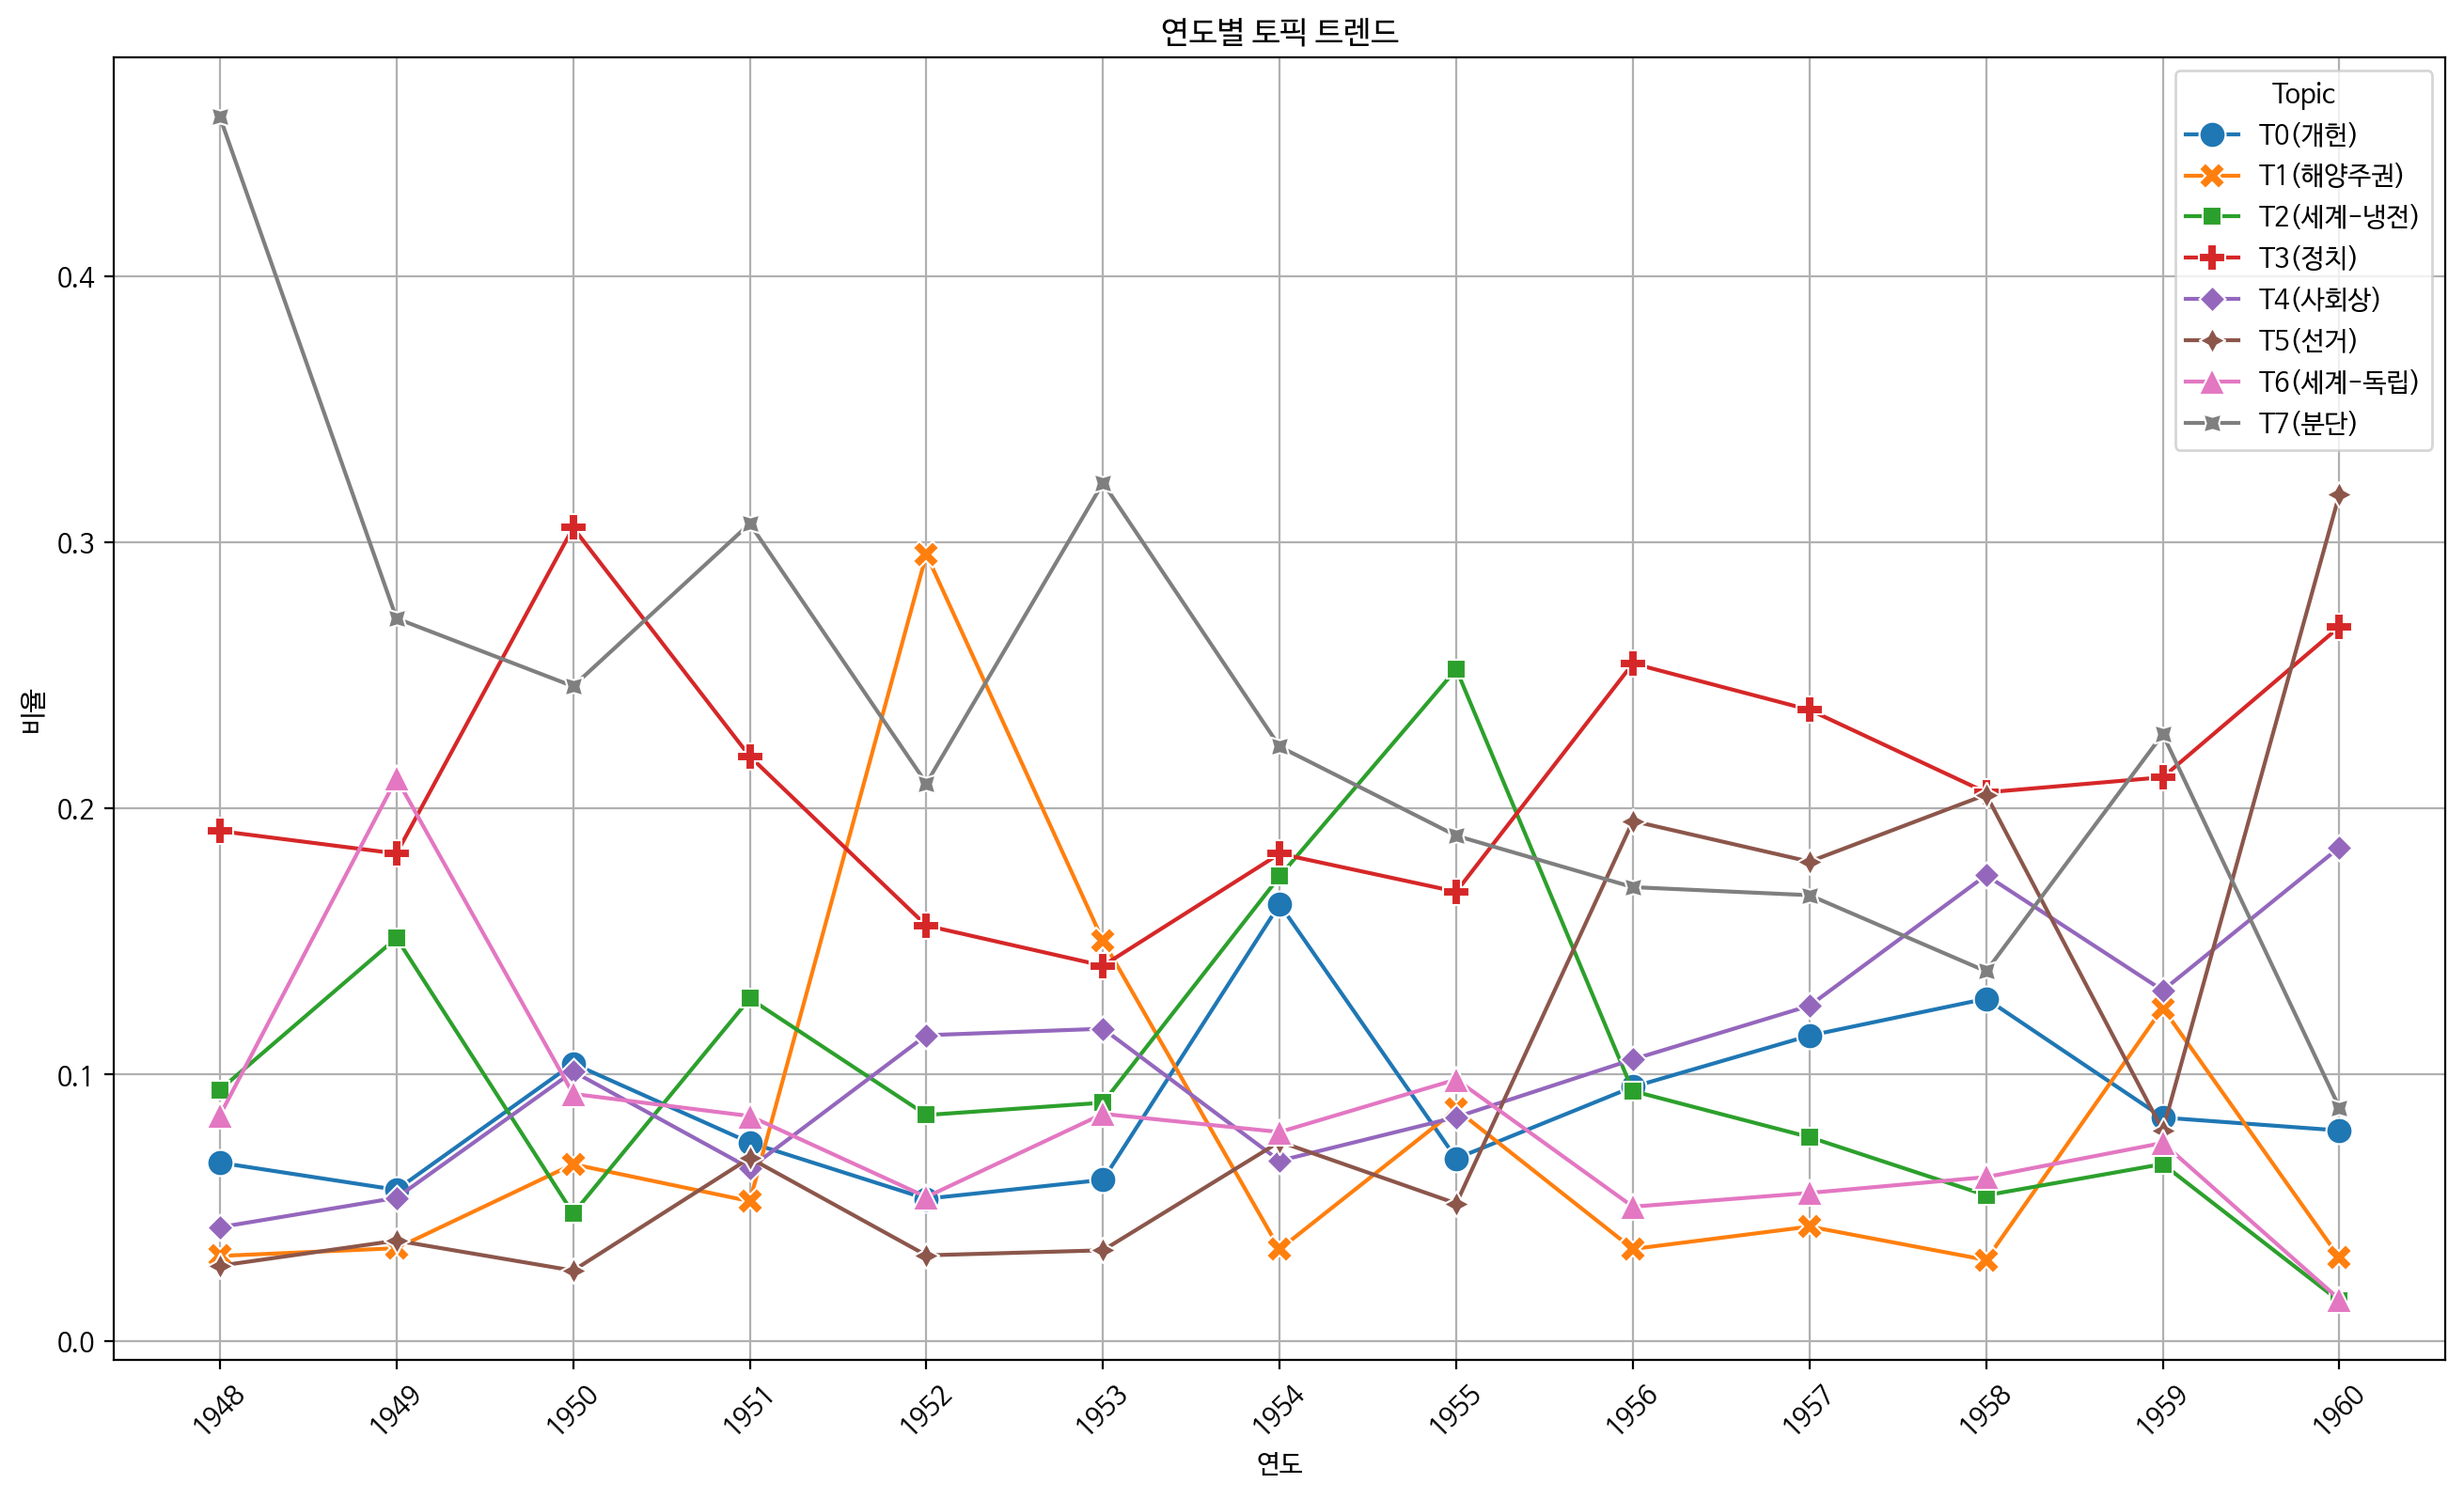

In [ ]:
# 연도별 토픽 트렌드 그래프
data = {
    'Year': [1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960],
    'T0(개헌)': [0.066914, 0.056743, 0.104142, 0.074476, 0.053382, 0.060493, 0.163985, 0.068483, 0.095401, 0.114665, 0.128519, 0.083889, 0.079032],
    'T1(해양주권)': [0.031898, 0.034806, 0.066339, 0.052458, 0.295428, 0.150293, 0.034417, 0.086929, 0.034506, 0.042929, 0.030380, 0.125039, 0.031263],
    'T2(세계-냉전)': [0.094301, 0.151352, 0.047824, 0.128583, 0.084838, 0.089463, 0.174490, 0.252315, 0.093827, 0.076515, 0.054677, 0.066418, 0.014927],
    'T3(정치)': [0.191502, 0.183061, 0.305452, 0.219555, 0.155982, 0.140921, 0.182991, 0.168715, 0.254443, 0.237019, 0.206012, 0.211705, 0.268223],
    'T4(사회상)': [0.042699, 0.053725, 0.101186, 0.064837, 0.114804, 0.117246, 0.067649, 0.084041, 0.105731, 0.125887, 0.174901, 0.131628, 0.185341],
    'T5(선거)': [0.028239, 0.037662, 0.026396, 0.068691, 0.032125, 0.034028, 0.074822, 0.051602, 0.195258, 0.180011, 0.205167, 0.079072, 0.318005],
    'T6(세계-독립)': [0.084715, 0.211284, 0.092777, 0.084446, 0.054043, 0.085275, 0.078442, 0.098185, 0.050405, 0.055570, 0.061521, 0.074345, 0.015583],
    'T7(분단)': [0.459731, 0.271366, 0.245884, 0.306954, 0.209399, 0.322280, 0.223204, 0.189730, 0.170429, 0.167404, 0.138823, 0.227904, 0.087625]
}

df = pd.DataFrame(data)

# DataFrame을 long 형태로 변환
df_melted = pd.melt(df, id_vars='Year', var_name='Topic', value_name='Value')

# Seaborn을 사용하여 그래프 그리기
plt.figure(figsize=(16, 9))
sns_plot = sns.lineplot(data=df_melted, x='Year', y='Value', hue='Topic', style = 'Topic', markers=True, dashes = False)

# Marker 크기 조정
for line in sns_plot.get_lines():
    line.set_markersize(10)

plt.title('연도별 토픽 트렌드')
plt.xlabel('연도')
plt.ylabel('비율')
plt.xticks(ticks=df['Year'], rotation=45)
plt.legend(title='Topic', loc = 'upper right')
plt.grid(True)
plt.show()

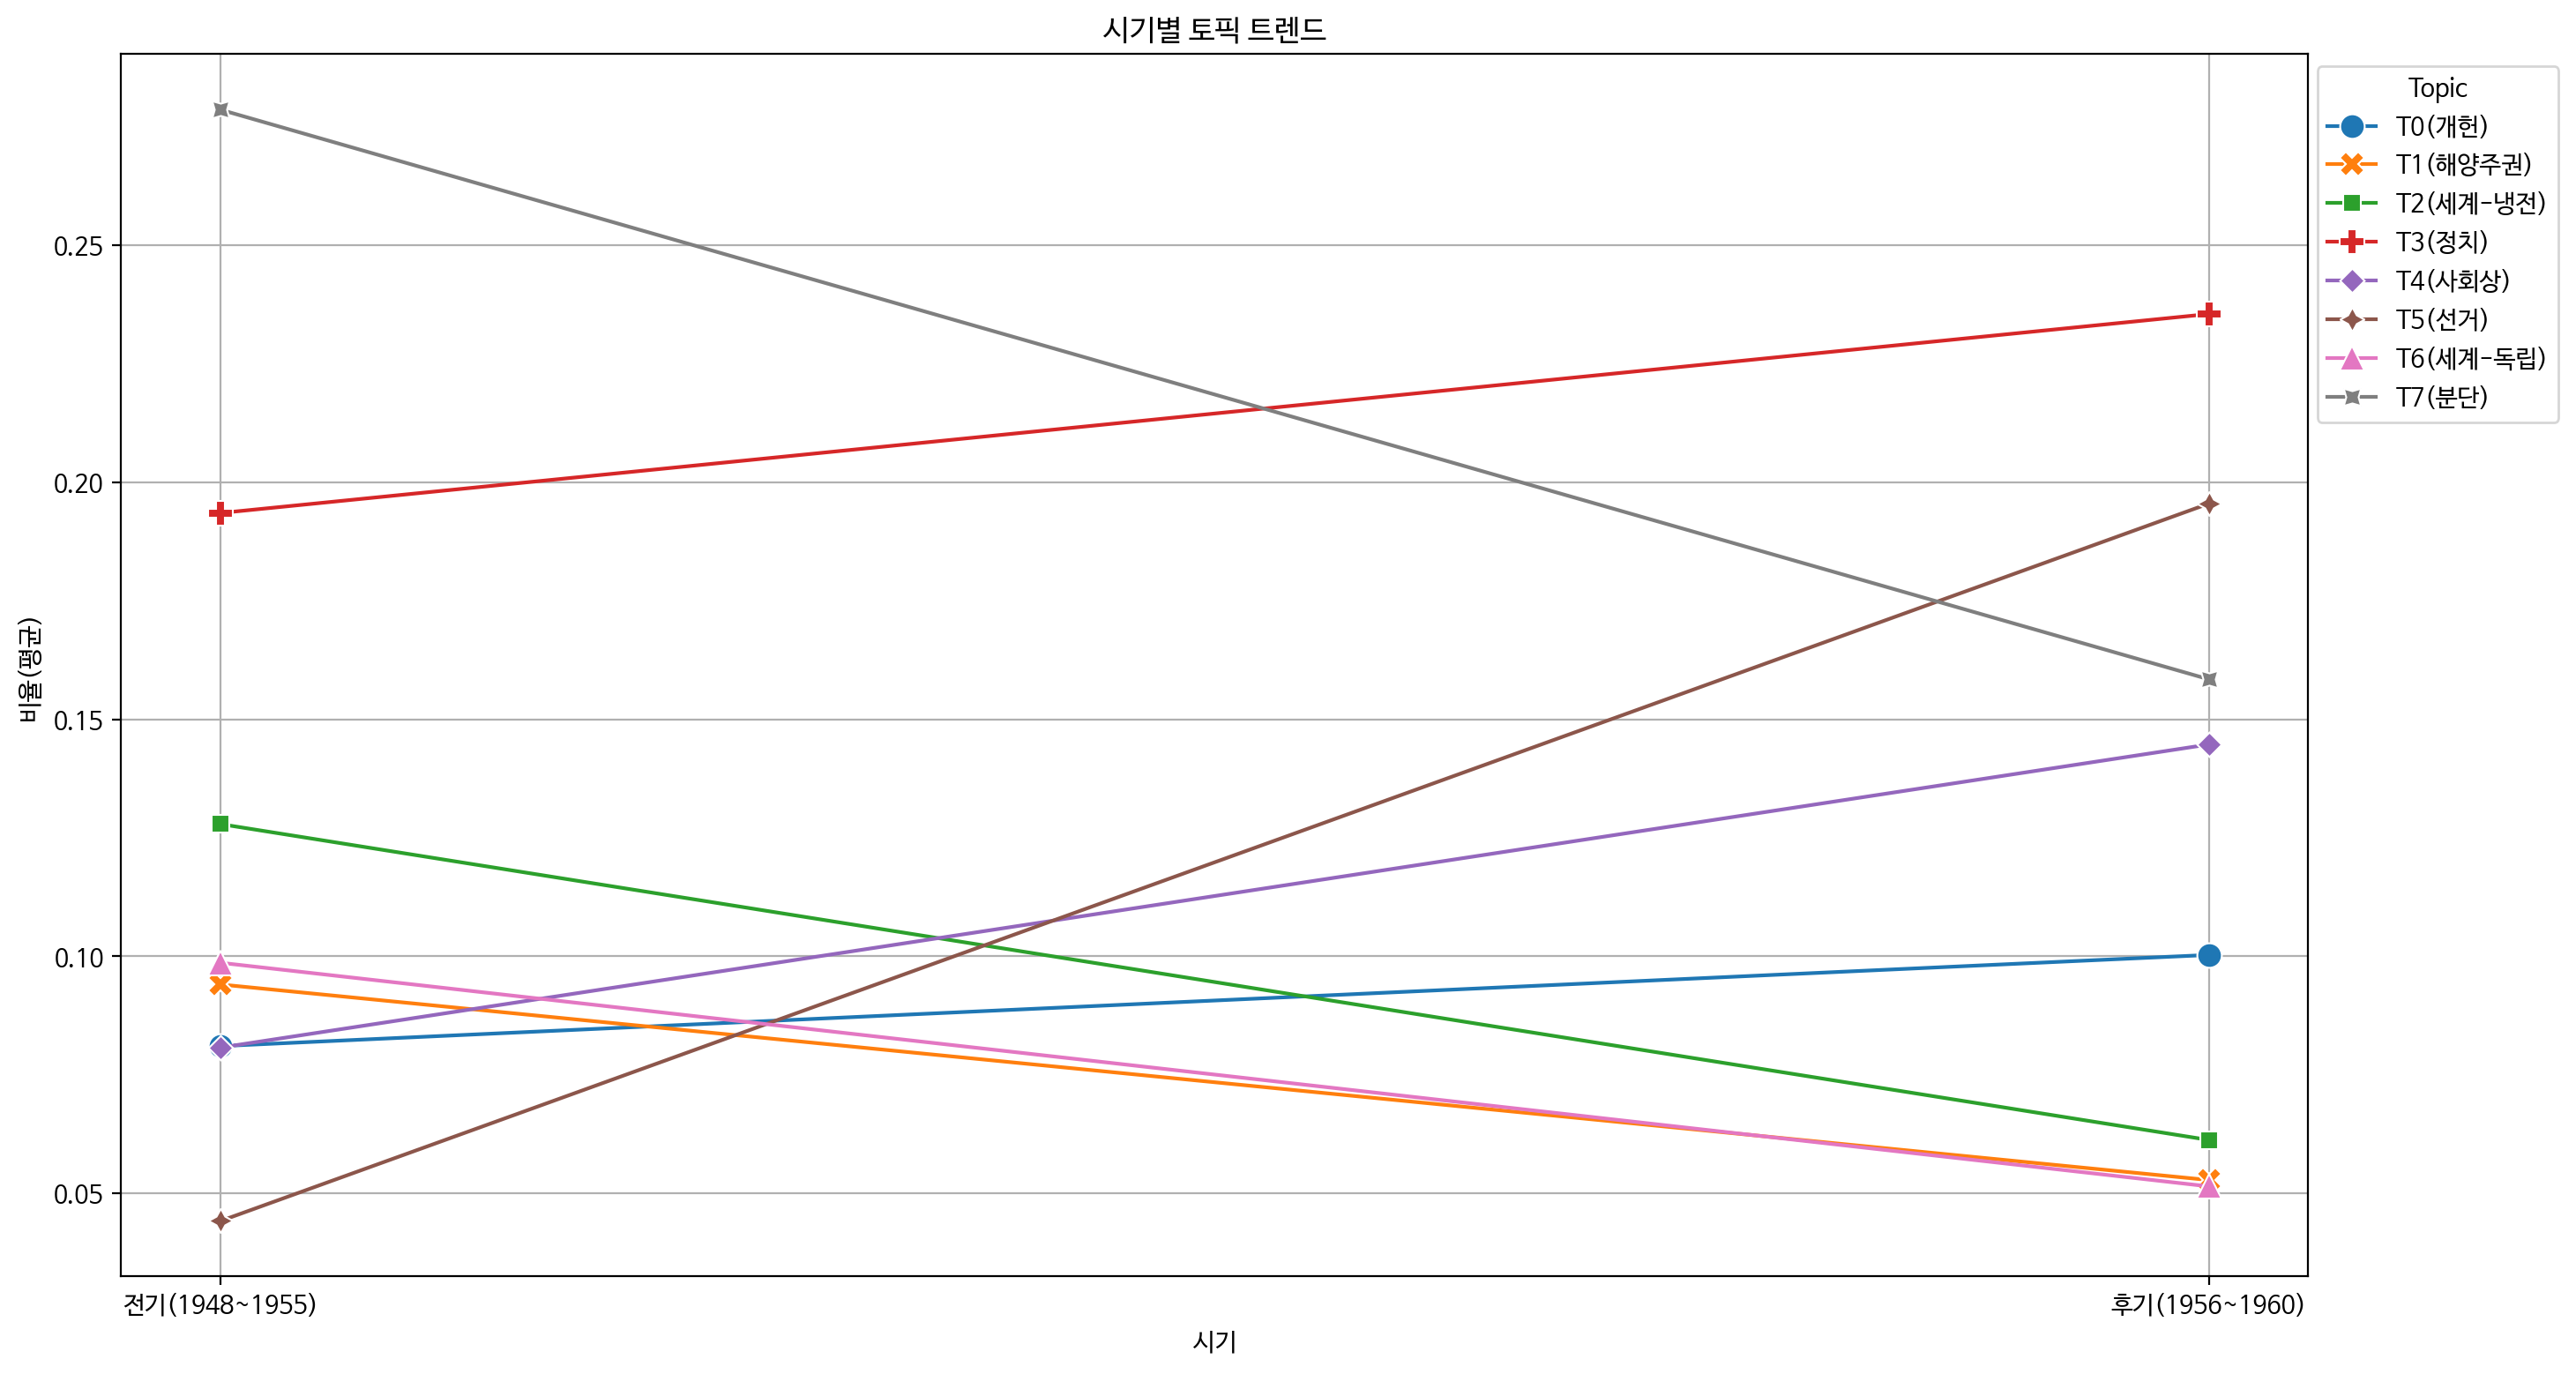

In [ ]:
# 시기별 토픽 트렌드 그래프
data = {
    'Year': [1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960],
    'T0': [0.066914, 0.056743, 0.104142, 0.074476, 0.053382, 0.060493, 0.163985, 0.068483, 0.095401, 0.114665, 0.128519, 0.083889, 0.079032],
    'T1': [0.031898, 0.034806, 0.066339, 0.052458, 0.295428, 0.150293, 0.034417, 0.086929, 0.034506, 0.042929, 0.030380, 0.125039, 0.031263],
    'T2': [0.094301, 0.151352, 0.047824, 0.128583, 0.084838, 0.089463, 0.174490, 0.252315, 0.093827, 0.076515, 0.054677, 0.066418, 0.014927],
    'T3': [0.191502, 0.183061, 0.305452, 0.219555, 0.155982, 0.140921, 0.182991, 0.168715, 0.254443, 0.237019, 0.206012, 0.211705, 0.268223],
    'T4': [0.042699, 0.053725, 0.101186, 0.064837, 0.114804, 0.117246, 0.067649, 0.084041, 0.105731, 0.125887, 0.174901, 0.131628, 0.185341],
    'T5': [0.028239, 0.037662, 0.026396, 0.068691, 0.032125, 0.034028, 0.074822, 0.051602, 0.195258, 0.180011, 0.205167, 0.079072, 0.318005],
    'T6': [0.084715, 0.211284, 0.092777, 0.084446, 0.054043, 0.085275, 0.078442, 0.098185, 0.050405, 0.055570, 0.061521, 0.074345, 0.015583],
    'T7': [0.459731, 0.271366, 0.245884, 0.306954, 0.209399, 0.322280, 0.223204, 0.189730, 0.170429, 0.167404, 0.138823, 0.227904, 0.087625]
}
df = pd.DataFrame(data)


avg_1948_1955 = df[df['Year'].between(1948, 1955)].mean()
avg_1956_1960 = df[df['Year'].between(1956, 1960)].mean()

df_avg = pd.DataFrame({
    'Period': ['전기(1948~1955)', '후기(1956~1960)'],
    'T0(개헌)': [avg_1948_1955['T0'], avg_1956_1960['T0']],
    'T1(해양주권)': [avg_1948_1955['T1'], avg_1956_1960['T1']],
    'T2(세계-냉전)': [avg_1948_1955['T2'], avg_1956_1960['T2']],
    'T3(정치)': [avg_1948_1955['T3'], avg_1956_1960['T3']],
    'T4(사회상)': [avg_1948_1955['T4'], avg_1956_1960['T4']],
    'T5(선거)': [avg_1948_1955['T5'], avg_1956_1960['T5']],
    'T6(세계-독립)': [avg_1948_1955['T6'], avg_1956_1960['T6']],
    'T7(분단)': [avg_1948_1955['T7'], avg_1956_1960['T7']]
})

df_melted = pd.melt(df_avg, id_vars='Period', var_name='Topic', value_name='Value')

# Seaborn을 사용하여 그래프 그리기
plt.figure(figsize=(16, 9))
sns_plot = sns.lineplot(data=df_melted, x='Period', y='Value', hue='Topic', style = 'Topic', markers=True, dashes = False)

# Marker 크기 조정
for line in sns_plot.get_lines():
    line.set_markersize(10)

plt.title('시기별 토픽 트렌드')
plt.xlabel('시기')
plt.ylabel('비율(평균)')
plt.xticks(ticks=df_avg['Period'])
plt.legend(title='Topic', loc = 'upper right', bbox_to_anchor = (1.12, 1))
plt.grid(True)
plt.show()

In [ ]:
# 시기별 토픽의 비중
df_avg

,Period,T0,T1,T2,T3,T4,T5,T6,T7
0,전기,0.081077,0.094071,0.127896,0.193522,0.080773,0.044196,0.098646,0.278568
1,후기,0.100301,0.052823,0.061273,0.235480,0.144698,0.195503,0.051485,0.158437


## 문서별 최대 토픽

In [ ]:
model = DMRModel.load('/content/drive/MyDrive/졸업논문 데이터/topics_model.bin')

In [ ]:
# 각 토픽의 단어의 확률을 print

for k in range(model.k):
    print("== Topic #{} ==".format(k))
    for word, prob in model.get_topic_words(k, top_n=30):
        print(word, prob, sep='\t')
    print()

== Topic #0 ==
헌법	0.04294652119278908
국회	0.0373481847345829
대통령	0.028107095509767532
국민	0.026381582021713257
의원	0.015606703236699104
규정	0.013919533230364323
개헌	0.012615811079740524
개정	0.012232363224029541
국가	0.012002294883131981
정부	0.012002294883131981
법률	0.011350434273481369
주권	0.011197054758667946
개헌안	0.011005330830812454
자유당	0.010315125808119774
국민투표	0.008167818188667297
제도	0.007899404503405094
조항	0.0072091990150511265
행정부	0.007170854136347771
이승만	0.007055819965898991
제한	0.006940785795450211
사항	0.006710716988891363
책임	0.00632726913318038
국회의원	0.006288924720138311
국민투표제	0.005752097815275192
제정	0.005522029474377632
법	0.005368650425225496
중대	0.005061892326921225
반대	0.004985202569514513
선거	0.004985202569514513
입법	0.004946857690811157

== Topic #1 ==
일본	0.0876835510134697
한국	0.04320380464196205
정부	0.021770214661955833
선언	0.01914980635046959
해양	0.017537247389554977
주권	0.015051218681037426
국제	0.010213542729616165
인접	0.00967602338641882
주권선	0.009205693379044533
수역	0.008936934173107147
자원	0.

In [ ]:
# 각 토픽의 단어의 확률을 print ---- 파일 저장용

out = open("/content/drive/MyDrive/졸업논문 데이터/topic_topicword-dist.txt", 'w', encoding='utf-8')

for k in range(model.k):
    for word, prob in model.get_topic_words(k, top_n=30):
        out.write('tp#{0:02d}\t{1:}\t{2:.8f}\n'.format(k, word, prob))
#    out.write('\n')

print("=== finished ===")

out.close()

=== finished ===


In [ ]:
# 문서별 토픽 비중 (토픽비중을 모두 더하면 1이 됨)

'''save topic dist per doc
output: docs_dist.txt'''
#import numpy as np

f = open("/content/drive/MyDrive/졸업논문 데이터/doc_topic-dist.txt", 'w', encoding='utf-8')

k = 8

# calculate topic distribution
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in model.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)


dn = 0
for i in range(k):
    f.write('\tT{}'.format(i))
f.write('\n')

for i in doc_topic_dists:
    #print('D'+str(dn), i)
    f.write("D{}".format(str(dn)))
    for d in range(k): #토픽수
        f.write("\t{:.8f}".format(i[d]))
    f.write('\n')

    dn += 1
print('Topic distributions per docs')
f.close()

Topic distributions per docs


In [ ]:
# 문서별 "최대" 토픽 도출

input_file = "/content/drive/MyDrive/졸업논문 데이터/doc_topic-dist.txt"  #same as topic dist per doc file

output = open("/content/drive/MyDrive/졸업논문 데이터/doc_top-topic.txt", 'w', encoding='utf-8')

k=8

with open(input_file, 'r', encoding='utf-8') as f:
    for n, line in enumerate(f):
        dnum = line.split('\t')[0]
        dist = line.strip().split('\t')[1:]
        dist_max = max(dist)
        htopic = dist.index(max(dist))

        print(dnum, '\t', 'T'+str(htopic))
        output.write('{}\tT{}\t{}\n'.format(dnum, htopic, dist_max))

output.close()

 	 T6
D0 	 T7
D1 	 T6
D2 	 T7
D3 	 T7
D4 	 T6
D5 	 T3
D6 	 T3
D7 	 T7
D8 	 T7
D9 	 T7
D10 	 T7
D11 	 T7
D12 	 T7
D13 	 T7
D14 	 T7
D15 	 T7
D16 	 T3
D17 	 T6
D18 	 T7
D19 	 T3
D20 	 T7
D21 	 T7
D22 	 T7
D23 	 T7
D24 	 T7
D25 	 T7
D26 	 T6
D27 	 T7
D28 	 T7
D29 	 T7
D30 	 T7
D31 	 T2
D32 	 T2
D33 	 T7
D34 	 T3
D35 	 T6
D36 	 T6
D37 	 T7
D38 	 T7
D39 	 T7
D40 	 T3
D41 	 T6
D42 	 T6
D43 	 T6
D44 	 T7
D45 	 T7
D46 	 T0
D47 	 T7
D48 	 T7
D49 	 T7
D50 	 T1
D51 	 T7
D52 	 T7
D53 	 T7
D54 	 T7
D55 	 T3
D56 	 T3
D57 	 T3
D58 	 T2
D59 	 T2
D60 	 T2
D61 	 T7
D62 	 T2
D63 	 T7
D64 	 T2
D65 	 T7
D66 	 T7
D67 	 T2
D68 	 T6
D69 	 T6
D70 	 T6
D71 	 T7
D72 	 T7
D73 	 T7
D74 	 T7
D75 	 T6
D76 	 T3
D77 	 T7
D78 	 T3
D79 	 T6
D80 	 T6
D81 	 T6
D82 	 T6
D83 	 T6
D84 	 T6
D85 	 T6
D86 	 T6
D87 	 T6
D88 	 T6
D89 	 T6
D90 	 T6
D91 	 T7
D92 	 T7
D93 	 T2
D94 	 T3
D95 	 T7
D96 	 T7
D97 	 T0
D98 	 T0
D99 	 T6
D100 	 T6
D101 	 T6
D102 	 T6
D103 	 T6
D104 	 T6
D105 	 T1
D106 	 T6
D107 	 T6
D108 	 T6
D109 	 T7
D110

In [ ]:
# 각 토픽별 최대 비중 문서의 목록 dataframe('dtop_df01') 제작
import csv

f = open("/content/drive/MyDrive/졸업논문 데이터/doc_top-topic.txt", 'r', encoding='utf-8')
dt = csv.reader(f, delimiter='\t')
dtop_list_1p = []
for line in dt:
    dtop_list_1p.append(line)
f.close()
dtop_list_1p[:10]

new2_list = list(map(list, zip(*dtop_list_1p)))
#new2_list

dtop_df = pd.DataFrame(zip(new2_list[1], new2_list[2]),
                       index = pd.Index(new2_list[0]))     #, columns = new_list[0])
#dtop_df

dtop_df.columns = ['top-tp', 'dist']
#dtop_df
dtop_df01 = dtop_df.drop(dtop_df.index[0])
dtop_df01 #### 일단 형성

,top-tp,dist
D0,T7,0.36592734
D1,T6,0.30306360
D2,T7,0.68149006
D3,T7,0.65117043
D4,T6,0.39842010
...,...,...
D854,T0,0.33869830
D855,T3,0.54711127
D856,T3,0.63639659
D857,T0,0.34640852


In [ ]:
dtop_df01 = dtop_df01.reset_index()
dtop_df01

,index,top-tp,dist
0,D0,T7,0.36592734
1,D1,T6,0.30306360
2,D2,T7,0.68149006
3,D3,T7,0.65117043
4,D4,T6,0.39842010
...,...,...,...
854,D854,T0,0.33869830
855,D855,T3,0.54711127
856,D856,T3,0.63639659
857,D857,T0,0.34640852


In [ ]:
dtop_df01 = dtop_df01.sort_values(by = ['top-tp', 'dist'], ascending = [True, False])
dtop_df01 = pd.DataFrame(dtop_df01)
dtop_df01

,index,top-tp,dist
346,D346,T0,0.92105573
347,D347,T0,0.88332415
192,D192,T0,0.87148100
425,D425,T0,0.86844355
188,D188,T0,0.84093130
...,...,...,...
30,D30,T7,0.29951715
777,D777,T7,0.29824397
779,D779,T7,0.29193190
493,D493,T7,0.29006121


## 토픽 보정

In [ ]:
model = DMRModel.load('/content/drive/MyDrive/졸업논문 데이터/topics_model.bin')

In [ ]:
# tp_utils_1.py 읽기 위해 디렉토리 이동
%cd '/content/drive/MyDrive/졸업논문 데이터/'

# tp_utils_1.py를 모듈로 불러오기
import tp_utils_1 as utils

/content/drive/MyDrive/졸업논문 데이터


In [ ]:
df_wordsent = sovereignty_topic
input_list = [x.split('|') for x in df_wordsent['nouns_list'].tolist()]  ###########
print(input_list[:3])  ############ 결과값 확인 위해 일부만 출력 [:3]

In [ ]:
# 상호정보량 산출 코드 (for 토픽보정)
pc = utils.PMICalc()
pc.train(input_list) ############ # 2차 리스트. 전체 값 입력

In [ ]:
# '단어-분포' 형태로 만들고 저장

n_tp_dict = {} #########
for k in range(model.k): ########
    tpw_prop = model.get_topic_words(k, top_n=30)  #########
    tpw_L = []
    for (tpw, prop) in tpw_prop:
        v = (tpw, prop)
        tpw_L.append(v)
    n_tp_dict[k] = tpw_L   #########
#print(n_tp_dict) ###########

# save data
with open('/content/drive/MyDrive/졸업논문 데이터/before-correct.pickle','wb') as fw:  ###########
    pickle.dump(n_tp_dict, fw) ##########

In [ ]:
# 토픽별 단어 출력 -> 토픽 보정

n_tp_L = [] #########
for (i, tp_L) in enumerate(n_tp_dict.values()):  ##########
    temp = []
    for (tpw, point) in tp_L:
        temp.append(tpw)
    temp_re = (i, temp)
    n_tp_L.append(temp_re)  ##########
#print(n_tp_L)

# 토픽 보정

new_topic = []  #########
for (no, tpwList) in n_tp_L: ##########

    sepTCs_list = utils.uniquing_sepTCs(utils.TC_generate, input_list, pc, tpwList) # Step1(토픽분리-TCs)  ############
    tcCombining = utils.uniquing_tcCombining(utils.all_tcCombi_generate, sepTCs_list, tpwList) # Step2(토픽병합1:TC+TC)
    tcCombi_list = utils.combiTC_select(tcCombining, pc) # Step3(토픽병합2-combined TCs)
    update_topic = utils.best_tcCombi(tcCombi_list, pc) # Step4(토픽병합3-best combi TC)

    new_topic.append(update_topic)  ##########
print(new_topic)  ##########

# 토픽단어(tpw) 정돈 후 저장
corr_tp = {}  ##########
n = 0
for best_tc_name, tc_list in new_topic:  ###########
    corr_tp[n] = ','.join(tc_list)  ##########
    n += 1
corr_tp  ##########

# save data
with open('/content/drive/MyDrive/졸업논문 데이터/corrected-tp.pickle','wb') as fw: ###########
    pickle.dump(corr_tp, fw) ########

[('tc29', ['헌법', '국회', '대통령', '국민', '의원', '규정', '개헌', '개정', '국가', '정부', '법률', '주권', '개헌안', '자유당', '국민투표', '제도', '조항', '행정부', '이승만', '제한', '사항', '책임', '국회의원', '국민투표제', '제정', '법', '중대', '반대', '선거', '입법']), ('tc09_28', ['일본', '한국', '정부', '선언', '해양', '주권', '국제', '인접', '주권선', '수역', '자원', '침범', '보호', '어업', '국가', '태도', '국제법', '어선', '영토', '영해', '평화선', '자유', '인정', '관계', '공해', '한일회담', '동경', '대륙붕', '조치']), ('tc26_29', ['미국', '서독', '소련', '주권', '프랑스', '조약', '영국', '독일', '회의', '중국', '협정', '회담', '회복', '유럽', '대통령', '방위', '비준', '재무장', '국가', '완전', '합의', '부여', '자유', 'NATO', '평화', '가입', '요구', 'EDC', '운하', '동독']), ('tc29', ['국민', '정치', '국가', '민주', '민주주의', '자유', '나라', '주권', '정당', '민족', '사회', '발전', '행사', '선거', '권리', '책임', '정신', '공무원', '인민', '권력', '정책', '법', '보장', '조직', '기본', '기관', '헌법', '행정', '주권자', '운동']), ('tc23_29', ['주권', '언론', '사건', '신문', '법', '대회', '학생', '자유', '보도', '시민', '불법', '대한민국', '기자', '수호', '경찰', '국가보안법', '구속', '무효', '운동', '반대', '전국', '공산당', '결의', '진보당', '범죄', '침해', '정신', '평화', '체포', '당국']), ('tc

In [ ]:
# tpw에 단어별 기여도 연결하기

final_tp = []  ###########
for i in range(len(corr_tp)):  ############
    re_tpwL = []
    re_pointL = []
    for (tpw, point) in n_tp_dict[i]:  ############
        re_tpwL.append(tpw)
        re_pointL.append(point)
    n = 0
    for word in corr_tp[i].split(','):  ###########
        if word in re_tpwL:
            result = (i, word, re_pointL[re_tpwL.index(word)])
            final_tp.append(result)  ############
            n += 1
print(final_tp)  ############

[(0, '헌법', 0.04294652119278908), (0, '국회', 0.0373481847345829), (0, '대통령', 0.028107095509767532), (0, '국민', 0.026381582021713257), (0, '의원', 0.015606703236699104), (0, '규정', 0.013919533230364323), (0, '개헌', 0.012615811079740524), (0, '개정', 0.012232363224029541), (0, '국가', 0.012002294883131981), (0, '정부', 0.012002294883131981), (0, '법률', 0.011350434273481369), (0, '주권', 0.011197054758667946), (0, '개헌안', 0.011005330830812454), (0, '자유당', 0.010315125808119774), (0, '국민투표', 0.008167818188667297), (0, '제도', 0.007899404503405094), (0, '조항', 0.0072091990150511265), (0, '행정부', 0.007170854136347771), (0, '이승만', 0.007055819965898991), (0, '제한', 0.006940785795450211), (0, '사항', 0.006710716988891363), (0, '책임', 0.00632726913318038), (0, '국회의원', 0.006288924720138311), (0, '국민투표제', 0.005752097815275192), (0, '제정', 0.005522029474377632), (0, '법', 0.005368650425225496), (0, '중대', 0.005061892326921225), (0, '반대', 0.004985202569514513), (0, '선거', 0.004985202569514513), (0, '입법', 0.004946857690811157), (

In [ ]:
# 위 결과값(리스트-튜플)을 df 형태로 바꾸고 저장(넷마이너 입력값)
df_corr = pd.DataFrame(final_tp)
df_corr.columns = ['tpn', 'tpw', 'contrib']
print(df_corr[:3])
df_corr.to_excel('/content/drive/MyDrive/졸업논문 데이터/nm_corrected-map.xlsx')

   tpn  tpw   contrib
0    0   헌법  0.042947
1    0   국회  0.037348
2    0  대통령  0.028107


In [ ]:
# 보정된 tp-tpw를 간단하게 출력하기(저장)

result = pd.DataFrame(df_corr.groupby('tpn')['tpw'].apply(list)).reset_index() #(lambda x: ' '.join(x))
result['len'] = result['tpw'].apply(lambda x : len(x))
result['tpw_str'] = result['tpw'].apply(lambda x : ' '.join(x))
result1 = result[['tpn', 'len', 'tpw_str']]
print(result1)

# save
result1.to_csv('/content/drive/MyDrive/졸업논문 데이터/corrected_tp-tpw.txt', sep = '^', index = False)

   tpn  len                                            tpw_str
0    0   30  헌법 국회 대통령 국민 의원 규정 개헌 개정 국가 정부 법률 주권 개헌안 자유당 국...
1    1   29  일본 한국 정부 선언 해양 주권 국제 인접 주권선 수역 자원 침범 보호 어업 국가 ...
2    2   30  미국 서독 소련 주권 프랑스 조약 영국 독일 회의 중국 협정 회담 회복 유럽 대통령...
3    3   30  국민 정치 국가 민주 민주주의 자유 나라 주권 정당 민족 사회 발전 행사 선거 권리...
4    4   30  주권 언론 사건 신문 법 대회 학생 자유 보도 시민 불법 대한민국 기자 수호 경찰 ...
5    5   29  선거 의원 자유당 야당 민주당 국민 주권 투쟁 경찰 투표 표 국회 등록 부통령 데모...
6    6   29  인도네시아 네덜란드 주권 공화국 정부 이양 연방 법령 국가 규정 관계 군정 경제 독...
7    7   30  한국 유엔 정부 미국 대한민국 통일 주권 세계 평화 국제 원조 독립 공산 민족 북한...


# Hierarchical Clustering

In [ ]:
# 이 부분은 https://github.com/hursoo/Socialism_of_Gaebyuk/blob/main/gb_040_period.ipynb 를 참조함
# 준비
!pip install adjustText
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from adjustText import adjust_text

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호가 정상 표시되도록 설정
plt.rcParams.update({'figure.dpi' : '100'})
%config InlineBackend.figure_format = 'retina'

In [ ]:
# Data Cleaning 3으로 돌아가서 soveriegnty_nouns_final 변수를 다시 load하여 초기화하고, Topic Modeling 하기 직전까지 코드를 실행
def list_to_pipe_separated(lst):
    return ' '.join(lst)

# 데이터프레임의 열에 적용
sovereignty_nouns_final['nouns_list'] = sovereignty_nouns_final['nouns'].apply(list_to_pipe_separated)

sovereignty_nouns_final

,title_ori,body_ori,publication_date,year,company,title_count,body_count,nouns,nouns_list
0,주권회복축하 나마법황『멧세?지』,주권회복축하라마법황『메시지』일구사팔년팔월십오일대한민국정부수립기념축하식에 나마교황청에...,1948-08-16,1948,동아일보,1,2,"[주권, 회복, 축하, 로마, 교황, 메시지, 대한민국, 정부, 수립, 기념, 축하...",주권 회복 축하 로마 교황 메시지 대한민국 정부 수립 기념 축하식 교황청 한국 주재...
1,군정도폐막된오늘날 포고령 존속은모순,군정도폐막된오늘날\n포고령\n존속은모순\n새국가면목세워무효선포시급\n 점령군의 안전...,1948-08-21,1948,조선일보,0,5,"[군정, 폐막, 포고령, 존속, 모순, 국가, 면목, 무효, 선포, 시급, 점령군,...",군정 폐막 포고령 존속 모순 국가 면목 무효 선포 시급 점령군 안전 도모 공포 포고...
2,불원자주주권회복확신,불원자주주권회복확신 「무치오」특사래한제일성을발표 지난 이십삼일 오후이시넘어 공로...,1948-08-25,1948,경향신문,1,2,"[자주, 주권, 회복, 확신, 무치오, 특사, 내한, 제일성, 공로, 내한, 무치오...",자주 주권 회복 확신 무치오 특사 내한 제일성 공로 내한 무치오 특사 신문 기자 회...
3,이범석총리최초의 시정방침연설요지,이범석총리최초의 시정방침연설요지 주권확립과남북통일 민생문제해결에 산업경제부흥 정부수...,1948-08-29,1948,경향신문,0,3,"[이범석, 총리, 최초, 시정, 방침, 연설, 주권, 확립, 남북, 통일, 민생, ...",이범석 총리 최초 시정 방침 연설 주권 확립 남북 통일 민생 해결 산업 경제 부흥 ...
4,행정이양과 말초적마찰,행정이양과말초적마찰\n 행정이양이 예상외로급속히진행되지못하는때문에말단에서 혹은미초적...,1948-08-31,1948,조선일보,0,5,"[행정, 이양, 말초, 마찰, 행정, 이양, 예상, 진행, 말단, 군정, 기구, 직...",행정 이양 말초 마찰 행정 이양 예상 진행 말단 군정 기구 직원 정부 대립 감정 얼...
...,...,...,...,...,...,...,...,...,...
854,내란죄로몰린150여명 발췌·사사오입개헌자고발상 (하),내란죄로몰린150여명발췌·사사오입개헌자고발상(하)다시요약하면 금번의거의의로움과 법적...,1960-05-07,1960,동아일보,0,4,"[내란죄, 발췌, 사사오입, 개헌, 발상, 요약, 의거, 법, 이차, 쿠데타, 정권...",내란죄 발췌 사사오입 개헌 발상 요약 의거 법 이차 쿠데타 정권 이승만 박사 정부 ...
855,정국수습에 대한 나의 제언 진정한 민의 파악,정국수습에대한나의제언 진정한민의 파악 빨리주권행사의기회를주자 주 요 섭 잃어버렸던...,1960-05-10,1960,경향신문,0,3,"[정국, 수습, 제언, 민의, 파악, 주권, 행사, 기회, 주권, 청소년, 시민, ...",정국 수습 제언 민의 파악 주권 행사 기회 주권 청소년 시민 보답 모독 사견 피력 ...
856,혁명뒤에오는것,혁명뒤에오는것\n이광록\n 사·일구의의의\n사·일구사태는 혁명다운혁명이다 정치학자「...,1960-05-12,1960,조선일보,0,9,"[혁명, 사·일구, 의의, 사·일구, 사태, 혁명, 혁명, 정치, 학자, 혁명, 정...",혁명 사·일구 의의 사·일구 사태 혁명 혁명 정치 학자 혁명 정의 법률 주권 부정 ...
857,주권침해방지 천거법공청에 각계의견,주권침해방지 천거법공청에각계의견 국회는 심의중인 국회의원선거법안을 십이년의 선거...,1960-05-20,1960,경향신문,1,2,"[주권, 침해, 방지, 선거법, 공청, 각계, 의견, 국회, 심의, 국회, 의원, ...",주권 침해 방지 선거법 공청 각계 의견 국회 심의 국회 의원 선거 법안 선거 사상 ...


In [ ]:
def get_dtm(df, col_name, stopw, rank_n): # rank_n : TF-IDF 상위 n개 단어까지
    '''
    # 문서-단어 행렬(dtm) 산출 함수
    '''

    # 단어 종류 모두 벡터화. 2음절 이상
    tv = TfidfVectorizer(stop_words=stopw, norm=None)
    dtm = tv.fit_transform(df[col_name])

    # df 형태로 표시
    dtm_df = pd.DataFrame(dtm.toarray(), columns=tv.get_feature_names_out(), index=df.index)

    highword_list = dtm_df.sum().sort_values(ascending=False)[:rank_n].index.to_list()
    feature_df = dtm_df[highword_list] # 열 순서는 tfidf값이 높은 것부터 낮은 순으로 정렬
    return feature_df

In [ ]:
stopword = []

dtm50_df = get_dtm(sovereignty_nouns_final, 'nouns_list', stopword, 50) # 상위 50개 단어
dtm50_df

,국민,한국,일본,헌법,선거,주권,국가,의원,정부,국회,...,개헌,선언,개정,책임,사건,개헌안,중국,제도,이승만,정책
0,1.670158,4.086399,0.0,0.000000,0.000000,2.105036,0.000000,0.000000,3.264498,0.000000,...,0.000000,0.00000,0.000000,2.563976,0.000000,0.0,0.0,0.000000,5.616345,0.000000
1,0.000000,0.000000,0.0,2.414598,0.000000,5.262590,8.194176,0.000000,1.632249,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
2,0.000000,2.043200,0.0,0.000000,0.000000,2.105036,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,0.000000,2.043200,0.0,0.000000,0.000000,3.157554,1.638835,0.000000,1.632249,2.122143,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,2.952911,0.000000,0.000000
4,5.010473,6.129599,0.0,2.414598,2.115025,4.210072,3.277670,0.000000,29.380482,0.000000,...,0.000000,7.62599,0.000000,2.563976,0.000000,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,11.691104,0.000000,0.0,36.218972,0.000000,2.105036,3.277670,0.000000,1.632249,2.122143,...,3.400224,0.00000,3.374906,0.000000,2.851658,0.0,0.0,0.000000,14.040862,0.000000
855,0.000000,0.000000,0.0,0.000000,2.115025,3.157554,0.000000,0.000000,0.000000,4.244286,...,10.200671,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
856,28.392680,0.000000,0.0,2.414598,0.000000,9.472662,19.666022,7.172869,3.264498,10.610714,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,8.424517,2.669336
857,1.670158,0.000000,0.0,0.000000,12.690152,2.105036,0.000000,2.390956,0.000000,4.244286,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,11.811645,0.000000,0.000000


In [ ]:
dtm50_df.sum()

국민       4270.593143
한국       3387.624910
일본       3371.110254
헌법       3095.514812
선거       3064.671686
주권       2772.332502
국가       2699.161560
의원       2682.653052
정부       2665.462614
국회       2597.502770
정치       2539.288444
미국       2527.563471
대통령      2294.328401
자유       1987.106968
유엔       1898.459480
자유당      1888.601062
소련       1856.496836
민주       1791.292610
서독       1730.054751
대한민국     1685.399031
민주주의     1456.955492
인도네시아    1445.890354
프랑스      1423.328388
규정       1389.315346
민족       1384.133736
회의       1346.245269
조약       1299.689465
세계       1282.956365
통일       1271.153564
독일       1265.206922
영국       1256.083441
국제       1233.629624
평화       1231.398019
협정       1208.186776
나라       1192.428286
경제       1184.883421
네덜란드     1147.016169
민주당      1131.052274
독립       1129.980105
야당       1129.640146
개헌       1118.673552
선언       1115.936521
개정       1076.594936
책임       1074.305751
사건       1060.816631
개헌안      1050.064855
중국       1049.660262
제도       1015

In [ ]:
def transform_to_gtm(df, grid_col, dtm): # 매개변수: df(gb_df), 구간 정보 열(문자열 형태로), dtm50_df
    '''
    # 문서-단어 행렬(dtm)을 연도-단어 행렬(gtm)으로 변환하기 - 구간 정보: 연도
    '''
    # 구간정보만 df로 추출
    grid = df[[grid_col]]
    # 구간 정보 결합하고, 구간을 index로 만듦
    temp_dtm = pd.concat([dtm, grid], axis=1)
    grid_dtm = temp_dtm.set_index(grid_col)
    # 구간별 평균
    gtm = grid_dtm.groupby(grid_col).mean()
    return gtm

In [ ]:
gtm50 = transform_to_gtm(sovereignty_nouns_final, 'year', dtm50_df)
gtm50

,국민,한국,일본,헌법,선거,주권,국가,의원,정부,국회,...,개헌,선언,개정,책임,사건,개헌안,중국,제도,이승만,정책
year,,,,,,,,,,,,,,,,,,,,,
1948,3.188483,14.178567,1.460453,1.243884,2.371392,2.998082,5.264137,1.521518,8.062321,2.765216,...,0.000000,0.539211,0.000000,1.087747,0.172828,0.000000,1.281636,0.626375,0.765865,2.022224
1949,1.358150,2.671876,1.811840,4.271981,0.604293,3.978749,3.223643,0.551759,2.941636,1.305934,...,0.485746,0.502813,1.743083,0.591687,1.190802,0.000000,8.492602,0.778790,0.339449,1.496002
1950,11.539271,6.129599,4.611957,4.829196,4.133913,3.923022,7.002296,0.434719,6.899962,5.787662,...,1.236445,0.346636,0.613619,1.864709,0.388862,0.165730,2.796298,1.073786,0.382933,2.184002
1951,4.056097,5.107999,3.986049,1.552242,2.417172,2.631295,1.872955,2.732522,3.147909,5.608520,...,0.000000,1.089427,1.446388,0.732564,0.203690,1.041731,0.274636,4.218445,0.601751,1.906669
1952,1.741736,6.596616,11.849436,1.931679,0.815795,3.022230,2.341193,2.083548,3.381087,2.243408,...,0.388597,4.938736,0.144639,0.805821,0.122214,0.729212,0.054927,1.518640,1.524436,0.381334
1953,2.035505,11.461073,10.225574,0.679106,0.760087,2.647741,2.458253,0.224152,4.055119,0.795804,...,0.106257,2.859746,0.580062,0.560870,0.668357,0.227879,0.360460,0.230696,2.588784,0.500501
1954,6.727024,3.462088,1.514900,6.707217,2.496905,3.873851,4.484035,4.283797,3.287168,5.246409,...,5.572589,0.829679,2.695237,2.813251,0.495079,6.254003,0.080102,2.460759,1.813611,0.908316
1955,4.283146,2.801161,4.827678,2.959830,1.296306,2.699199,2.934044,0.578457,2.422047,2.053687,...,0.219369,0.819999,0.108868,0.951152,0.689917,0.176422,1.426337,0.714414,0.181172,1.076345
1956,7.571381,0.204320,1.296472,2.307283,6.932583,2.923661,2.421834,8.926237,2.593462,2.923841,...,0.377803,0.790843,0.149996,1.082567,1.584254,0.000000,0.213606,0.820253,1.404086,1.067734


In [ ]:
def get_cossim(dtm): # 매개변수: docu-term-matrix
    '''
    # 코사인유사도 산출 함수
    '''
    idx = dtm.index.tolist()
    cossim_v = cosine_similarity(dtm, dtm) # 인덱스(행) 간의 관계가 산출
    cossim = pd.DataFrame(cossim_v, columns=idx, index=idx)
    return cossim

In [ ]:
# gtm의 구간별 유사도(코사인유사도)
grid_sim = get_cossim(gtm50)
grid_sim

,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
1948,1.000000,0.536812,0.679996,0.667346,0.607866,0.781801,0.523229,0.591516,0.442566,0.468677,0.448303,0.608425,0.350843
1949,0.536812,1.000000,0.467623,0.416541,0.349035,0.401094,0.382338,0.509155,0.318103,0.319406,0.327400,0.406268,0.236154
1950,0.679996,0.467623,1.000000,0.782909,0.633535,0.649262,0.669124,0.667524,0.689138,0.667577,0.691646,0.840736,0.618925
1951,0.667346,0.416541,0.782909,1.000000,0.716274,0.725462,0.710835,0.645896,0.609058,0.587508,0.668426,0.717372,0.490577
1952,0.607866,0.349035,0.633535,0.716274,1.000000,0.892428,0.548493,0.621162,0.451308,0.463043,0.447252,0.861219,0.343423
1953,0.781801,0.401094,0.649262,0.725462,0.892428,1.000000,0.469539,0.564170,0.357039,0.405696,0.401951,0.794131,0.291257
1954,0.523229,0.382338,0.669124,0.710835,0.548493,0.469539,1.000000,0.769708,0.658147,0.682031,0.669325,0.616804,0.549090
1955,0.591516,0.509155,0.667524,0.645896,0.621162,0.564170,0.769708,1.000000,0.540198,0.522899,0.496474,0.670412,0.421660
1956,0.442566,0.318103,0.689138,0.609058,0.451308,0.357039,0.658147,0.540198,1.000000,0.857532,0.898813,0.623404,0.808492
1957,0.468677,0.319406,0.667577,0.587508,0.463043,0.405696,0.682031,0.522899,0.857532,1.000000,0.814308,0.649938,0.752338


In [ ]:
def hierarchical_clustering(grid_sim_matrix, num_clusters=2):
    '''
    계층적 군집화 관련 함수
    '''
    # 주어진 코사인 유사도 행렬을 NumPy 배열로 변환
    data = grid_sim_matrix.values
    data_labels = grid_sim_matrix.index

    # 계층적 클러스터링을 수행
    linkage_matrix = linkage(data, method='ward')  # 'ward' 연결 방법 사용

    # 덴드로그램 그리기 전에 색깔 구분을 위한 color_threshold 계산
    threshold = linkage_matrix[-(num_clusters-1), 2] if num_clusters > 1 else 0

    # 사용할 색상 리스트 정의
    colors = ['red', 'blue', 'green', 'purple', 'orange']

    plt.figure(figsize=(7, 4))
    dendrogram(linkage_matrix, labels=data_labels, orientation='right', color_threshold=threshold)
    plt.xlabel('Distance')
    plt.ylabel('Year')
    plt.title('Hierarchical Clustering Dendrogram')

    # 지정된 군집 수로 데이터 군집화
    clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

    # 군집 결과 출력
    print(f"{num_clusters}개의 군집 결과:")
    for qrt, cluster_id in zip(data_labels, clusters):
        print(f'{qrt}: Cluster {cluster_id}')

    # Seaborn 스타일 설정
    sns.set(style='whitegrid')

    # 그래프 출력
    plt.show()

2개의 군집 결과:
1948: Cluster 2
1949: Cluster 2
1950: Cluster 2
1951: Cluster 2
1952: Cluster 2
1953: Cluster 2
1954: Cluster 2
1955: Cluster 2
1956: Cluster 1
1957: Cluster 1
1958: Cluster 1
1959: Cluster 2
1960: Cluster 1


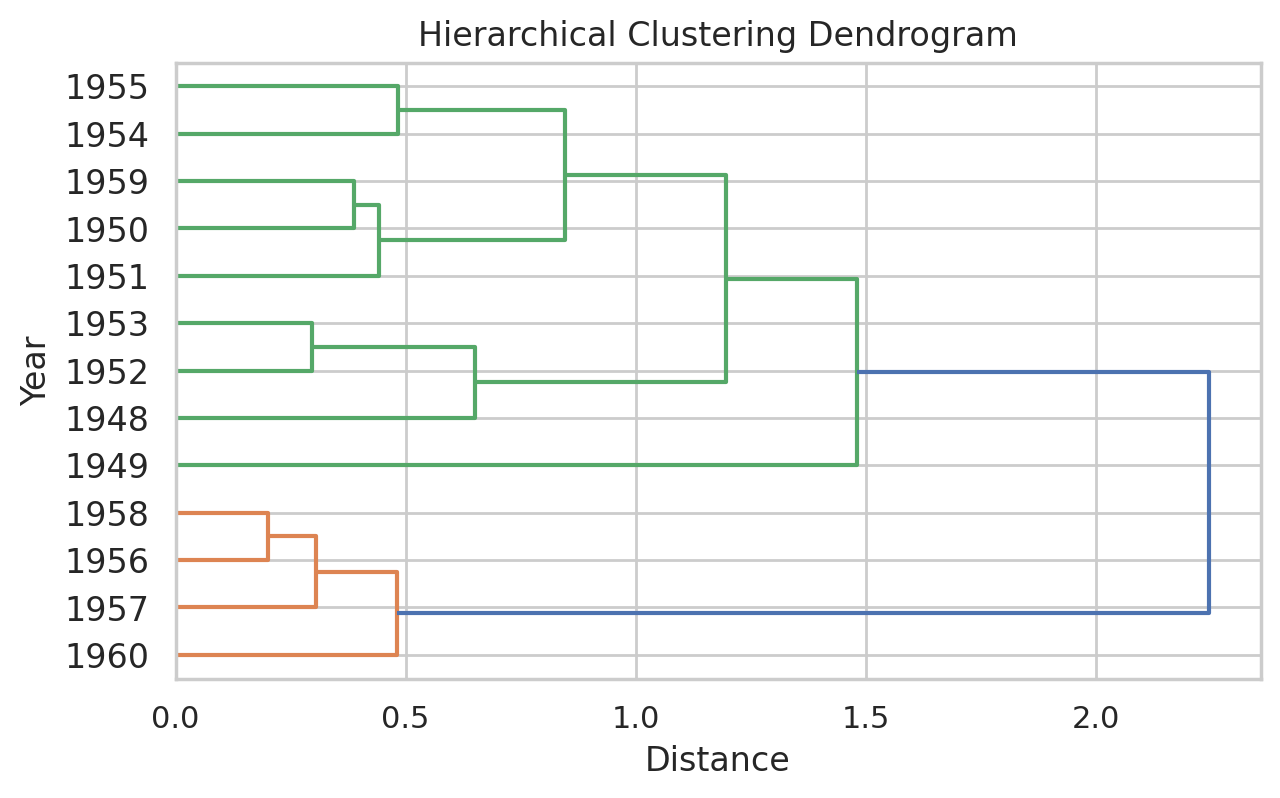

In [ ]:
hierarchical_clustering(grid_sim, num_clusters=2)

# 주권 공기어 수집 및 넷마이너 파일 생성

## 주권 공기어 수집

In [ ]:
# 기본적으로 주권 관련 단어 전후 2단어를 수집하여 'nouns_context' 열에 저장하는 함수들 (앞 혹은 뒤에 단어가 부족할 경우 다른 방향에서 단어를 더 수집, 단어가 극단적으로 적을 경우 전체를 수집)
def extract_context(nouns_list, keyword, context_size=2): ##### 전후 n 단어 -> n: context_size
    contexts = []
    for i, word in enumerate(nouns_list):
        if word == keyword:
            start = max(i - context_size, 0)
            end = min(i + context_size + 1, len(nouns_list))
            context = nouns_list[start:end]
            if len(context) < 5: ##### 키워드를 포함한 단어의 개수에 대한 설정에 따라 숫자 조정
                additional_words = 5 - len(context) ##### 키워드를 포함한 단어의 개수에 대한 설정에 따라 숫자 조정
                if start == 0:
                    context.extend(nouns_list[end:end + additional_words])
                elif end == len(nouns_list):
                    context = nouns_list[max(0, start - additional_words):start] + context
            contexts.append(context[:5])  ##### 키워드를 포함한 n개의 단어. 여기에서는 5개
    return contexts

def generate_nouns_context(df, keywords):
    rows = []
    for _, row in df.iterrows():
        nouns_list = row['nouns']
        for keyword in keywords:
            contexts = extract_context(nouns_list, keyword)
            for context in contexts:
                new_row = row.copy()
                new_row['nouns_context'] = context
                rows.append(new_row)
    return pd.DataFrame(rows)

# 주권 관련 단어 리스트
keywords = ['주권', '주권자', '주권선', '자주권', '주권론', '주권성']

# nouns_context 생성
sovereignty_words = generate_nouns_context(sovereignty_nouns_final, keywords)
sovereignty_words

,title_ori,body_ori,publication_date,year,company,title_count,body_count,nouns,nouns_context
0,주권회복축하 나마법황『멧세?지』,주권회복축하라마법황『메시지』일구사팔년팔월십오일대한민국정부수립기념축하식에 나마교황청에...,1948-08-16,1948,동아일보,1,2,"[주권, 회복, 축하, 로마, 교황, 메시지, 대한민국, 정부, 수립, 기념, 축하...","[주권, 회복, 축하, 로마, 교황]"
0,주권회복축하 나마법황『멧세?지』,주권회복축하라마법황『메시지』일구사팔년팔월십오일대한민국정부수립기념축하식에 나마교황청에...,1948-08-16,1948,동아일보,1,2,"[주권, 회복, 축하, 로마, 교황, 메시지, 대한민국, 정부, 수립, 기념, 축하...","[교황, 대한민국, 주권, 회복, 축하]"
1,군정도폐막된오늘날 포고령 존속은모순,군정도폐막된오늘날\n포고령\n존속은모순\n새국가면목세워무효선포시급\n 점령군의 안전...,1948-08-21,1948,조선일보,0,5,"[군정, 폐막, 포고령, 존속, 모순, 국가, 면목, 무효, 선포, 시급, 점령군,...","[종료, 주둔, 주권, 국가, 신생]"
1,군정도폐막된오늘날 포고령 존속은모순,군정도폐막된오늘날\n포고령\n존속은모순\n새국가면목세워무효선포시급\n 점령군의 안전...,1948-08-21,1948,조선일보,0,5,"[군정, 폐막, 포고령, 존속, 모순, 국가, 면목, 무효, 선포, 시급, 점령군,...","[처지, 국가, 주권, 회복, 고대]"
1,군정도폐막된오늘날 포고령 존속은모순,군정도폐막된오늘날\n포고령\n존속은모순\n새국가면목세워무효선포시급\n 점령군의 안전...,1948-08-21,1948,조선일보,0,5,"[군정, 폐막, 포고령, 존속, 모순, 국가, 면목, 무효, 선포, 시급, 점령군,...","[선포, 명실상부, 주권, 국가, 외면]"
...,...,...,...,...,...,...,...,...,...
856,혁명뒤에오는것,혁명뒤에오는것\n이광록\n 사·일구의의의\n사·일구사태는 혁명다운혁명이다 정치학자「...,1960-05-12,1960,조선일보,0,9,"[혁명, 사·일구, 의의, 사·일구, 사태, 혁명, 혁명, 정치, 학자, 혁명, 정...","[지위, 정치, 주권, 입법권, 행정]"
857,주권침해방지 천거법공청에 각계의견,주권침해방지 천거법공청에각계의견 국회는 심의중인 국회의원선거법안을 십이년의 선거...,1960-05-20,1960,경향신문,1,2,"[주권, 침해, 방지, 선거법, 공청, 각계, 의견, 국회, 심의, 국회, 의원, ...","[주권, 침해, 방지, 선거법, 공청]"
857,주권침해방지 천거법공청에 각계의견,주권침해방지 천거법공청에각계의견 국회는 심의중인 국회의원선거법안을 십이년의 선거...,1960-05-20,1960,경향신문,1,2,"[주권, 침해, 방지, 선거법, 공청, 각계, 의견, 국회, 심의, 국회, 의원, ...","[집권자, 국민, 주권, 침해, 법]"
858,주권이의을요구,주권이의을요구\n불아공동체 사개국서\n불아공동체의사개회원국은 삼일동공동체가 장악하고...,1960-06-04,1960,조선일보,1,2,"[주권, 이의, 요구, 불아공동체, 불아공동체, 회원국, 공동체, 장악, 주권, 이...","[주권, 이의, 요구, 불아공동체, 불아공동체]"


In [ ]:
# '주권'이 포함된 단어를 검색하여 unique한 목록을 생성하는 함수
def find_unique_words_containing_keyword(df, column_name, keyword_pattern):
    unique_words = set()
    pattern = re.compile(keyword_pattern)
    for row in df[column_name]:
        words = row  # assuming the words are stored as list-like strings
        for word in words:
            if pattern.search(word):
                unique_words.add(word)
    return list(unique_words)

# 정규 표현식 패턴
keyword_pattern = r'\w*주권\w*'

# 'nouns' 열에서 '주권'이 포함된 단어 검색
unique_words = find_unique_words_containing_keyword(sovereignty_words, 'nouns', keyword_pattern)

# 결과 출력
print("Unique words matching pattern '{}':".format(keyword_pattern))
print(unique_words)

Unique words matching pattern '\w*주권\w*':
['주권자', '주권', '주권성', '혁명주권위원회', '주권련습', '자주권', '미주권', '국민주권옹호위원회', '주권선', '주권상', '국민주권옹호투쟁위원회', '주권하', '주권권', '민주권', '주권론', '신주권']


In [ ]:
sovereignty_words = sovereignty_words.drop(['body_ori', 'publication_date', 'title_count', 'body_count', 'nouns'], axis = 1)
sovereignty_words

,title_ori,year,company,nouns_context
0,주권회복축하 나마법황『멧세?지』,1948,동아일보,"[주권, 회복, 축하, 로마, 교황]"
0,주권회복축하 나마법황『멧세?지』,1948,동아일보,"[교황, 대한민국, 주권, 회복, 축하]"
1,군정도폐막된오늘날 포고령 존속은모순,1948,조선일보,"[종료, 주둔, 주권, 국가, 신생]"
1,군정도폐막된오늘날 포고령 존속은모순,1948,조선일보,"[처지, 국가, 주권, 회복, 고대]"
1,군정도폐막된오늘날 포고령 존속은모순,1948,조선일보,"[선포, 명실상부, 주권, 국가, 외면]"
...,...,...,...,...
856,혁명뒤에오는것,1960,조선일보,"[지위, 정치, 주권, 입법권, 행정]"
857,주권침해방지 천거법공청에 각계의견,1960,경향신문,"[주권, 침해, 방지, 선거법, 공청]"
857,주권침해방지 천거법공청에 각계의견,1960,경향신문,"[집권자, 국민, 주권, 침해, 법]"
858,주권이의을요구,1960,조선일보,"[주권, 이의, 요구, 불아공동체, 불아공동체]"


In [ ]:
sovereignty_words['doc_no'] = range(len(sovereignty_words))
sovereignty_words['title_no'] = sovereignty_words.index
sovereignty_words # 단어 연결망에 투입되는 문서: 3028개

,title_ori,year,company,nouns_context,doc_no,title_no
0,주권회복축하 나마법황『멧세?지』,1948,동아일보,"[주권, 회복, 축하, 로마, 교황]",0,0
0,주권회복축하 나마법황『멧세?지』,1948,동아일보,"[교황, 대한민국, 주권, 회복, 축하]",1,0
1,군정도폐막된오늘날 포고령 존속은모순,1948,조선일보,"[종료, 주둔, 주권, 국가, 신생]",2,1
1,군정도폐막된오늘날 포고령 존속은모순,1948,조선일보,"[처지, 국가, 주권, 회복, 고대]",3,1
1,군정도폐막된오늘날 포고령 존속은모순,1948,조선일보,"[선포, 명실상부, 주권, 국가, 외면]",4,1
...,...,...,...,...,...,...
856,혁명뒤에오는것,1960,조선일보,"[지위, 정치, 주권, 입법권, 행정]",3023,856
857,주권침해방지 천거법공청에 각계의견,1960,경향신문,"[주권, 침해, 방지, 선거법, 공청]",3024,857
857,주권침해방지 천거법공청에 각계의견,1960,경향신문,"[집권자, 국민, 주권, 침해, 법]",3025,857
858,주권이의을요구,1960,조선일보,"[주권, 이의, 요구, 불아공동체, 불아공동체]",3026,858


In [ ]:
sovereignty_words = sovereignty_words.explode('nouns_context') # explode(): 'nouns_context'의 list에 있는 단어들을 하나씩 분리하여 행으로 저장
sovereignty_words = sovereignty_words[['doc_no', 'title_no', 'title_ori', 'nouns_context', 'year', 'company']]
sovereignty_words

,doc_no,title_no,title_ori,nouns_context,year,company
0,0,0,주권회복축하 나마법황『멧세?지』,주권,1948,동아일보
0,0,0,주권회복축하 나마법황『멧세?지』,회복,1948,동아일보
0,0,0,주권회복축하 나마법황『멧세?지』,축하,1948,동아일보
0,0,0,주권회복축하 나마법황『멧세?지』,로마,1948,동아일보
0,0,0,주권회복축하 나마법황『멧세?지』,교황,1948,동아일보
...,...,...,...,...,...,...
858,3027,858,주권이의을요구,공동체,1960,조선일보
858,3027,858,주권이의을요구,장악,1960,조선일보
858,3027,858,주권이의을요구,주권,1960,조선일보
858,3027,858,주권이의을요구,이양,1960,조선일보


In [ ]:
sovereignty_words = sovereignty_words.reset_index(drop = True)
sovereignty_words = sovereignty_words.rename(columns = {'nouns_context' : 'word'})
sovereignty_words

,doc_no,title_no,title_ori,word,year,company
0,0,0,주권회복축하 나마법황『멧세?지』,주권,1948,동아일보
1,0,0,주권회복축하 나마법황『멧세?지』,회복,1948,동아일보
2,0,0,주권회복축하 나마법황『멧세?지』,축하,1948,동아일보
3,0,0,주권회복축하 나마법황『멧세?지』,로마,1948,동아일보
4,0,0,주권회복축하 나마법황『멧세?지』,교황,1948,동아일보
...,...,...,...,...,...,...
15133,3027,858,주권이의을요구,공동체,1960,조선일보
15134,3027,858,주권이의을요구,장악,1960,조선일보
15135,3027,858,주권이의을요구,주권,1960,조선일보
15136,3027,858,주권이의을요구,이양,1960,조선일보


In [ ]:
# 전기 - 1948~1955년
sovereignty_words_1p = sovereignty_words[sovereignty_words['year'] <= 1955]
sovereignty_words_1p

,doc_no,title_no,title_ori,word,year,company
0,0,0,주권회복축하 나마법황『멧세?지』,주권,1948,동아일보
1,0,0,주권회복축하 나마법황『멧세?지』,회복,1948,동아일보
2,0,0,주권회복축하 나마법황『멧세?지』,축하,1948,동아일보
3,0,0,주권회복축하 나마법황『멧세?지』,로마,1948,동아일보
4,0,0,주권회복축하 나마법황『멧세?지』,교황,1948,동아일보
...,...,...,...,...,...,...
9233,1847,498,국회법사위의 헌법오해,국가,1955,동아일보
9234,1847,498,국회법사위의 헌법오해,공무원,1955,동아일보
9235,1847,498,국회법사위의 헌법오해,주권자,1955,동아일보
9236,1847,498,국회법사위의 헌법오해,국민,1955,동아일보


In [ ]:
# 후기 - 1956~1960년
sovereignty_words_2p = sovereignty_words[(sovereignty_words['year'] >= 1956) & (sovereignty_words['year'] <= 1960)]
sovereignty_words_2p

,doc_no,title_no,title_ori,word,year,company
9238,1848,500,내외이목집주될정국,국민,1956,조선일보
9239,1848,500,내외이목집주될정국,선출,1956,조선일보
9240,1848,500,내외이목집주될정국,주권,1956,조선일보
9241,1848,500,내외이목집주될정국,행사,1956,조선일보
9242,1848,500,내외이목집주될정국,최대,1956,조선일보
...,...,...,...,...,...,...
15133,3027,858,주권이의을요구,공동체,1960,조선일보
15134,3027,858,주권이의을요구,장악,1960,조선일보
15135,3027,858,주권이의을요구,주권,1960,조선일보
15136,3027,858,주권이의을요구,이양,1960,조선일보


## 넷마이너 파일 생성

In [ ]:
# 전기 단어 연결망을 위한 파일
nm_1p = sovereignty_words_1p[['doc_no', 'word']]
nm_1p

,doc_no,word
0,0,주권
1,0,회복
2,0,축하
3,0,로마
4,0,교황
...,...,...
9233,1847,국가
9234,1847,공무원
9235,1847,주권자
9236,1847,국민


In [ ]:
df100 = nm_1p['word'].value_counts().head(100)
df100_df = pd.DataFrame(df100).reset_index()
df100_df.columns = ['word', 'freq']
df100_df

,word,freq
0,주권,1679
1,국민,249
2,국가,241
3,회복,167
4,서독,160
...,...,...
95,종결,10
96,평화,10
97,보전,10
98,우려,10


In [ ]:
df100_nm = pd.merge(df100_df, nm_1p, on = 'word', how = 'inner')
df100_nm_1 = df100_nm[['doc_no', 'word']]
df100_nm_1

,doc_no,word
0,0,주권
1,1,주권
2,2,주권
3,3,주권
4,4,주권
...,...,...
5875,551,존재
5876,903,존재
5877,1276,존재
5878,1786,존재


In [ ]:
len(df100_nm_1['word'].unique())

100

In [ ]:
df100_nm_1.to_excel('/content/drive/MyDrive/졸업논문 데이터/sovereignty_1p.xlsx', header = None, index = False)

In [ ]:
# 후기 단어 연결망을 위한 파일
nm_2p = sovereignty_words_2p[['doc_no', 'word']]
nm_2p

,doc_no,word
9238,1848,국민
9239,1848,선출
9240,1848,주권
9241,1848,행사
9242,1848,최대
...,...,...
15133,3027,공동체
15134,3027,장악
15135,3027,주권
15136,3027,이양


In [ ]:
df100 = nm_2p['word'].value_counts().head(100)
df100_df = pd.DataFrame(df100).reset_index()
df100_df.columns = ['word', 'freq']
df100_df

,word,freq
0,주권,1117
1,국민,472
2,행사,142
3,주권자,140
4,국가,114
...,...,...
95,근거,7
96,공무원,7
97,수임자,7
98,불법,7


In [ ]:
df100_nm = pd.merge(df100_df, nm_2p, on = 'word', how = 'inner')
df100_nm_2 = df100_nm[['doc_no', 'word']]
df100_nm_2

,doc_no,word
0,1848,주권
1,1849,주권
2,1850,주권
3,1851,주권
4,1852,주권
...,...,...
3600,2944,마산
3601,2957,마산
3602,2958,마산
3603,2962,마산


In [ ]:
len(df100_nm_2['word'].unique())

100

In [ ]:
df100_nm_2.to_excel('/content/drive/MyDrive/졸업논문 데이터/sovereignty_2p.xlsx', header = None, index = False)